# The life of an athlete with type 1 diabetes: descriptives

Descriptives for the 2019 training season of 12 TNN athletes

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
from copy import copy

from plot import *
from calc import glucose_levels, mmoll_mgdl, mgdl_mmoll, timestamp_to_seconds
from calc import stats_cgm as stat_func
from config import DATA_PATH, SAVE_PATH

In [2]:
SAVE_PATH = 'descriptives/'

for folder in ('availability', 'hist', 'cdf', 'boxplot', 'time_in_zone', 'time_cycling', 'events'):
    if not os.path.exists(SAVE_PATH+'Dexcom/'+folder):
        os.makedirs(SAVE_PATH+'Dexcom/'+folder)

In [3]:
COL = 'Glucose Value (mg/dL)'

In [4]:
SECTIONS = ('wake', 'exercise', 'recovery', 'sleep')

In [5]:
# perform some adjustments to the glucose levels, so that floats don't fall in between glucose levels
# e.g. 69.5 falls in between 69 and 70
glucose_levels = {level: (lmin-(1-1e-8), lmax) if level.startswith('hyper') else (
    (lmin, lmax+(1-1e-8)) if level.startswith('hypo') else (
    (lmin, lmax))) for level, (lmin, lmax) in glucose_levels.items()}

## Data

### Read data

**Athlete characteristics**

In [6]:
info = pd.read_csv(DATA_PATH+'agg/info.csv')
info = info.reset_index()
info = info.rename(columns={'index':'RIDER'})
info

RIDER gender  nationality  age  diabetes_duration     weight      bf(%)  \
0       1      M  Switzerland   22                 11  60.500000   9.066667   
1       2      M        Italy   30                 14  71.633333   8.833333   
2       3      M      Ireland   26                  7  66.733333   6.566667   
3       4      M    Australia   19                  7  78.666667   9.433333   
4       5      M  Netherlands   25                  6  69.633333   7.700000   
5       6      M    Australia   20                  9  56.700000   4.950000   
6       7      M        Italy   22                  6  65.333333   8.066667   
7       8      M  New Zealand   20                 17  65.000000  11.900000   
8       9      M       France   23                 10  63.100000   8.533333   
9      10      M           UK   27                 17  75.466667   7.700000   
10     11      M  Netherlands   24                 15  70.700000   8.900000   
11     12      M        Spain   30                  8  64.000000   5.600000   
12     13      M      Hungary   34                  1  60.333333   4.866667   
13     14      M      Finland   27                 17  75.166667   9.333333   
14     15      M       France   25                 15  73.766667   7.200000   
15     16      M   Uzbekistan   22                 13  56.666667   9.466667   
16     17      M       France   22                  4        NaN        NaN   
17     18      M           US   26                  2        NaN        NaN   

    HbA1c         FTP        LTHR       HRmax     VO2max  height  
0     6.7  307.000000  176.333333  192.333333  68.888889   174.0  
1     6.6  326.000000  168.666667  181.666667  66.915285   178.0  
2     6.8  298.000000  171.000000  180.000000  66.666164   171.0  
3     7.8  356.000000  170.333333  187.333333  67.333333   178.0  
4     6.5  341.000000  179.666667  192.666667  72.857143   183.0  
5     6.4  298.500000  173.000000  184.500000  70.781588   169.0  
6     5.9  298.500000  171.500000  180.500000  72.203125   167.0  
7     7.7  292.000000  187.000000  204.000000  64.000000   165.0  
8     7.2  278.666667  182.333333  195.000000  67.522310   173.0  
9     7.3  377.333333  177.000000  194.333333  73.982571   185.0  
10    6.4  317.000000  175.000000  190.000000  65.000000   179.0  
11    6.0  347.000000  158.333333  178.666667  75.937500   178.0  
12    6.3  345.666667  173.000000  182.333333  76.666667   179.0  
13    7.1  348.000000  169.000000  189.500000  66.500000   187.0  
14    6.4  389.000000  185.000000  198.000000  66.000000   179.0  
15    6.6  283.333333  125.610000  200.333333  74.678571   170.0  
16    NaN         NaN         NaN         NaN        NaN   167.0  
17    NaN         NaN         NaN         NaN        NaN   180.0

**Blood tests**

In [7]:
hba1c = pd.read_csv(DATA_PATH+'bloodtests/HbA1c.csv', header=[0,1,2], index_col=[0])
hba1c = hba1c.mean(level=0, axis=1) # calc mean over seasons
hba1c = hba1c.reset_index()
hba1c

RIDER      2018      2019
0       1       NaN  6.333333
1       2  7.200000  6.533333
2       3  7.100000  6.850000
3       4       NaN  8.000000
4       5  6.800000  6.725000
5       6       NaN  6.550000
6       7  6.825000  6.366667
7       9  7.075000  7.025000
8      10  6.833333  7.233333
9      12  6.025000  5.950000
10     13       NaN  6.366667
11     14  7.650000  6.925000
12     15  6.775000  6.525000
13     16       NaN  6.825000

**Professional**

In [8]:
pro = pd.read_csv(DATA_PATH+'info/pro.csv')
pro = pro.sort_values('RIDER')

Select only people for whom we have *ethics*

In [9]:
pro = pro[pro.ethics == 1]
pro = pro.drop('ethics', axis=1)

# anonymize file
pro = pro.drop('name', axis=1)
pro['RIDER'] = pro['RIDER'].astype(int)
pro = pro.reset_index(drop=True)

pro

RIDER 2014 2015 2016 2017 2018 2019 2020 2021
0       1    -    -    -  DEV  DEV  PRO  PRO  PRO
1       2  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
2       3  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
3       4    -    -    -  DEV  PRO  PRO  PRO  PRO
4       5    -  PRO  PRO  PRO  PRO  PRO  PRO  PRO
5       6    -    -    -  DEV  DEV  PRO  PRO  PRO
6       7    -    -  DEV  PRO  PRO  PRO  PRO  PRO
7       8    -    -    -  DEV  DEV  DEV  PRO  PRO
8       9    -    -    -  PRO  PRO  PRO  PRO  PRO
9      10    -    -  DEV  DEV  PRO  PRO  PRO  PRO
10     11    -  PRO  PRO  PRO    -  DEV  PRO  PRO
11     12  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
12     13    -    -    -    -    -  PRO  PRO  PRO
13     14  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
14     15  PRO  PRO  PRO  PRO  PRO  PRO  PRO  PRO
15     16    -    -    -  DEV  DEV  PRO  PRO  DEV
16     17    -    -    -    -    -    -    -    -
17     18    -    -    -  DEV  DEV  DEV  DEV  PRO

**Season dates**

In [10]:
season = pd.read_csv(DATA_PATH+'calendar/season_dates.csv', index_col=[0,1], header=[0,1])
season = season.reset_index().drop('level_1', axis=1)
season = season.rename(columns={'level_0':'RIDER'})
season

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


RIDER        2015                    2016                    2017  \
               start         end       start         end       start   
0      1         NaN         NaN         NaN         NaN  2016-12-06   
1      2  2014-11-17  2015-10-18  2015-11-24  2016-10-28  2016-11-15   
2      3  2014-11-06  2015-10-18  2015-11-06  2016-10-23  2016-12-06   
3      4         NaN         NaN         NaN         NaN  2016-11-15   
4      5  2014-11-14  2015-11-08  2015-11-27  2016-10-30  2016-11-12   
5      6         NaN         NaN         NaN         NaN  2016-12-12   
6      7         NaN         NaN  2015-10-07  2016-04-16  2016-11-07   
7      8         NaN         NaN         NaN         NaN  2016-12-14   
8      9         NaN         NaN         NaN         NaN  2016-12-06   
9     10         NaN         NaN  2015-11-06  2016-10-17  2016-11-04   
10    11  2014-11-02  2015-11-12  2015-12-01  2016-11-12  2016-12-07   
11    12  2014-11-15  2015-10-29  2015-11-24  2016-10-22  2016-11-07   
12    13         NaN         NaN         NaN         NaN         NaN   
13    14  2014-11-14  2015-10-25  2015-12-02  2016-10-30  2016-11-13   
14    15  2014-11-17  2015-10-18  2015-11-12  2016-10-23  2016-11-14   
15    16         NaN         NaN         NaN         NaN  2016-12-14   
16    17         NaN         NaN         NaN         NaN         NaN   
17    18         NaN         NaN         NaN         NaN  2016-12-13   

                      2018                    2019                    2020  \
           end       start         end       start         end       start   
0   2017-11-05  2017-11-13  2018-10-20  2018-11-05  2019-10-20  2019-11-04   
1   2017-09-11  2017-10-23  2018-10-02  2018-10-23  2019-10-16  2019-11-04   
2   2017-10-05  2017-11-13  2018-10-31  2018-11-19  2019-10-20  2019-11-13   
3   2017-09-30  2017-10-05  2018-11-01  2018-11-12  2019-10-16  2019-11-04   
4   2017-09-23  2017-10-03  2018-10-17  2018-11-12  2019-10-20  2019-11-11   
5   2017-10-14  2017-10-30  2018-10-25  2018-12-01  2019-10-01  2019-10-21   
6   2017-11-05  2017-11-28  2018-10-17  2018-11-29  2019-10-27  2019-12-02   
7   2017-11-05  2017-11-19  2018-12-12  2018-12-24  2019-10-16  2019-10-24   
8   2017-11-05  2017-11-20  2018-09-24  2018-11-05  2019-09-23  2019-10-14   
9   2017-11-12  2017-11-27  2018-11-10  2018-11-22  2019-10-28  2019-11-11   
10  2017-10-22         NaN         NaN  2018-10-15  2019-06-23  2019-10-23   
11  2017-10-31  2017-11-06  2018-11-11  2018-11-26  2019-11-05  2019-11-18   
12         NaN         NaN         NaN  2018-12-12  2019-10-20  2019-11-18   
13  2017-11-20  2017-12-21  2018-11-01  2018-11-12  2019-09-09  2019-10-21   
14  2017-11-01  2017-11-27  2018-10-21  2018-11-12  2019-10-20  2019-11-09   
15  2017-09-10  2017-11-21  2018-11-02  2018-11-19  2019-09-29  2019-11-14   
16         NaN         NaN         NaN         NaN         NaN         NaN   
17  2017-10-22  2017-11-20  2018-08-12  2018-10-22  2019-10-13  2019-11-09   

                      2021              
           end       start         end  
0   2020-09-23  2020-10-08  2021-10-30  
1   2020-10-11  2020-11-09  2021-10-04  
2   2020-10-16  2020-11-16  2021-10-03  
3   2020-10-28  2020-11-16  2021-08-14  
4   2020-10-31  2020-11-16  2021-08-31  
5   2020-07-17  2020-11-01  2021-09-03  
6   2020-10-12  2020-11-09  2021-09-30  
7   2020-09-27  2020-11-01  2021-10-03  
8   2020-10-12  2020-11-05  2021-10-01  
9   2020-10-11  2020-11-16  2021-10-17  
10  2020-10-02  2020-11-01  2021-09-17  
11  2020-10-08  2020-11-01  2021-09-03  
12  2020-10-11  2020-11-16  2021-09-05  
13  2020-10-12  2020-11-02  2021-09-20  
14  2020-10-15  2020-11-07  2021-10-29  
15  2020-10-31  2020-11-23  2021-09-30  
16         NaN         NaN         NaN  
17  2020-10-18  2020-11-11  2021-10-05

**TrainingPeaks (aggregated)**

In [11]:
tp_agg = pd.read_csv(DATA_PATH+'agg/trainingpeaks_day.csv', index_col=[0,1], header=[0,1])
tp_agg = tp_agg.reset_index()
tp_agg['date'] = pd.to_datetime(tp_agg['date'])
tp_agg

RIDER       date            TIME                       \
                       timestamp_count  local_timestamp_min   
0         1 2016-11-22          7446.0  2016-11-22 12:58:57   
1         1 2016-11-23          7312.0  2016-11-23 14:29:13   
2         1 2016-11-24          6285.0  2016-11-24 09:53:38   
3         1 2016-11-26          7445.0  2016-11-26 10:00:35   
4         1 2016-12-06         11222.0  2016-12-06 09:11:34   
...     ...        ...             ...                  ...   
30207    18 2021-11-18          4767.0  2021-11-18 14:58:17   
30208    18 2021-11-25         10912.0  2021-11-25 09:50:57   
30209    18 2021-11-26          8737.0  2021-11-26 10:12:34   
30210    18 2021-11-27         18222.0  2021-11-27 09:31:58   
30211    18 2021-11-28         14549.0  2021-11-28 10:02:22   

                                                CALENDAR                      \
       local_timestamp_max file_id_unique_count     race travel race_3d_mean   
0      2016-11-22 15:15:40                  1.0    False   True          0.0   
1      2016-11-23 16:35:14                  1.0    False  False          0.0   
2      2016-11-24 16:56:38                  2.0    False  False          0.0   
3      2016-11-26 12:12:52                  1.0    False  False          0.0   
4      2016-12-06 16:11:38                  2.0    False  False          0.0   
...                    ...                  ...      ...    ...          ...   
30207  2021-11-18 16:19:15                  1.0    False  False          0.0   
30208  2021-11-25 12:54:14                  1.0    False  False          0.0   
30209  2021-11-26 12:39:08                  1.0    False  False          0.0   
30210  2021-11-27 14:36:43                  1.0    False  False          0.0   
30211  2021-11-28 14:21:57                  1.0    False  False          0.0   

                    ...                LOC                     \
      race_7d_mean  ... vertical_speed_min vertical_speed_max   
0              0.0  ...                NaN                NaN   
1              0.0  ...                NaN                NaN   
2              0.0  ...                NaN                NaN   
3              0.0  ...                NaN                NaN   
4              0.0  ...                NaN                NaN   
...            ...  ...                ...                ...   
30207          0.0  ...                NaN                NaN   
30208          0.0  ...                NaN                NaN   
30209          0.0  ...                NaN                NaN   
30210          0.0  ...                NaN                NaN   
30211          0.0  ...                NaN                NaN   

                                                                     \
      vertical_speed_sum vertical_speed_energy vertical_speed_peaks   
0                    NaN                   NaN                  NaN   
1                    NaN                   NaN                  NaN   
2                    NaN                   NaN                  NaN   
3                    NaN                   NaN                  NaN   
4                    NaN                   NaN                  NaN   
...                  ...                   ...                  ...   
30207                NaN                   NaN                  NaN   
30208                NaN                   NaN                  NaN   
30209                NaN                   NaN                  NaN   
30210                NaN                   NaN                  NaN   
30211                NaN                   NaN                  NaN   

                                                                              \
      vertical_speed_rms distance_up_iqr vertical_speed_iqr acceleration_iqr   
0                    NaN             NaN                NaN              NaN   
1                    NaN             NaN                NaN              NaN   
2                    NaN             NaN               

**Dexcom (aggregated)**

In [12]:
dc_agg = pd.read_csv(DATA_PATH+'agg/dexcom_sec.csv')
dc_agg['date'] = pd.to_datetime(dc_agg['date'])
dc_agg

RIDER       date  time_in_hypo_exercise  time_in_hypoL2_exercise  \
0          1 2013-12-31                    NaN                      NaN   
1          1 2014-01-01                    NaN                      NaN   
2          1 2014-01-02                    NaN                      NaN   
3          1 2014-01-03                    NaN                      NaN   
4          1 2014-01-04                    NaN                      NaN   
...      ...        ...                    ...                      ...   
52610     18 2021-12-28                    NaN                      NaN   
52611     18 2021-12-29                    NaN                      NaN   
52612     18 2021-12-30                    NaN                      NaN   
52613     18 2021-12-31                    NaN                      NaN   
52614     18 2022-01-01                    NaN                      NaN   

       time_in_hypoL1_exercise  time_in_target_exercise  \
0                          NaN                      NaN   
1                          NaN                      NaN   
2                          NaN                      NaN   
3                          NaN                      NaN   
4                          NaN                      NaN   
...                        ...                      ...   
52610                      NaN                      NaN   
52611                      NaN                      NaN   
52612                      NaN                      NaN   
52613                      NaN                      NaN   
52614                      NaN                      NaN   

       time_in_hyper_exercise  time_in_hyperL1_exercise  \
0                         NaN                       NaN   
1                         NaN                       NaN   
2                         NaN                       NaN   
3                         NaN                       NaN   
4                         NaN                       NaN   
...                       ...                       ...   
52610                     NaN                       NaN   
52611                     NaN                       NaN   
52612                     NaN                       NaN   
52613                     NaN                       NaN   
52614                     NaN                       NaN   

       time_in_hyperL2_exercise  glucose_mean_exercise  ...  glucose_std_day  \
0                           NaN                    NaN  ...              NaN   
1                           NaN                    NaN  ...              NaN   
2                           NaN                    NaN  ...              NaN   
3                           NaN                    NaN  ...              NaN   
4                           NaN                    NaN  ...              NaN   
...                         ...                    ...  ...              ...   
52610                       NaN                    NaN  ...              NaN   
52611                       NaN                    NaN  ...              NaN   
52612                       NaN                    NaN  ...              NaN   
52613                       NaN                    NaN  ...              NaN   
52614                       NaN                    NaN  ...              NaN   

       glucose_cv_day  glucose_rate_day  completeness_day  count_day  \
0                 NaN               NaN               0.0          0   
1                 NaN               NaN               0.0          0   
2                 NaN               NaN               0.0          0   
3                 NaN               NaN               0.0          0   
4                 NaN               NaN               0.0          0   
...               ...               ...               ...        ...   
52610             NaN               NaN               0.0          0   
52611             NaN               NaN               0.0          0   
52612             NaN               NaN               0.0          0   
52613  

**Dexcom (full)**

In [13]:
dc = pd.read_csv(DATA_PATH+'Dexcom/clean/dexcom_clean5.csv')

dc['timestamp'] = pd.to_datetime(dc['timestamp'])
dc['local_timestamp'] = pd.to_datetime(dc['local_timestamp'])

dc['date'] = pd.to_datetime(dc.local_timestamp.dt.date)
dc

RIDER           timestamp  Glucose Value (mg/dL)  \
0             1 2014-01-01 00:00:00                    NaN   
1             1 2014-01-01 00:05:00                    NaN   
2             1 2014-01-01 00:10:00                    NaN   
3             1 2014-01-01 00:15:00                    NaN   
4             1 2014-01-01 00:20:00                    NaN   
...         ...                 ...                    ...   
15147643     18 2021-12-31 23:35:00                    NaN   
15147644     18 2021-12-31 23:40:00                    NaN   
15147645     18 2021-12-31 23:45:00                    NaN   
15147646     18 2021-12-31 23:50:00                    NaN   
15147647     18 2021-12-31 23:55:00                    NaN   

             local_timestamp  exercise  recovery   wake  sleep   race  travel  \
0        2013-12-31 20:00:00     False     False   True  False  False   False   
1        2013-12-31 20:05:00     False     False   True  False  False   False   
2        2013-12-31 20:10:00     False     False   True  False  False   False   
3        2013-12-31 20:15:00     False     False   True  False  False   False   
4        2013-12-31 20:20:00     False     False   True  False  False   False   
...                      ...       ...       ...    ...    ...    ...     ...   
15147643 2022-01-01 00:35:00     False     False  False   True  False   False   
15147644 2022-01-01 00:40:00     False     False  False   True  False   False   
15147645 2022-01-01 00:45:00     False     False  False   True  False   False   
15147646 2022-01-01 00:50:00     False     False  False   True  False   False   
15147647 2022-01-01 00:55:00     False     False  False   True  False   False   

               date  
0        2013-12-31  
1        2013-12-31  
2        2013-12-31  
3        2013-12-31  
4        2013-12-31  
...             ...  
15147643 2022-01-01  
15147644 2022-01-01  
15147645 2022-01-01  
15147646 2022-01-01  
15147647 2022-01-01  

[15147648 rows x 11 columns]

### Plot data availability

In [14]:
dc_avail = dc_agg.pivot(index='RIDER', columns='date', values='completeness_day')

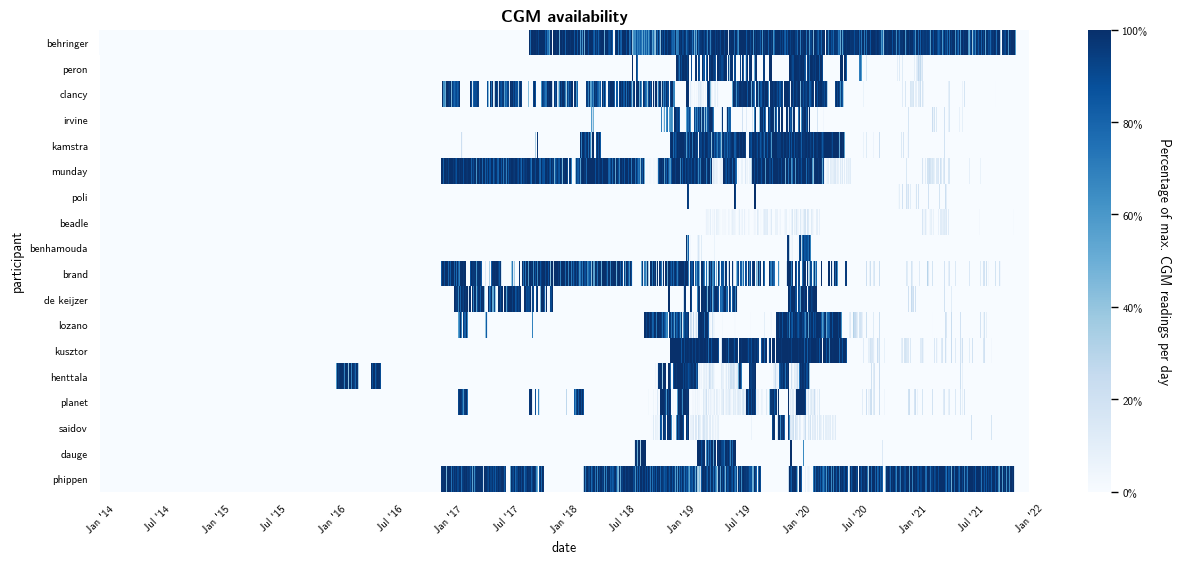

In [15]:
ax = plot_availability(dc_avail, rot_months=45, itv_months=6)
plt.title('CGM availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability_all', yticks=ax)

In [16]:
pro_list = pro.set_index('RIDER').stack().replace({'-':'np.nan'}).reset_index().rename(columns={'level_1':'year', 0:'pro'})
pro_list['year'] = pro_list['year'].astype(int)
pro_list.columns = pd.MultiIndex.from_product([pro_list.columns, ['']])
pro_list

RIDER  year     pro
                       
0       1  2014  np.nan
1       1  2015  np.nan
2       1  2016  np.nan
3       1  2017     DEV
4       1  2018     DEV
..    ...   ...     ...
139    18  2017     DEV
140    18  2018     DEV
141    18  2019     DEV
142    18  2020     DEV
143    18  2021     PRO

[144 rows x 3 columns]

In [17]:
# note that this is not an accurate list of pro's but is just used for demonstration
# (does not take into account start and end of the season)
tp_agg['year'] = tp_agg['date'].dt.year
tp_agg = pd.merge(tp_agg, pro_list, on=['RIDER', 'year'], how='left')
tp_agg = tp_agg.drop([('year')], axis=1)
tp_agg

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


RIDER       date            TIME                       \
                       timestamp_count  local_timestamp_min   
0         1 2016-11-22          7446.0  2016-11-22 12:58:57   
1         1 2016-11-23          7312.0  2016-11-23 14:29:13   
2         1 2016-11-24          6285.0  2016-11-24 09:53:38   
3         1 2016-11-26          7445.0  2016-11-26 10:00:35   
4         1 2016-12-06         11222.0  2016-12-06 09:11:34   
...     ...        ...             ...                  ...   
30207    18 2021-11-18          4767.0  2021-11-18 14:58:17   
30208    18 2021-11-25         10912.0  2021-11-25 09:50:57   
30209    18 2021-11-26          8737.0  2021-11-26 10:12:34   
30210    18 2021-11-27         18222.0  2021-11-27 09:31:58   
30211    18 2021-11-28         14549.0  2021-11-28 10:02:22   

                                                CALENDAR                      \
       local_timestamp_max file_id_unique_count     race travel race_3d_mean   
0      2016-11-22 15:15:40                  1.0    False   True          0.0   
1      2016-11-23 16:35:14                  1.0    False  False          0.0   
2      2016-11-24 16:56:38                  2.0    False  False          0.0   
3      2016-11-26 12:12:52                  1.0    False  False          0.0   
4      2016-12-06 16:11:38                  2.0    False  False          0.0   
...                    ...                  ...      ...    ...          ...   
30207  2021-11-18 16:19:15                  1.0    False  False          0.0   
30208  2021-11-25 12:54:14                  1.0    False  False          0.0   
30209  2021-11-26 12:39:08                  1.0    False  False          0.0   
30210  2021-11-27 14:36:43                  1.0    False  False          0.0   
30211  2021-11-28 14:21:57                  1.0    False  False          0.0   

                    ...                LOC                     \
      race_7d_mean  ... vertical_speed_max vertical_speed_sum   
0              0.0  ...                NaN                NaN   
1              0.0  ...                NaN                NaN   
2              0.0  ...                NaN                NaN   
3              0.0  ...                NaN                NaN   
4              0.0  ...                NaN                NaN   
...            ...  ...                ...                ...   
30207          0.0  ...                NaN                NaN   
30208          0.0  ...                NaN                NaN   
30209          0.0  ...                NaN                NaN   
30210          0.0  ...                NaN                NaN   
30211          0.0  ...                NaN                NaN   

                                                                     \
      vertical_speed_energy vertical_speed_peaks vertical_speed_rms   
0                       NaN                  NaN                NaN   
1                       NaN                  NaN                NaN   
2                       NaN                  NaN                NaN   
3                       NaN                  NaN                NaN   
4                       NaN                  NaN                NaN   
...                     ...                  ...                ...   
30207                   NaN                  NaN                NaN   
30208                   NaN                  NaN                NaN   
30209                   NaN                  NaN                NaN   
30210                   NaN                  NaN                NaN   
30211                   NaN                  NaN                NaN   

                                                                              \
      distance_up_iqr vertical_speed_iqr acceleration_iqr elevation_gain_iqr   
0                 NaN                NaN              NaN                NaN   
1                 NaN                NaN              NaN                NaN   
2                 NaN                NaN              N

In [18]:
tp_avail = tp_agg.pivot(index='RIDER', columns='date', values='pro')
tp_avail = tp_avail.replace({'PRO':2, 'DEV':1, 'np.nan':np.nan})

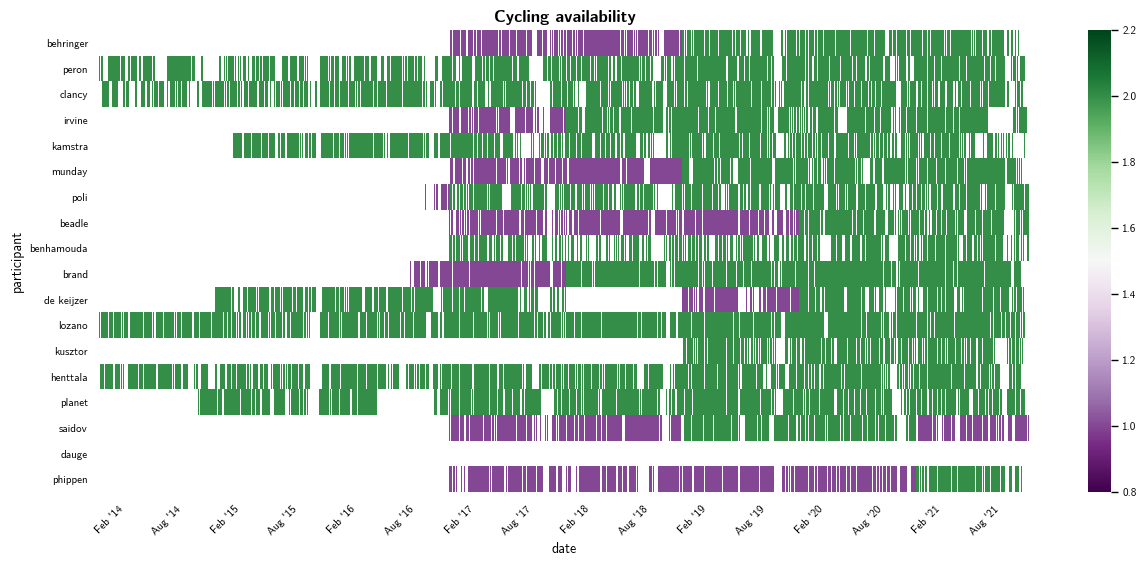

In [19]:
ax = plot_availability(tp_avail, cmap='PRGn', vmin=0.8, vmax=2.2, 
                       rot_months=45, itv_months=6, plot_colorbar=False)
plt.title('Cycling availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability_all', dtype='TrainingPeaks', yticks=ax)

In [20]:
tp_agg = tp_agg.drop('pro', axis=1)

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [21]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg.dropna(subset=['glucose_mean_day'])))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc.dropna(subset=['Glucose Value (mg/dL)'])[['RIDER', 'date']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 18 ; D = 30212
Dexcom (agg): N = 18 ; D = 11785
Dexcom: N = 18 ; D = 11785


Identify exercise days

In [22]:
# identify exercise days
days_ex = dc.loc[dc['exercise'], ['RIDER', 'date']].drop_duplicates()
days_ex['exercise_day'] = True
days_ex = days_ex.set_index(['RIDER', 'date'])

dc = pd.merge(dc, days_ex, on=['RIDER', 'date'], how='left')
dc['exercise_day'] = dc['exercise_day'].fillna(False).astype(bool)

In [23]:
# rename columns so there is no confusion
dc = dc.rename(columns={'race':'race_day', 'travel':'travel_day'})

In [24]:
print("Race days: ", 
      len(dc.loc[dc['race_day'], ['RIDER', 'date']].drop_duplicates()))
print("Race days with CGM during exercise: ", 
      len(dc.loc[dc['exercise_day'] & dc['race_day'], ['RIDER', 'date']].drop_duplicates()))
print("Training days: ", 
      len(dc.loc[dc['exercise_day'] & ~dc['race_day'], ['RIDER', 'date']].drop_duplicates()))
print("Exercise days: ", 
      len(dc.loc[dc['exercise_day'], ['RIDER', 'date']].drop_duplicates()))

Race days:  3710
Race days with CGM during exercise:  3202
Training days:  27042
Exercise days:  30244


Note: there are race days on which there is no CGM during exercise recorded!!! (Because exercise just tells us whether there is a part marked as exercise in the CGM data.)

Redefine day to be between 06am and 06am

In [25]:
dc_agg = dc_agg.set_index(['RIDER', 'date'])

cols_sleep = dc_agg.columns[dc_agg.columns.str.endswith('sleep')]
dc_agg[cols_sleep] = dc_agg.groupby('RIDER')[cols_sleep].apply(lambda x: x.shift(-1))

dc_agg = dc_agg.dropna(subset=['glucose_mean_'+i for i in ('exercise', 'recovery', 'sleep', 'wake')], how='all')
dc_agg = dc_agg.reset_index()

# note that everything ending with _day still has the old day definition in there 
# (so we should actually be dropping this as well)

In [26]:
dc['date_6h'] = pd.to_datetime((dc.local_timestamp - pd.to_timedelta('6h')).dt.date)

In [27]:
# align race and travel data with new dates
days = dc[['RIDER', 'date', 'race_day', 'travel_day', 'exercise_day']].drop_duplicates()
dc = pd.merge(dc, days, left_on=['RIDER', 'date_6h'], right_on=['RIDER', 'date'], how='left', suffixes=('', '_6h'))
dc = dc.loc[:,~dc.columns.duplicated()]
dc['race_day_6h'] = dc['race_day_6h'].astype(bool)
dc['travel_day_6h'] = dc['travel_day_6h'].astype(bool)
dc['exercise_day_6h'] = dc['exercise_day_6h'].astype(bool)

In [28]:
print("Race days 6h: ", 
      len(dc.loc[dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Race days 6h with CGM during exercise: ", 
      len(dc.loc[dc['exercise_day_6h'] & dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Training days 6h: ", 
      len(dc.loc[dc['exercise_day_6h'] & ~dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Exercise days 6h: ", 
      len(dc.loc[dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))

Race days 6h:  3727
Race days 6h with CGM during exercise:  3219
Training days 6h:  27042
Exercise days 6h:  30261


In [29]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc.dropna(subset=['Glucose Value (mg/dL)'])[['RIDER', 'date_6h']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 18 ; D = 30212
Dexcom (agg): N = 18 ; D = 11810
Dexcom: N = 18 ; D = 11808


Note: the difference between dc_agg and dc lies in the fact that there can be also glucose measurements in the sleep period that is now moved to the next day. (For instance, there is cgm data during a cycling session that took place between 5am and 6am.) For the dc data, now this cycling session is not accounted to this day but still to the previous day. For the dc_agg data, this is done correctly and it is taken into account for the next day. As we only use the dc data for calculating the statistics on a rider-level, we can just ignore the fact that this happens.

### Select data

Select riders that were pro in 2019

In [30]:
ATHLETES = pro.loc[pro['2019'] == 'PRO', 'RIDER'].to_list()

In [31]:
info = info[info.RIDER.isin(ATHLETES)].set_index('RIDER')
season = season[season.RIDER.isin(ATHLETES)].set_index('RIDER')
hba1c = hba1c[hba1c.RIDER.isin(ATHLETES)].set_index('RIDER')

In [32]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg[tp_agg.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(tp_agg[tp_agg.RIDER.isin(ATHLETES)]))
print("Dexcom (agg): N =", len(dc_agg[dc_agg.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(dc_agg[dc_agg.RIDER.isin(ATHLETES)]))
print("Dexcom: N =", len(dc[dc.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(dc[dc.RIDER.isin(ATHLETES)].dropna(subset=['Glucose Value (mg/dL)'])[['RIDER', 'date_6h']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 14 ; D = 25116
Dexcom (agg): N = 14 ; D = 9248
Dexcom: N = 14 ; D = 9246


Select beginning and end of the training season in 2019

In [33]:
hba1c = hba1c['2019']
hba1c

RIDER
1     6.333333
2     6.533333
3     6.850000
4     8.000000
5     6.725000
6     6.550000
7     6.366667
9     7.025000
10    7.233333
12    5.950000
13    6.366667
14    6.925000
15    6.525000
16    6.825000
Name: 2019, dtype: float64

In [34]:
season = season['2019']

season['start'] = pd.to_datetime(season['start'])
season['end'] = pd.to_datetime(season['end'])

season_list = season.apply(lambda x: pd.date_range(x[0], x[1], freq='1D'), axis=1)\
    .apply(pd.Series).stack().reset_index().drop('level_1', axis=1).rename(columns={0:'date'})
season_list

RIDER       date
0         1 2018-11-05
1         1 2018-11-06
2         1 2018-11-07
3         1 2018-11-08
4         1 2018-11-09
...     ...        ...
4642     16 2019-09-25
4643     16 2019-09-26
4644     16 2019-09-27
4645     16 2019-09-28
4646     16 2019-09-29

[4647 rows x 2 columns]

In [35]:
tp_agg = pd.merge(tp_agg, season_list, how='inner', on=['RIDER', 'date'])
tp_agg

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


RIDER       date            TIME                       \
                      timestamp_count  local_timestamp_min   
0        1 2018-11-05          7767.0  2018-11-05 09:34:13   
1        1 2018-11-06          8065.0  2018-11-06 09:24:16   
2        1 2018-11-07         11349.0  2018-11-07 10:05:29   
3        1 2018-11-08          7649.0  2018-11-08 09:52:38   
4        1 2018-11-09         11297.0  2018-11-09 11:14:27   
...    ...        ...             ...                  ...   
3823    16 2019-09-22          7113.0  2019-09-22 10:00:18   
3824    16 2019-09-24          6530.0  2019-09-24 15:39:16   
3825    16 2019-09-27          7462.0  2019-09-27 14:50:03   
3826    16 2019-09-28          3157.0  2019-09-28 07:48:34   
3827    16 2019-09-29          3188.0  2019-09-29 08:00:16   

                                               CALENDAR                      \
      local_timestamp_max file_id_unique_count     race travel race_3d_mean   
0     2018-11-05 11:44:12                  1.0    False  False          0.0   
1     2018-11-06 11:51:24                  1.0    False  False          0.0   
2     2018-11-07 14:45:37                  2.0    False  False          0.0   
3     2018-11-08 12:00:51                  1.0    False  False          0.0   
4     2018-11-09 14:30:32                  1.0    False  False          0.0   
...                   ...                  ...      ...    ...          ...   
3823  2019-09-22 11:58:50                  1.0     True  False          1.0   
3824  2019-09-24 17:33:43                  1.0    False   True          0.5   
3825  2019-09-27 16:56:26                  1.0    False  False          0.0   
3826  2019-09-28 11:16:50                  3.0    False  False          0.0   
3827  2019-09-29 10:33:36                  2.0    False  False          0.0   

                   ...                LOC                     \
     race_7d_mean  ... vertical_speed_min vertical_speed_max   
0            0.00  ...                NaN                NaN   
1            0.00  ...                NaN                NaN   
2            0.00  ...                NaN                NaN   
3            0.00  ...                NaN                NaN   
4            0.00  ...                NaN                NaN   
...           ...  ...                ...                ...   
3823         1.00  ...                NaN                NaN   
3824         0.75  ...                NaN                NaN   
3825         0.50  ...                NaN                NaN   
3826         0.25  ...                NaN                NaN   
3827         0.00  ...                NaN                NaN   

                                                                    \
     vertical_speed_sum vertical_speed_energy vertical_speed_peaks   
0                   NaN                   NaN                  NaN   
1                   NaN                   NaN                  NaN   
2                   NaN                   NaN                  NaN   
3                   NaN                   NaN                  NaN   
4                   NaN                   NaN                  NaN   
...                 ...                   ...                  ...   
3823                NaN                   NaN                  NaN   
3824                NaN                   NaN                  NaN   
3825                NaN                   NaN                  NaN   
3826                NaN                   NaN                  NaN   
3827                NaN                   NaN                  NaN   

                                                                             \
     vertical_speed_rms distance_up_iqr vertical_speed_iqr acceleration_iqr   
0                   NaN             NaN                NaN              NaN   
1                   NaN             NaN                NaN              NaN   
2                   NaN             NaN                NaN              NaN   
3                   NaN        

In [36]:
dc_agg = pd.merge(dc_agg, season_list, how='inner', on=['RIDER', 'date'])
dc_agg

RIDER       date  time_in_hypo_exercise  time_in_hypoL2_exercise  \
0         1 2018-11-05                   10.0                      4.0   
1         1 2018-11-06                    1.0                      0.0   
2         1 2018-11-07                   27.0                     10.0   
3         1 2018-11-08                   10.0                      1.0   
4         1 2018-11-09                    3.0                      0.0   
...     ...        ...                    ...                      ...   
3066     16 2019-04-25                    2.0                      0.0   
3067     16 2019-04-26                    0.0                      0.0   
3068     16 2019-04-27                    0.0                      0.0   
3069     16 2019-04-30                    0.0                      0.0   
3070     16 2019-08-12                    0.0                      0.0   

      time_in_hypoL1_exercise  time_in_target_exercise  \
0                         6.0                      2.0   
1                         1.0                     19.0   
2                        17.0                     25.0   
3                         9.0                     16.0   
4                         3.0                     32.0   
...                       ...                      ...   
3066                      2.0                     42.0   
3067                      0.0                     22.0   
3068                      0.0                     11.0   
3069                      0.0                      0.0   
3070                      0.0                     24.0   

      time_in_hyper_exercise  time_in_hyperL1_exercise  \
0                        0.0                       0.0   
1                        0.0                       0.0   
2                        5.0                       5.0   
3                        0.0                       0.0   
4                        5.0                       5.0   
...                      ...                       ...   
3066                     1.0                       1.0   
3067                     0.0                       0.0   
3068                     9.0                       9.0   
3069                    25.0                      23.0   
3070                     0.0                       0.0   

      time_in_hyperL2_exercise  glucose_mean_exercise  ...  glucose_std_day  \
0                          0.0              59.500000  ...        56.705728   
1                          0.0             128.550000  ...        35.423009   
2                          0.0              85.333333  ...        50.113354   
3                          0.0              73.115385  ...        43.911998   
4                          0.0             110.375000  ...        51.618469   
...                        ...                    ...  ...              ...   
3066                       0.0             110.266667  ...        29.171995   
3067                       0.0             129.545455  ...        19.308837   
3068                       0.0             169.050000  ...        38.900667   
3069                       2.0             239.480000  ...         8.651901   
3070                       0.0             115.166667  ...        17.464664   

      glucose_cv_day  glucose_rate_day  completeness_day  count_day  LBGI_day  \
0           0.441880        128.328302          0.920139        265  2.419600   
1           0.334281        105.967626          0.965278        278  2.871435   
2           0.498897        100.448276          0.906250        261  7.604452   
3           0.378438        116.034722          1.000000        288  2.116019   
4           0.492795        104.746377          0.958333        276  5.616227   
...              ...               ...               ...        ...       ...   
3066        0.264729        110.195652          0.159722         46  0.266075   
3067        0.149051        129.545455          0.076389         22  0.002101   
3068        0.233604        166.523810       

In [37]:
dc = pd.merge(dc, season_list, how='inner', left_on=['RIDER', 'date_6h'], right_on=['RIDER', 'date'])
dc = dc.drop('date_y', axis=1)
dc = dc.rename(columns={'date_x':'date'})
dc

RIDER           timestamp  Glucose Value (mg/dL)     local_timestamp  \
0            1 2018-11-05 05:00:00                   73.0 2018-11-05 06:00:00   
1            1 2018-11-05 05:05:00                   73.0 2018-11-05 06:05:00   
2            1 2018-11-05 05:10:00                   73.0 2018-11-05 06:10:00   
3            1 2018-11-05 05:15:00                   73.0 2018-11-05 06:15:00   
4            1 2018-11-05 05:20:00                   73.0 2018-11-05 06:20:00   
...        ...                 ...                    ...                 ...   
1338067     16 2019-09-30 09:35:00                    NaN 2019-09-30 05:35:00   
1338068     16 2019-09-30 09:40:00                    NaN 2019-09-30 05:40:00   
1338069     16 2019-09-30 09:45:00                    NaN 2019-09-30 05:45:00   
1338070     16 2019-09-30 09:50:00                    NaN 2019-09-30 05:50:00   
1338071     16 2019-09-30 09:55:00                    NaN 2019-09-30 05:55:00   

         exercise  recovery   wake  sleep  race_day  travel_day       date  \
0           False     False   True  False     False       False 2018-11-05   
1           False     False   True  False     False       False 2018-11-05   
2           False     False   True  False     False       False 2018-11-05   
3           False     False   True  False     False       False 2018-11-05   
4           False     False   True  False     False       False 2018-11-05   
...           ...       ...    ...    ...       ...         ...        ...   
1338067     False     False  False   True     False       False 2019-09-30   
1338068     False     False  False   True     False       False 2019-09-30   
1338069     False     False  False   True     False       False 2019-09-30   
1338070     False     False  False   True     False       False 2019-09-30   
1338071     False     False  False   True     False       False 2019-09-30   

         exercise_day    date_6h  race_day_6h  travel_day_6h  exercise_day_6h  
0                True 2018-11-05        False          False             True  
1                True 2018-11-05        False          False             True  
2                True 2018-11-05        False          False             True  
3                True 2018-11-05        False          False             True  
4                True 2018-11-05        False          False             True  
...               ...        ...          ...            ...              ...  
1338067         False 2019-09-29        False          False             True  
1338068         False 2019-09-29        False          False             True  
1338069         False 2019-09-29        False          False             True  
1338070         False 2019-09-29        False          False             True  
1338071         False 2019-09-29        False          False             True  

[1338072 rows x 16 columns]

In [38]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc.dropna(subset=['Glucose Value (mg/dL)'])[['RIDER', 'date_6h']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 14 ; D = 3828
Dexcom (agg): N = 14 ; D = 3071
Dexcom: N = 14 ; D = 3071


In [39]:
print("Race days 6h: ", 
      len(dc.loc[dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Race days 6h with CGM during exercise: ", 
      len(dc.loc[dc['exercise_day_6h'] & dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Training days 6h: ", 
      len(dc.loc[dc['exercise_day_6h'] & ~dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Exercise days 6h: ", 
      len(dc.loc[dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))

Race days 6h:  479
Race days 6h with CGM during exercise:  466
Training days 6h:  3362
Exercise days 6h:  3828


#### Glucose completeness

In [40]:
completeness = pd.read_csv(DATA_PATH+'agg/dexcom_completeness_6h.csv', index_col=0)
completeness = completeness.rename(columns={'0':'completeness'})
completeness['date_6h'] = pd.to_datetime(completeness['date_6h'])
completeness

RIDER    date_6h  completeness
0          1 2013-12-31           0.0
1          1 2014-01-01           0.0
2          1 2014-01-02           0.0
3          1 2014-01-03           0.0
4          1 2014-01-04           0.0
...      ...        ...           ...
52609     18 2021-12-27           0.0
52610     18 2021-12-28           0.0
52611     18 2021-12-29           0.0
52612     18 2021-12-30           0.0
52613     18 2021-12-31           0.0

[52614 rows x 3 columns]

In [41]:
dc_agg = pd.merge(dc_agg, completeness, left_on=['RIDER', 'date'], right_on=['RIDER', 'date_6h'], how='left')
dc_agg = dc_agg.drop('date_6h', axis=1)

In [42]:
dc = pd.merge(dc, completeness, on=['RIDER', 'date_6h'], how='left')

In [43]:
len(dc[dc.completeness >= 0.7])/len(dc)

0.45881835955015876

In [44]:
len(dc_agg['completeness'] >= 0.7)/len(dc_agg)

1.0

In [45]:
dc_agg['completeness']

0       0.920139
1       0.965278
2       0.906250
3       1.000000
4       0.958333
          ...   
3066    0.159722
3067    0.076389
3068    0.072917
3069    0.090278
3070    0.060606
Name: completeness, Length: 3071, dtype: float64

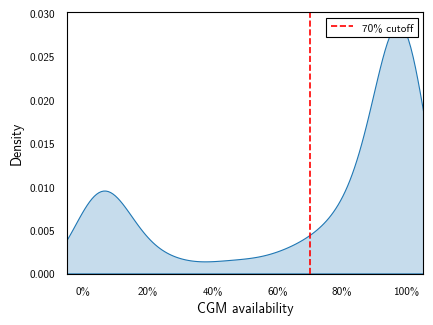

In [46]:
from matplotlib.ticker import PercentFormatter
plt.figure()
#ax = sns.distplot(dc_agg['completeness']*100, hist=False)
ax = sns.kdeplot(dc_agg['completeness']*100, fill=True)
plt.axvline(70, ls='--', color='red', label='70% cutoff')
#plt.text(90,200, '{:.0f}%'.format((dc_agg['completeness'] >= 0.7).sum()/dc_agg['completeness'].count()*100))
plt.xlabel('CGM availability')
plt.xlim((-5, 105))
ax.xaxis.set_major_formatter(PercentFormatter())
plt.legend()
plt.savefig(SAVE_PATH+'completeness_cutoff_pdf.png', dpi=1000, bbox_inches='tight')
plt.savefig(SAVE_PATH+'completeness_cutoff_pdf.pdf', bbox_inches='tight')
plt.show()
plt.close()

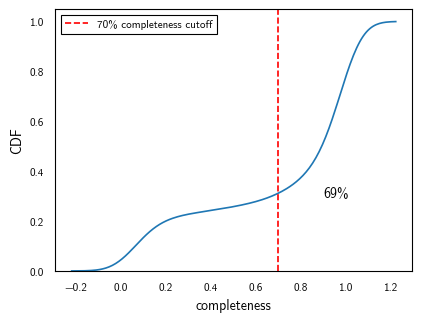

In [47]:
plt.figure()
sns.kdeplot(data=dc_agg, x='completeness', cumulative=True)
plt.axvline(0.7, ls='--', color='red', label='70% completeness cutoff')
plt.text(0.9,0.3, '{:.0f}%'.format((dc_agg['completeness'] >= 0.7).sum()/dc_agg['completeness'].count()*100))
plt.legend()
plt.ylabel('CDF')
plt.savefig(SAVE_PATH+'completeness_cutoff_cdf.png', dpi=300, bbox_inches='tight')
plt.show()

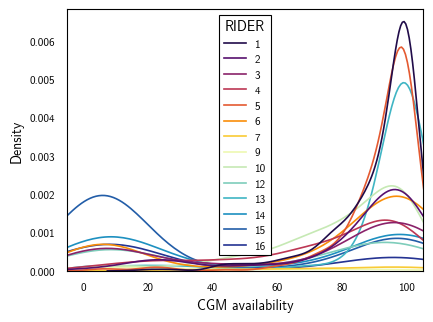

In [48]:
plt.figure()
sns.kdeplot(data=dc_agg, x=dc_agg['completeness']*100, hue='RIDER', palette= sns.color_palette('inferno', n_colors=7)+ sns.color_palette('YlGnBu', n_colors=7))
plt.xlabel('CGM availability')
plt.xlim((-5, 105))
ax.xaxis.set_major_formatter(PercentFormatter())
plt.show()

Calendar with glucose availability

In [49]:
dc_avail = pd.merge(dc_agg, season_list, how='right', on=['RIDER', 'date'])\
    .pivot(index='RIDER', columns='date', values='completeness')

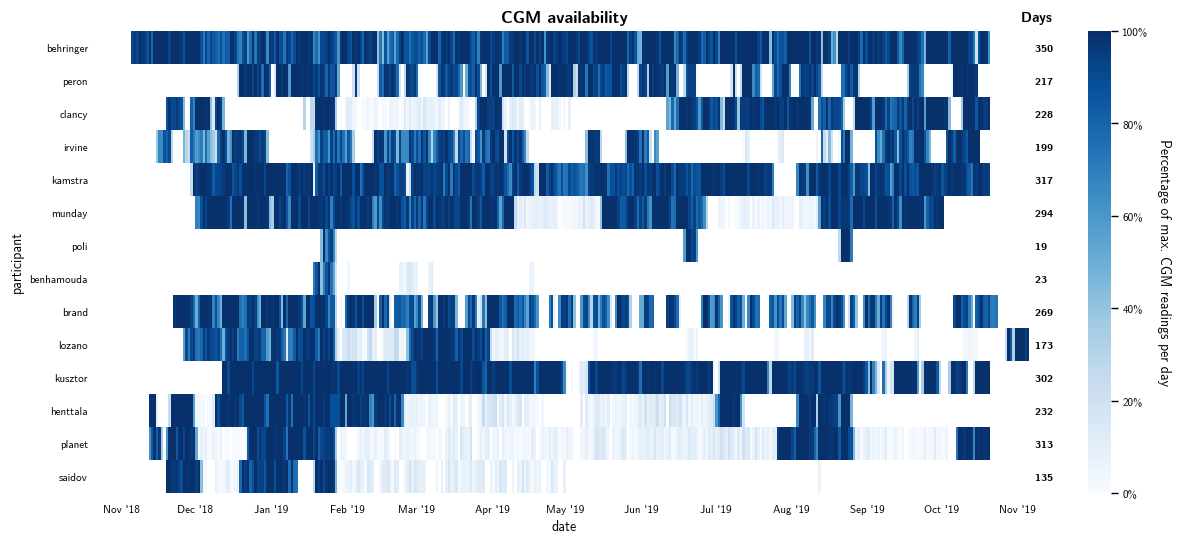

In [50]:
ax = plot_availability(dc_avail, plot_total='count')
plt.title('CGM availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability', yticks=ax)

Select data with glucose completeness >= 70% (on a day from 6am to 6am) and remove nans from dexcom data

In [51]:
dc.loc[dc['completeness'] < 0.7, 'Glucose Value (mg/dL)'] = np.nan
dc = dc.dropna(subset=['Glucose Value (mg/dL)'])

In [52]:
dc_agg = dc_agg[dc_agg['completeness'] >= 0.7]

In [53]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc[['RIDER', 'date_6h']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 14 ; D = 3828
Dexcom (agg): N = 14 ; D = 2133
Dexcom: N = 14 ; D = 2133


In [54]:
print("Race days 6h: ", 
      len(dc.loc[dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Race days 6h with CGM during exercise: ", 
      len(dc.loc[dc['exercise_day_6h'] & dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Training days 6h: ", 
      len(dc.loc[dc['exercise_day_6h'] & ~dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Exercise days 6h: ", 
      len(dc.loc[dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))

Race days 6h:  270
Race days 6h with CGM during exercise:  265
Training days 6h:  1543
Exercise days 6h:  1808


Select participants with 14 or more days of data

In [55]:
mask = dc_agg.groupby('RIDER')['date'].nunique() >= 14
ATHLETES = mask[mask].index

info = info.loc[ATHLETES]
season_list = season_list[season_list.RIDER.isin(ATHLETES)]
hba1c = hba1c.loc[ATHLETES]

tp_agg = tp_agg[tp_agg.RIDER.isin(ATHLETES)]
dc_agg = dc_agg[dc_agg.RIDER.isin(ATHLETES)]
dc = dc[dc.RIDER.isin(ATHLETES)]

In [56]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc[['RIDER', 'date_6h']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 12 ; D = 3370
Dexcom (agg): N = 12 ; D = 2115
Dexcom: N = 12 ; D = 2115


In [57]:
print("Race days 6h: ", 
      len(dc.loc[dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Race days 6h with CGM during exercise: ", 
      len(dc.loc[dc['exercise_day_6h'] & dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Training days 6h: ", 
      len(dc.loc[dc['exercise_day_6h'] & ~dc['race_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))
print("Exercise days 6h: ", 
      len(dc.loc[dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates()))

Race days 6h:  261
Race days 6h with CGM during exercise:  256
Training days 6h:  1534
Exercise days 6h:  1790


Incorporate HbA1c in info

In [58]:
info = info.drop('HbA1c', axis=1)
hba1c.name = 'HbA1c'
info = pd.merge(info, hba1c, left_index=True, right_index=True, how='left')
info

gender  nationality  age  diabetes_duration     weight     bf(%)  \
RIDER                                                                    
1          M  Switzerland   22                 11  60.500000  9.066667   
2          M        Italy   30                 14  71.633333  8.833333   
3          M      Ireland   26                  7  66.733333  6.566667   
4          M    Australia   19                  7  78.666667  9.433333   
5          M  Netherlands   25                  6  69.633333  7.700000   
6          M    Australia   20                  9  56.700000  4.950000   
10         M           UK   27                 17  75.466667  7.700000   
12         M        Spain   30                  8  64.000000  5.600000   
13         M      Hungary   34                  1  60.333333  4.866667   
14         M      Finland   27                 17  75.166667  9.333333   
15         M       France   25                 15  73.766667  7.200000   
16         M   Uzbekistan   22                 13  56.666667  9.466667   

              FTP        LTHR       HRmax     VO2max  height     HbA1c  
RIDER                                                                   
1      307.000000  176.333333  192.333333  68.888889   174.0  6.333333  
2      326.000000  168.666667  181.666667  66.915285   178.0  6.533333  
3      298.000000  171.000000  180.000000  66.666164   171.0  6.850000  
4      356.000000  170.333333  187.333333  67.333333   178.0  8.000000  
5      341.000000  179.666667  192.666667  72.857143   183.0  6.725000  
6      298.500000  173.000000  184.500000  70.781588   169.0  6.550000  
10     377.333333  177.000000  194.333333  73.982571   185.0  7.233333  
12     347.000000  158.333333  178.666667  75.937500   178.0  5.950000  
13     345.666667  173.000000  182.333333  76.666667   179.0  6.366667  
14     348.000000  169.000000  189.500000  66.500000   187.0  6.925000  
15     389.000000  185.000000  198.000000  66.000000   179.0  6.525000  
16     283.333333  125.610000  200.333333  74.678571   170.0  6.825000

**Give participants a new ID (so that it is not confusing for the paper)**

In [59]:
def get_percinlevel(dc, col='Glucose Value (mg/dL)'):
	return {level: ((dc[col] >= lmin) & (dc[col] <= lmax)).sum() / len(dc)*100 for level, (lmin, lmax) in glucose_levels.items()}

In [60]:
tir = pd.Series({i: get_percinlevel(dc[dc.RIDER == i])['target'] for i in ATHLETES}).sort_values(ascending=False)

In [61]:
new_mapping = {i: n+1 for n, (i, _) in enumerate(tir.iteritems())}
new_mapping

{13: 1,
 6: 2,
 5: 3,
 12: 4,
 15: 5,
 3: 6,
 2: 7,
 1: 8,
 16: 9,
 14: 10,
 4: 11,
 10: 12}

In [62]:
ATHLETES = sorted([*map(new_mapping.get, ATHLETES)])

info.index = info.index.map(new_mapping)
info = info.sort_index()

season.index = season.index.map(new_mapping)
season = season.sort_index()

season_list.RIDER = season_list.RIDER.map(new_mapping)

tp_agg.RIDER = tp_agg.RIDER.map(new_mapping)
dc_agg.RIDER = dc_agg.RIDER.map(new_mapping)
dc.RIDER = dc.RIDER.map(new_mapping)

rider_mapping_inv = {new_mapping[k]:v for k,v in rider_mapping_inv.items() if k in new_mapping.keys()}

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [63]:
def savefig(path, i='', dtype='Dexcom', legend=None, title=None, xticks=None, yticks=None, **titlekwargs):
    if title is not None:
        plt.title(r'$\bf{Participant}$ '+r'$\bf{:d}$ - '.format(i)+title, **titlekwargs)
    if legend is not None:
        for text in legend:
            text.set_fontsize(6)
    
    plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.pdf', bbox_inches='tight')
    plt.savefig(f'{SAVE_PATH}{dtype}/{path}_{i}.png', dpi=300, bbox_inches='tight')
    
    if title is not None:
        plt.title(r'$\bf{:s}$ '.format(rider_mapping_inv[i])+title, **titlekwargs)
    if legend is not None:
        for leg in legend:
            text = leg.get_text().split()
            leg.set_text(rider_mapping_inv[int(text[0])]+' '+' '.join(text[1:]))
    if xticks is not None:
        xticks.set_xticklabels([rider_mapping_inv[int(j.get_text())] for j in xticks.get_xticklabels()], rotation=90)
    if yticks is not None:
        yticks.set_yticklabels([rider_mapping_inv[int(j.get_text())] for j in yticks.get_yticklabels()], rotation=0)
    
    if title is not None or legend is not None or xticks is not None or yticks is not None:
        plt.savefig(f'{SAVE_PATH}{dtype}/{path}_NAME_{i}.pdf', bbox_inches='tight')
        plt.savefig(f'{SAVE_PATH}{dtype}/{path}_NAME_{i}.png', dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()

In [64]:
dc_avail = pd.merge(dc_agg, season_list, how='right', on=['RIDER', 'date'])\
    .pivot(index='RIDER', columns='date', values='completeness')

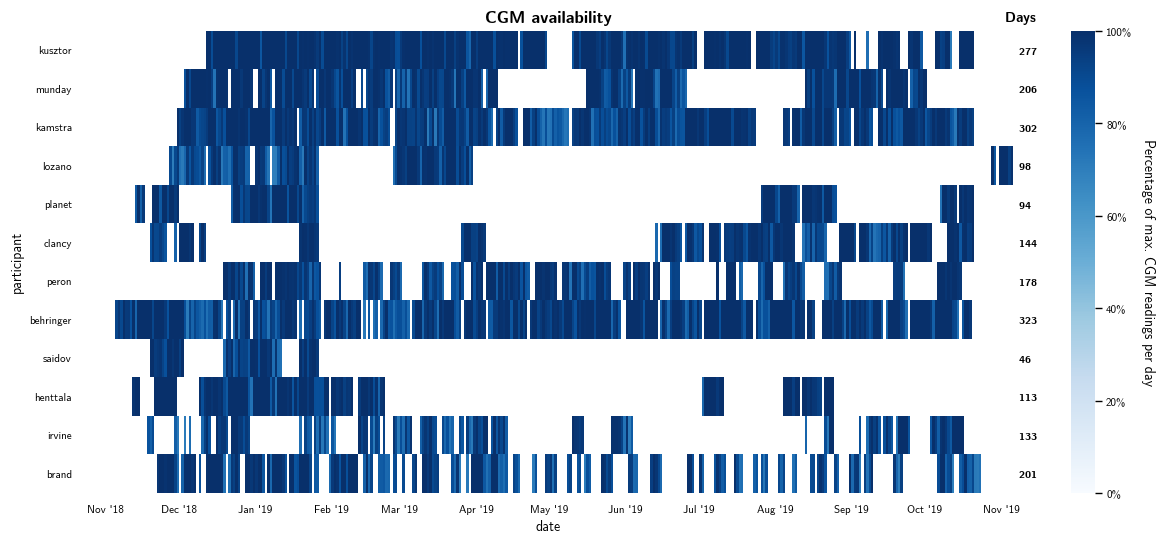

In [65]:
ax = plot_availability(dc_avail, plot_total='count')
plt.title('CGM availability', fontweight='bold', fontsize=12)
savefig('availability/glucose_availability_selectcomp', yticks=ax)

## Descriptives Dexcom

### Glucose distribution (histograms)

All data

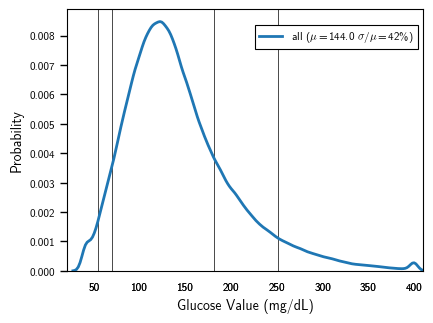

In [66]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
sns.kdeplot(dc[COL], ax=ax, linewidth=2,
	label=r'all ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
	.format(dc[COL].mean(), dc[COL].std()/dc[COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
ax.set_xlabel(COL)
savefig(path='hist/hist_glucose')

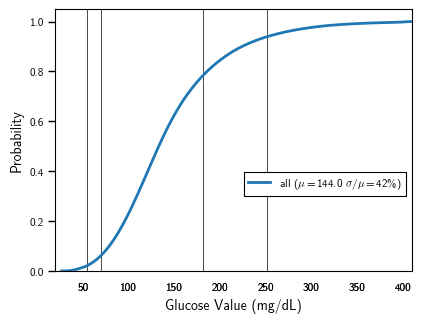

In [67]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
sns.kdeplot(dc[COL], ax=ax, cumulative=True, linewidth=2,
	label=r'all ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
	.format(dc[COL].mean(), dc[COL].std()/dc[COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.4))
ax.set_xlabel(COL)
savefig(path='cdf/cdf_glucose')

All, hue: sections

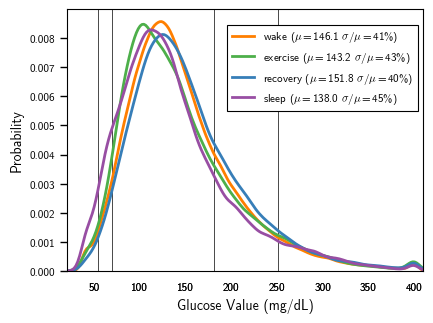

In [68]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
for k, sec in enumerate(SECTIONS):
	sns.kdeplot(dc[dc[sec]][COL], ax=ax, linewidth=2, color=color_sec[sec],
		label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'.format(dc[dc[sec]][COL].mean(), dc[dc[sec]][COL].std()/dc[dc[sec]][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
savefig(path='hist/hist_glucose_sec')

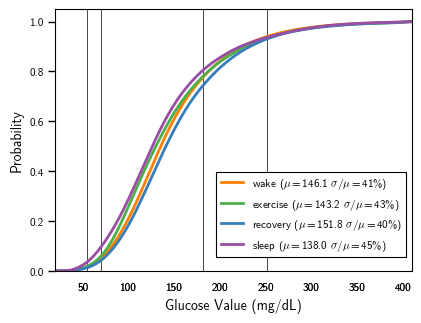

In [69]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
for k, sec in enumerate(SECTIONS):
	sns.kdeplot(dc[dc[sec]][COL], ax=ax, cumulative=True, linewidth=2, color=color_sec[sec],
		label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'.format(dc[dc[sec]][COL].mean(), dc[dc[sec]][COL].std()/dc[dc[sec]][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.4))
savefig(path='cdf/cdf_glucose_sec')

Individual athletes, hue: sections

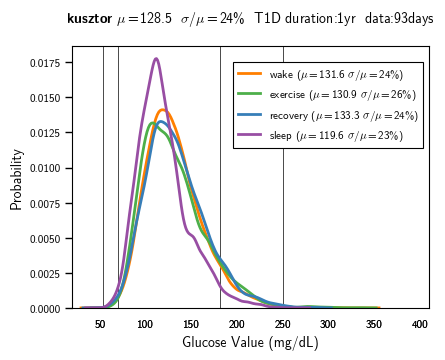

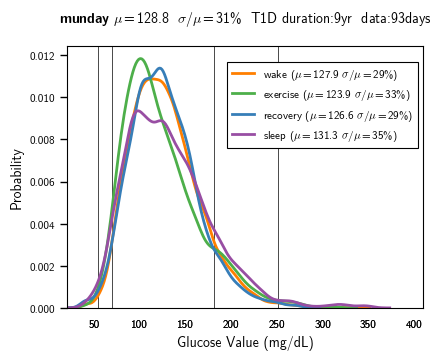

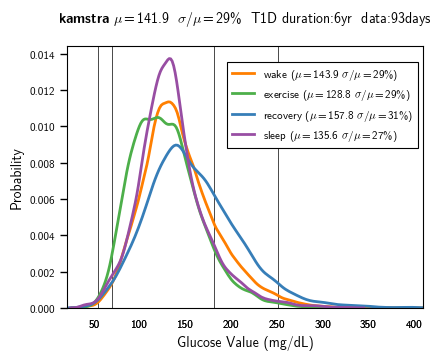

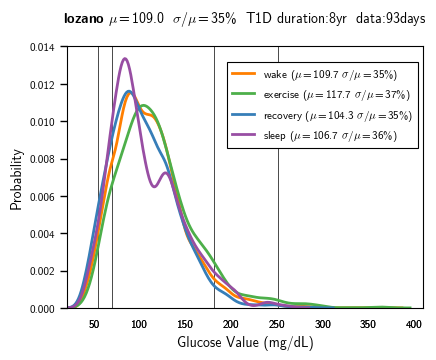

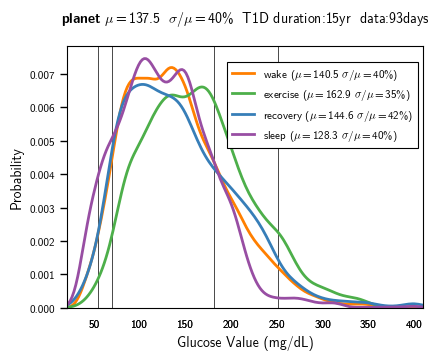

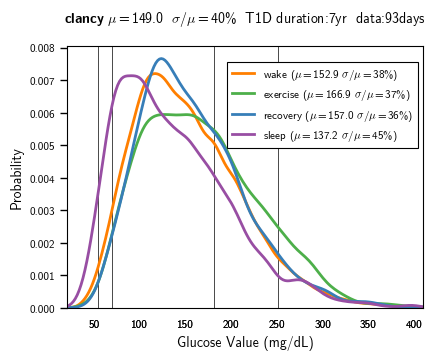

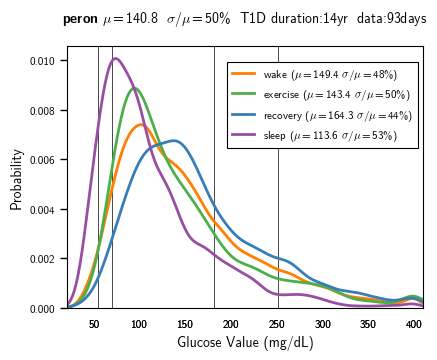

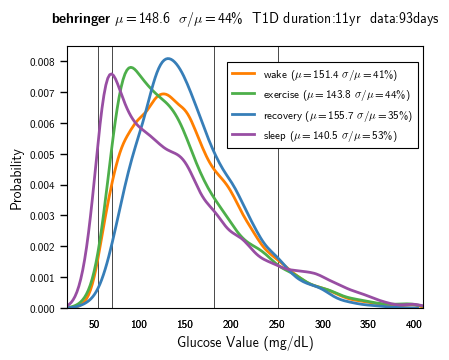

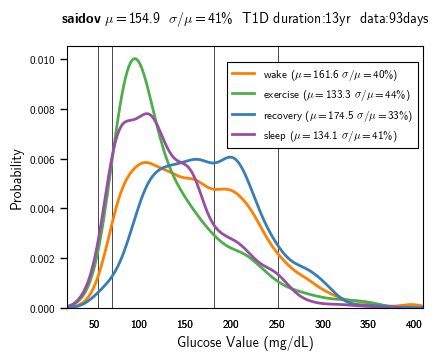

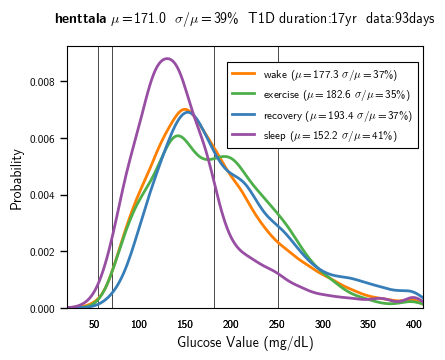

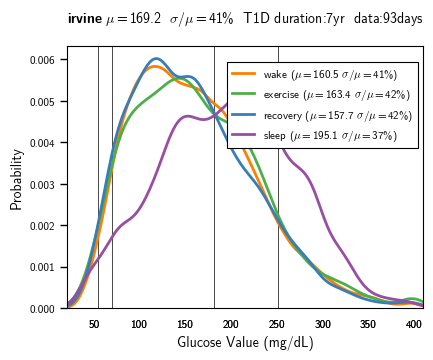

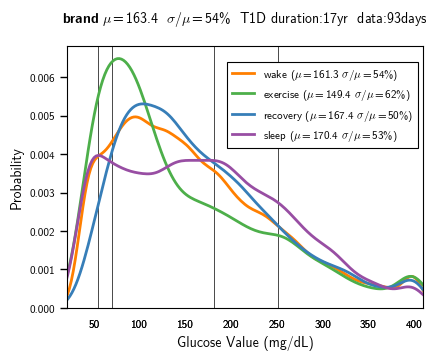

In [70]:
for i in ATHLETES:
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0)
	ax = ax0.twinx()
	
	for k, sec in enumerate(SECTIONS):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, linewidth=2, color=color_sec[sec],
			label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL)
	title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(dc[dc.RIDER == i][COL].mean(),
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				len(dc_agg.loc[i]))
	savefig(path='hist/hist_glucose_rider', i=i, title=title, y=1.06)

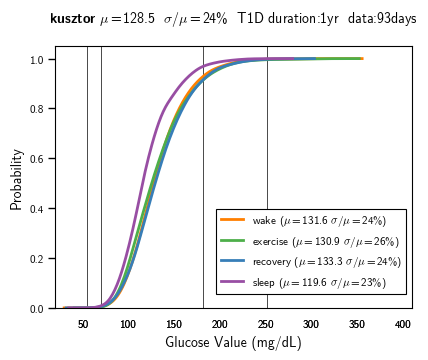

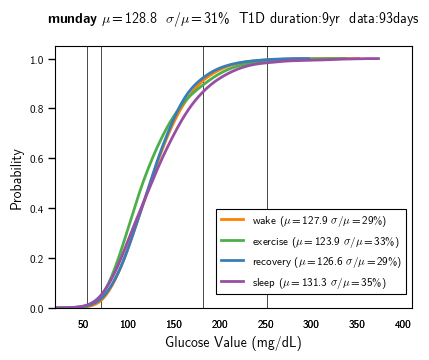

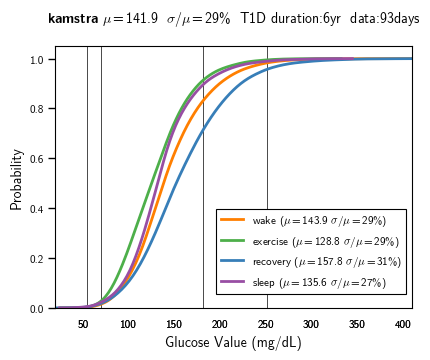

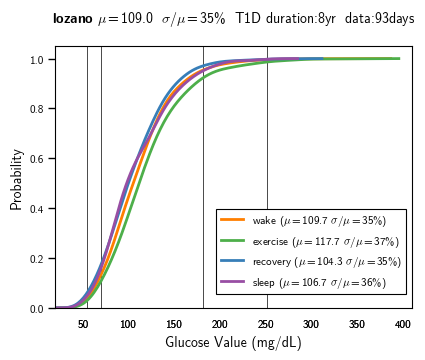

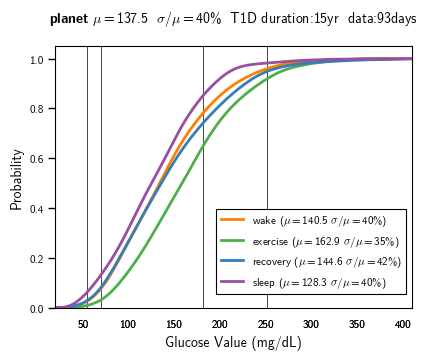

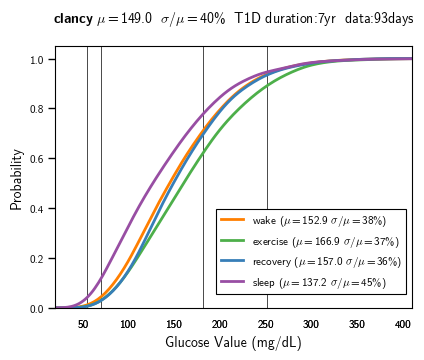

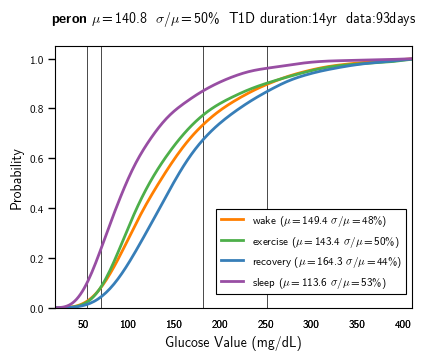

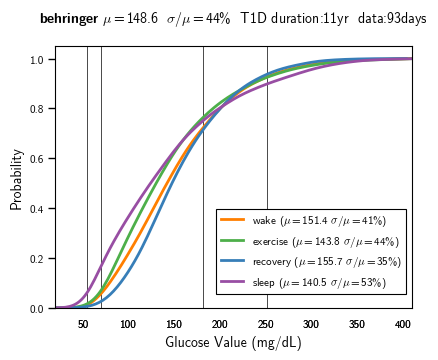

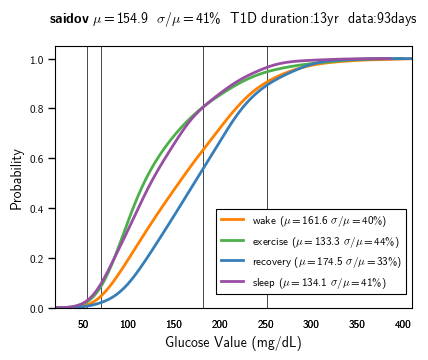

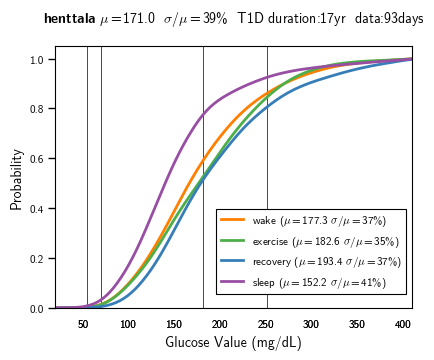

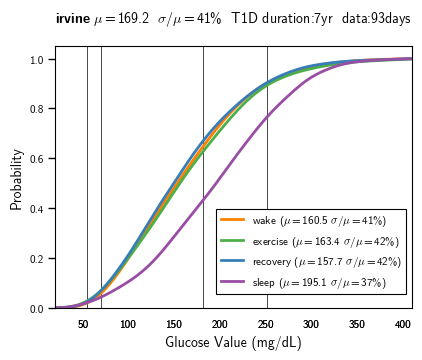

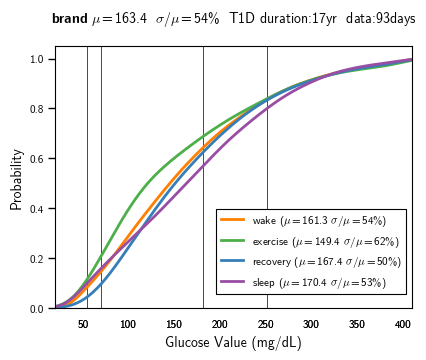

In [71]:
for i in ATHLETES:
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0)
	ax = ax0.twinx()
	
	for k, sec in enumerate(SECTIONS):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, cumulative=True, 
			linewidth=2, color=color_sec[sec],
			label=sec+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.4))
	title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(dc[dc.RIDER == i][COL].mean(),
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				len(dc_agg.loc[i]))
	savefig(path='cdf/cdf_glucose_rider', i=i, title=title, y=1.06)

All, hue: athletes

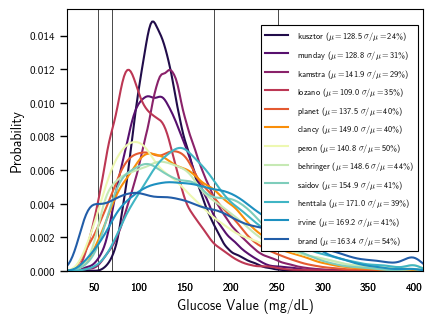

In [72]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
for c, i in enumerate(ATHLETES):
	sns.kdeplot(dc[dc.RIDER == i][COL], ax=ax, 
		linewidth=1.5, color=palette_ath[c], alpha=.8,
		label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
		.format(dc[dc.RIDER == i][COL].mean(), 
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL)
savefig(path='hist/hist_glucose_riders', legend=ax.get_legend().get_texts())

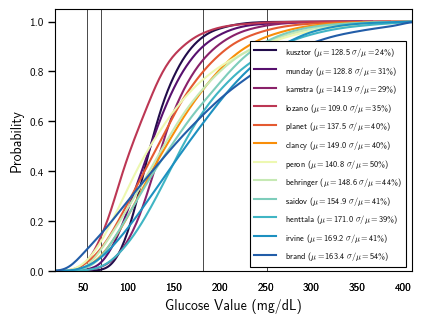

In [73]:
fig, ax0 = plt.subplots()
ax0 = plot_glucose_levels(ax0)
ax = ax0.twinx()
for c, i in enumerate(ATHLETES):
	sns.kdeplot(dc[dc.RIDER == i][COL], ax=ax, cumulative=True,
		linewidth=1.5, color=palette_ath[c], alpha=.8,
		label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
		.format(dc[dc.RIDER == i][COL].mean(), 
				dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100))
plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.9))
savefig(path='cdf/cdf_glucose_riders', legend=ax.get_legend().get_texts())

Sections individually, hue: athletes

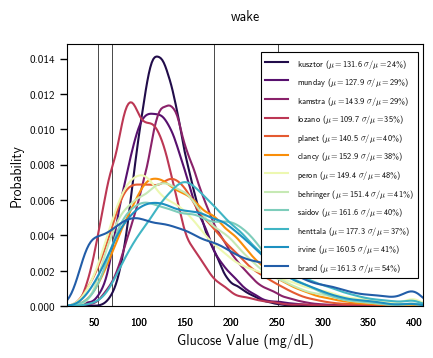

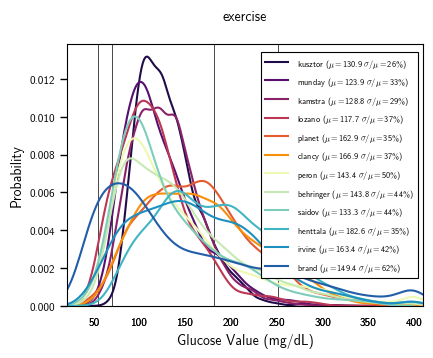

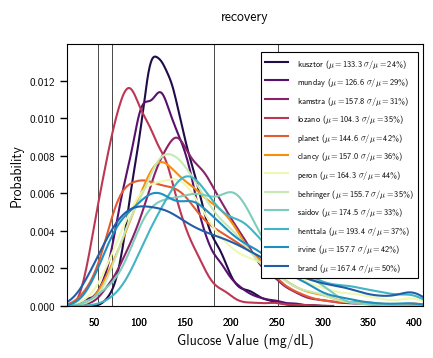

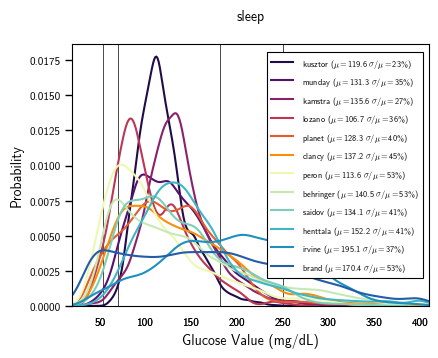

In [74]:
for k, sec in enumerate(SECTIONS):
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0)
	ax = ax0.twinx()
	for c, i in enumerate(ATHLETES):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, 
			linewidth=1.5, color=palette_ath[c], alpha=.8,
			label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.99))
	plt.title(sec, y=1.06)
	savefig(path='hist/hist_glucose_sec', i=sec, legend=ax.get_legend().get_texts())

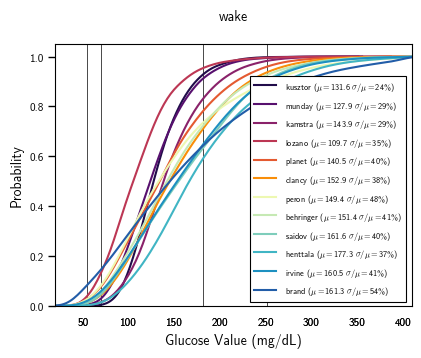

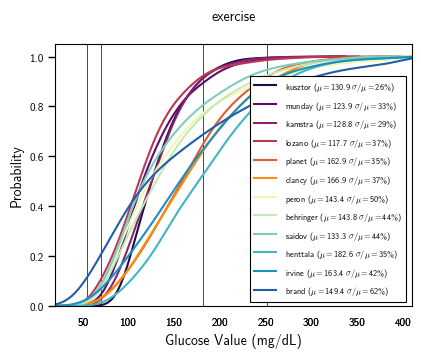

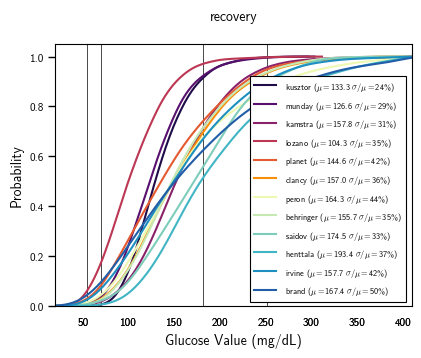

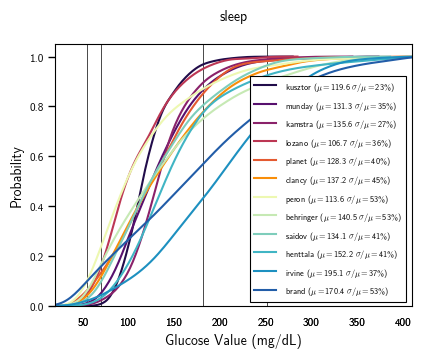

In [75]:
for k, sec in enumerate(SECTIONS):
	fig, ax0 = plt.subplots()
	ax0 = plot_glucose_levels(ax0)
	ax = ax0.twinx()
	for c, i in enumerate(ATHLETES):
		sns.kdeplot(dc.loc[dc[sec] & (dc.RIDER == i), COL], ax=ax, 
			cumulative=True, linewidth=1.5, color=palette_ath[c], alpha=.8,
			label=str(i)+r' ($\mu = {:.1f}$ $\sigma/\mu = {:.0f}\%$)'\
			.format(dc.loc[dc[sec] & (dc.RIDER == i), COL].mean(), 
					dc.loc[dc[sec] & (dc.RIDER == i), COL].std()/dc.loc[dc[sec] & (dc.RIDER == i), COL].mean()*100))
	plot_hist_glucose_settings(ax, ax0, COL, loc_legend=(1., 0.9))
	plt.title(sec, y=1.06)
	savefig(path='cdf/cdf_glucose_sec', i=sec, legend=ax.get_legend().get_texts())

**CONCLUSION** : Large differences among athletes

### Glucose time in level (barcharts)

Sort athletes by diabetes duration

In [76]:
"""
tir = pd.Series({i: get_percinlevel(dc[dc.RIDER == i])['target'] for i in ATHLETES})

#idx_sort = info['diabetes_duration'].argsort()
idx_sort = tir.argsort()[::-1]

ATHLETES = np.array(ATHLETES)[idx_sort]
info = info.iloc[idx_sort]
"""

"\ntir = pd.Series({i: get_percinlevel(dc[dc.RIDER == i])['target'] for i in ATHLETES})\n\n#idx_sort = info['diabetes_duration'].argsort()\nidx_sort = tir.argsort()[::-1]\n\nATHLETES = np.array(ATHLETES)[idx_sort]\ninfo = info.iloc[idx_sort]\n"

In [77]:
legend_elements = [Patch(facecolor=c, edgecolor='white', hatch=h, label=l) \
    for c, l, h in zip([(0, 0, 0), (.5, .5, .5), (.9, .9, .9), (.5, .5, .5), (0, 0, 0)],#sns.diverging_palette(10, 10, s=0, n=5), 
                       ['>250 mg/dL', '>180-250 mg/dL', '70-180 mg/dL', '<70-54 mg/dL', '<54 mg/dL'], 
                       ('//', '//', None, '\\\\', '\\\\'))] 

colors = [dict(zip(['h_neg', 'h_pos', 'l', 's'], [c[0]*360, c[0]*360, c[1]*100, c[2]*100])) \
			for c in [rgb_to_hls(*j) for j in color_sec.values()]]

All, hue: stages

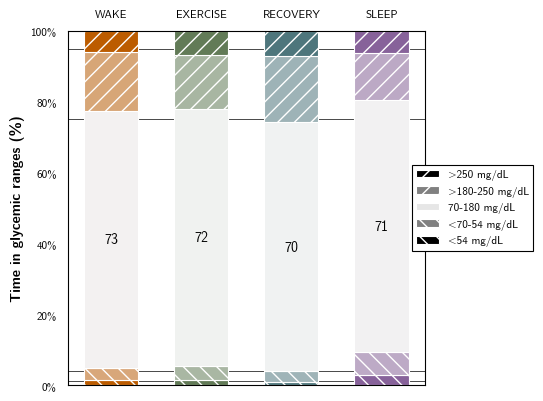

In [78]:
# TODO: now it is dominated by athletes that have the most data, 
# we should calculate it for riders individually and then average
fig, ax = plt.subplots(figsize=(4.6, 4.6))

# grid in plot
ax.axhline(1, color='k', linewidth=.5, zorder=1)
ax.axhline(4, color='k', linewidth=.5, zorder=1)
ax.axhline(75, color='k', linewidth=.5, zorder=1)
ax.axhline(95, color='k', linewidth=.5, zorder=1)

for k, sec in enumerate(SECTIONS):
    pil = get_percinlevel(dc[dc[sec]])
    plot_bar(pil, x=k, width=.6, colors=colors[k], plot_numbers='half')

plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
plt.ylim((0,100))
plt.ylabel('Time in glycemic ranges (%)', weight='bold')

ax.set_xticklabels([sec.upper() for sec in SECTIONS])

ax.xaxis.set_label_position('top')
#ax.xaxis.set_label_coords(0.4, 1.12)
ax.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=True)
sns.despine(ax=ax, bottom=False, right=False, top=False)

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.32, 0.5))
savefig('time_in_zone/time_in_glucoselevel')

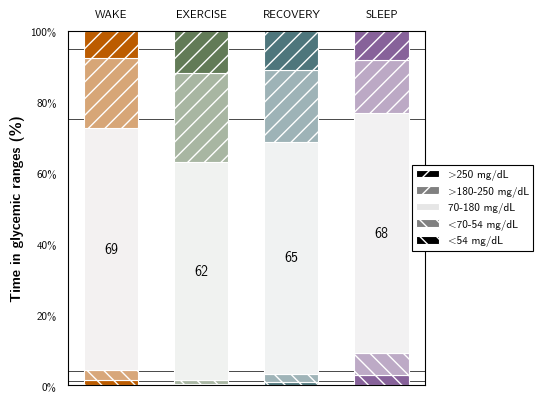

In [79]:
fig, ax = plt.subplots(figsize=(4.6, 4.6))

# grid in plot
ax.axhline(1, color='k', linewidth=.5, zorder=1)
ax.axhline(4, color='k', linewidth=.5, zorder=1)
ax.axhline(75, color='k', linewidth=.5, zorder=1)
ax.axhline(95, color='k', linewidth=.5, zorder=1)

for k, sec in enumerate(SECTIONS):
    pil = get_percinlevel(dc[dc[sec] & dc['race_day'] & dc['exercise_day']])
    plot_bar(pil, x=k, width=.6, colors=colors[k], plot_numbers='half')

plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
plt.ylim((0,100))
plt.ylabel('Time in glycemic ranges (%)', weight='bold')

ax.set_xticklabels([sec.upper() for sec in SECTIONS])

ax.xaxis.set_label_position('top')
#ax.xaxis.set_label_coords(0.4, 1.12)
ax.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=True)
sns.despine(ax=ax, bottom=False, right=False, top=False)

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.32, 0.5))
savefig('time_in_zone/time_in_glucoselevel_competition')

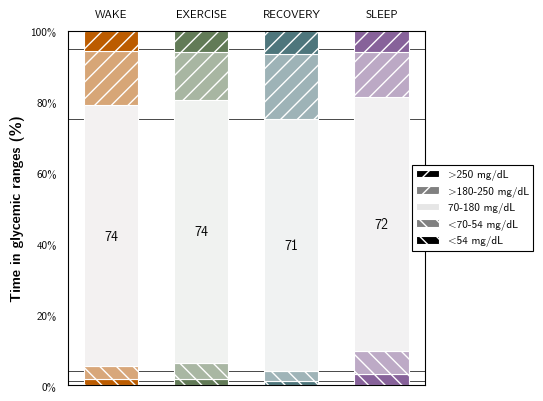

In [80]:
fig, ax = plt.subplots(figsize=(4.6, 4.6))

# grid in plot
ax.axhline(1, color='k', linewidth=.5, zorder=1)
ax.axhline(4, color='k', linewidth=.5, zorder=1)
ax.axhline(75, color='k', linewidth=.5, zorder=1)
ax.axhline(95, color='k', linewidth=.5, zorder=1)

for k, sec in enumerate(SECTIONS):
    pil = get_percinlevel(dc[dc[sec] & ~dc['race_day'] & dc['exercise_day']])
    plot_bar(pil, x=k, width=.6, colors=colors[k], plot_numbers='half')

plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
plt.ylim((0,100))
plt.ylabel('Time in glycemic ranges (%)', weight='bold')

ax.set_xticklabels([sec.upper() for sec in SECTIONS])

ax.xaxis.set_label_position('top')
#ax.xaxis.set_label_coords(0.4, 1.12)
ax.tick_params(axis='both', which='major', labelbottom = False, bottom=False, top=False, labeltop=True)
sns.despine(ax=ax, bottom=False, right=False, top=False)

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.32, 0.5))
savefig('time_in_zone/time_in_glucoselevel_training')

Individual athletes, hue: stages

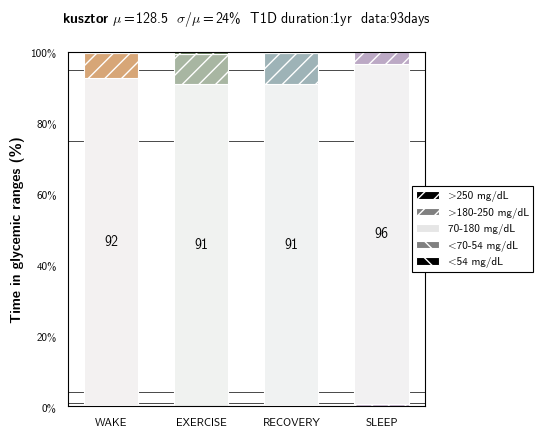

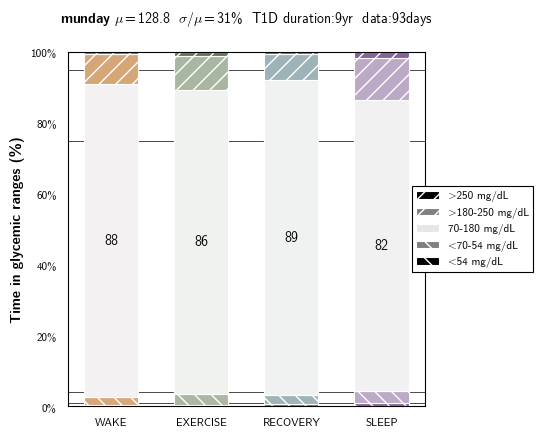

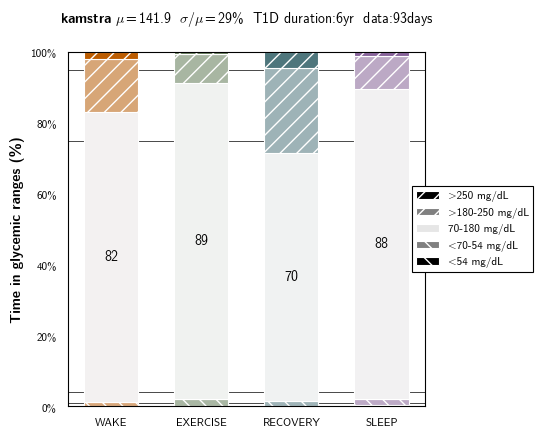

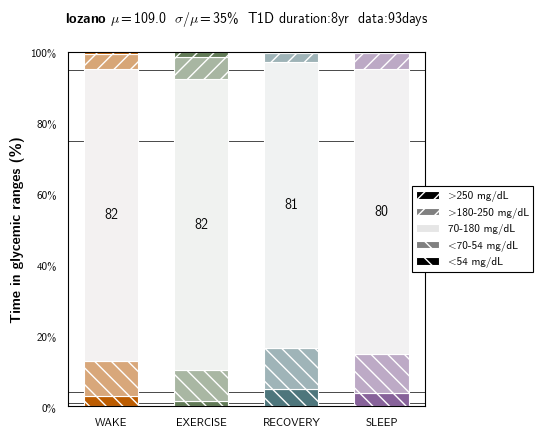

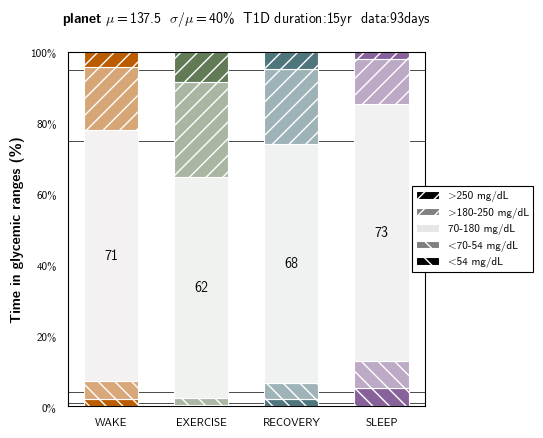

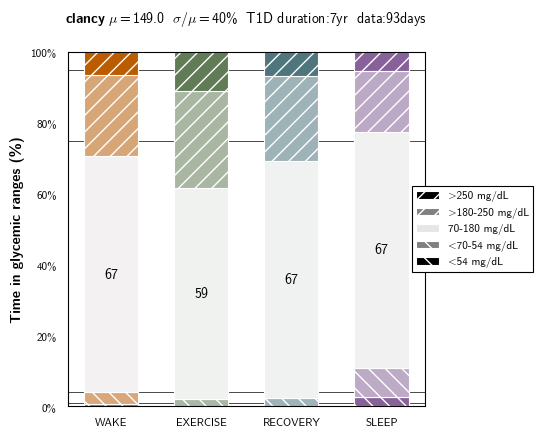

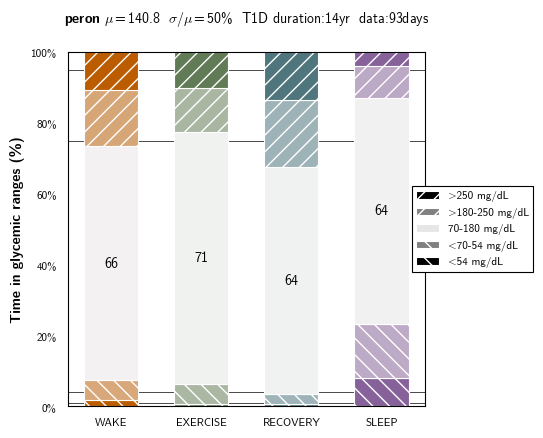

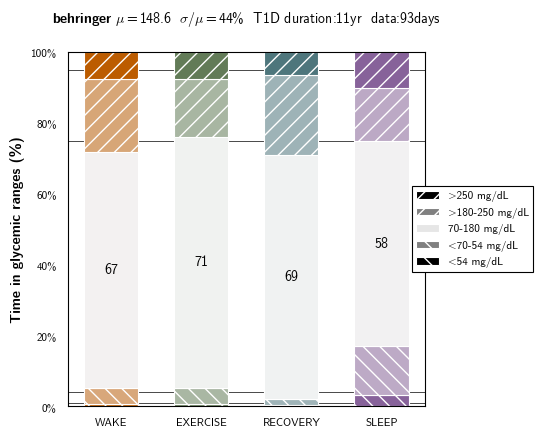

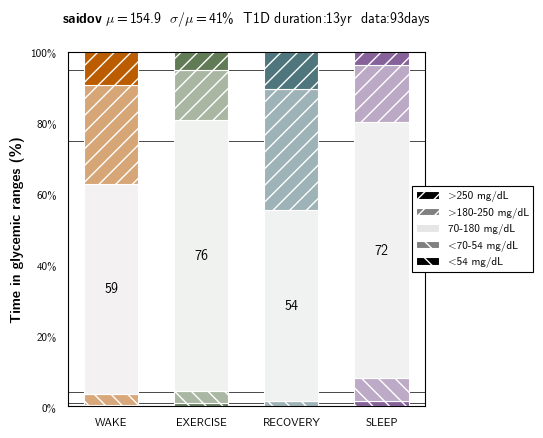

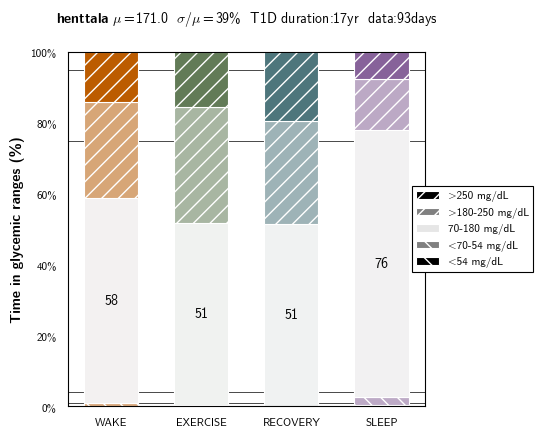

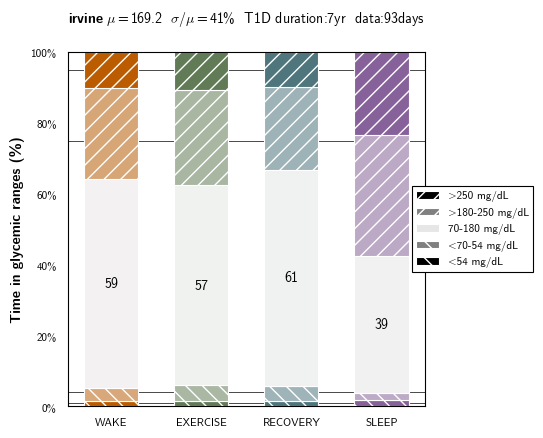

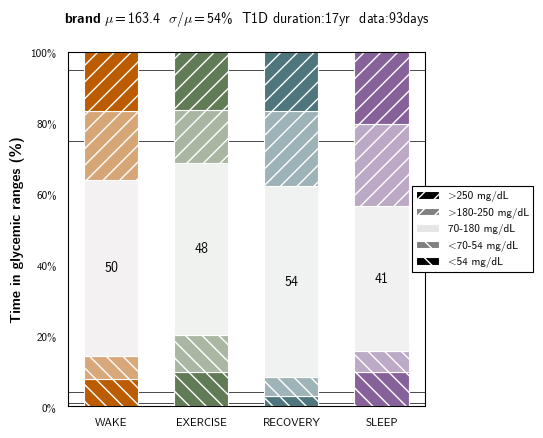

In [81]:
# TODO: check if calculation of perc_in_level is now correct!! (irvine looks weird!)
for i in ATHLETES:
    fig, ax = plt.subplots(figsize=(4.6, 4.6))

    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    for k, sec in enumerate(SECTIONS):
        pil = get_percinlevel(dc[dc[sec] & (dc.RIDER == i)])
        plot_bar(pil, x=k, colors=colors[k], width=.6, plot_numbers='half')

    plt.yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    plt.xticks(np.arange(len(SECTIONS)), SECTIONS)
    plt.ylim((0,100))
    plt.ylabel('Time in glycemic ranges (%)', weight='bold')

    ax.set_xticklabels([sec.upper() for sec in SECTIONS])

    ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.32, 0.5))
    sns.despine(ax=ax, bottom=False, right=False, top=False)
    ax.tick_params(axis='both', which='major', labelbottom=True, bottom=False, top=False, labeltop=False)

    title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
        .format(dc[dc.RIDER == i][COL].mean(),
                dc[dc.RIDER == i][COL].std()/dc[dc.RIDER == i][COL].mean()*100,
                info.loc[i, 'diabetes_duration'],
                len(dc_agg.loc[i]))
    savefig(path='time_in_zone/time_in_glucoselevel', i=i, title=title, y=1.06)

All, hue: athletes

In [82]:
colorful=False

In [83]:
if colorful:
    colors = [dict(zip(['h_neg', 'h_pos', 'l', 's'], [c[0]*360, c[0]*360, c[1]*100, c[2]*100])) \
                        for c in [rgb_to_hls(*j) for j in palette_ath]]
    kws = dict(ref_color = dict(h_neg=10, h_pos=10, s=0, l=50),
               ref_color_rgb = 'black',
               dur_color = 'black',
               dur_cmap = 'Greys')
else:
    colors = [dict(zip(['h_neg', 'h_pos', 'l', 's'], [c[0]*360, c[0]*360, c[1]*100, c[2]*100])) \
                        for c in [rgb_to_hls(*j) for j in len(palette_ath)*[(0, 0, 0)]]]
    kws = dict(ref_color = dict(h_pos=360, h_neg=360, l=50, s=80),
               ref_color_rgb = sns.diverging_palette(h_pos=360, h_neg=360, l=50, s=80, n=5)[0],
               dur_color = sns.diverging_palette(h_pos=90, h_neg=90, l=50, s=80, n=5)[0],
               dur_cmap = sns.light_palette((90/360, 50/360, 80/100), input='hls', as_cmap=True))

In [84]:
def plot_bar_reference(ax, n, colors=dict(h_neg=10, h_pos=10, s=0, l=50), text=True):
    ax.plot((n+1-0.2, n+1-0.2), (0, 110), color='black', clip_on=False)
    plot_bar({'hypo L2':1.2, 'hypo L1':3.2, 'target':70.2, 'hyper L1':20.2, 'hyper L2':5.2}, 
             x=n+1.5, width=.7, plot_numbers='full', ax=ax, labelsize=8, colors=colors)
    ax.annotate('3', xy=(n+1.5, 2.5), xytext=(n+2, 5), ha='left', arrowprops=dict(arrowstyle="-", color='black'), fontsize=8)
    ax.annotate('1', xy=(n+1.5, 0.5), xytext=(n+2, 0.5), ha='left', arrowprops=dict(arrowstyle="-", color='black'), fontsize=8)
    if text:
        ax.text(n+1, 104, 'Battelino et al. (2019)', ha='left', fontsize=8, color=sns.diverging_palette(**colors, n=5)[0])

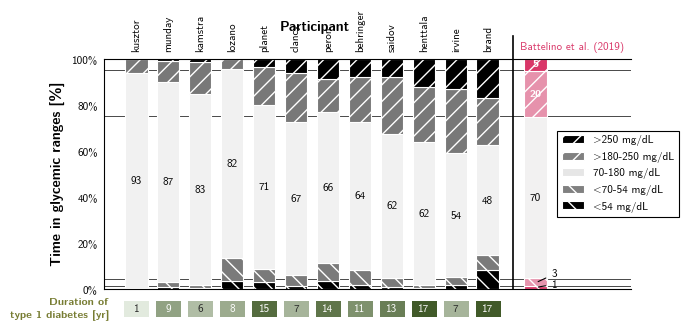

In [85]:
fig, (ax, ax0) = plt.subplots(2,1, figsize=(6.8,3.4), gridspec_kw={'height_ratios':[10,1], 'hspace': 0.07})

# grid in plot
ax.axhline(1, color='k', linewidth=.5, zorder=1)
ax.axhline(4, color='k', linewidth=.5, zorder=1)
ax.axhline(75, color='k', linewidth=.5, zorder=1)
ax.axhline(95, color='k', linewidth=.5, zorder=1)

# plot bars
for n, i in enumerate(ATHLETES):
    pil = get_percinlevel(dc[dc.RIDER == i])
    plot_bar(pil, x=n, width=.7, colors=colors[n], #duration=info['diabetes_duration'][i], 
             ax=ax, plot_numbers='half', labelsize=8)

# plot reference
plot_bar_reference(ax, n, colors=kws['ref_color'])
    
# ticks and axes
ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
ax.set_xticks(np.arange(len(ATHLETES)), ATHLETES)
ax.set_xlim((-1, 15.5))
ax.set_ylim((0,100))
ax.set_ylabel('Time in glycemic ranges [%]', weight='bold')
ax.set_xlabel('Participant', weight='bold')
ax.xaxis.set_label_position('top')
ax.xaxis.set_label_coords(0.4, 1.12)
ax.tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)

if colorful:
    for n, i in enumerate(ATHLETES):
        ax.get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
sns.despine(ax=ax, bottom=False, right=True, top=False)

# diabetes duration on bottom
sns.heatmap(info['diabetes_duration'].to_frame().T, ax=ax0, xticklabels=False, yticklabels=False,
            annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
ax0.set_xlim((-0.5, 16))
ax0.set_xlabel(None)
ax0.text(-1.3, 0.3, 'Duration of', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
ax0.text(-1.9, 0.9, 'type 1 diabetes [yr]', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

savefig('time_in_zone/time_in_glucoselevel_riders', xticks=ax)

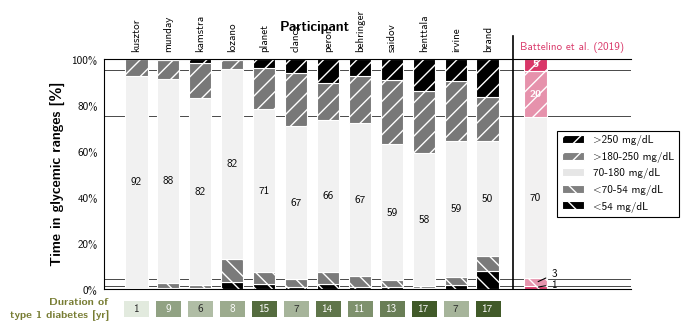

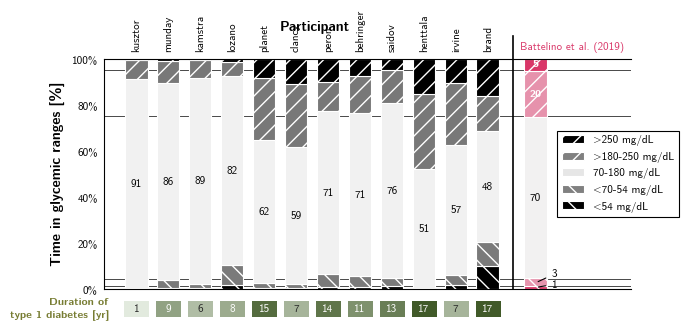

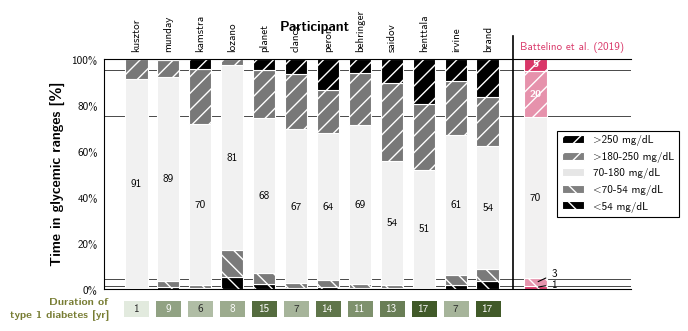

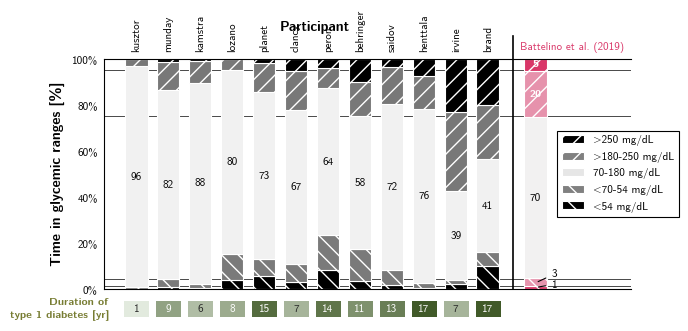

In [86]:
for sec in SECTIONS:
    fig, (ax, ax0) = plt.subplots(2,1, figsize=(6.8,3.4), gridspec_kw={'height_ratios':[10,1], 'hspace': 0.07})

    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    # plot bars
    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & dc[sec]])
        plot_bar(pil, x=n, width=.7, colors=colors[n], #duration=info['diabetes_duration'][i], 
                 ax=ax, plot_numbers='half', labelsize=8)

    # plot reference
    plot_bar_reference(ax, n, colors=kws['ref_color'])
    
    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    ax.set_xticks(np.arange(len(ATHLETES)), ATHLETES)
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges [%]', weight='bold')
    ax.set_xlabel('Participant', weight='bold')
    ax.xaxis.set_label_position('top')
    ax.xaxis.set_label_coords(0.4, 1.12)
    ax.tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)

    for n, i in enumerate(ATHLETES):
        ax.get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

    ax.legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
    sns.despine(ax=ax, bottom=False, right=True, top=False)

    # diabetes duration on bottom
    sns.heatmap(info['diabetes_duration'].to_frame().T, ax=ax0, xticklabels=False, yticklabels=False,
                annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
    ax0.set_xlim((-0.5, 16))
    ax0.set_xlabel(None)
    ax0.text(-1.3, 0.3, 'Duration of', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
    ax0.text(-1.9, 0.9, 'type 1 diabetes [yr]', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

    #ax0.text(n/2, 2, sec.upper())
    
    savefig('time_in_zone/time_in_glucoselevel_riders_%s'%sec, xticks=ax)

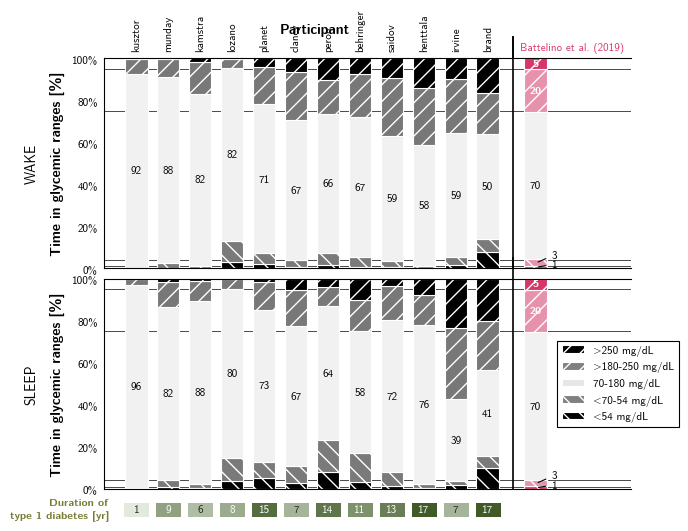

In [87]:
fig, axs = plt.subplots(3,1, figsize=(6.8,6), gridspec_kw={'height_ratios':[10, 10,1], 'hspace': 0.07})

for ax, sec in zip(axs[:2], ('wake', 'sleep')):
    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    # plot bars
    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & dc[sec]])
        plot_bar(pil, x=n, width=.7, colors=colors[n], ax=ax, plot_numbers='half', labelsize=8)

    # plot reference
    plot_bar_reference(ax, n, colors=kws['ref_color'], text=False)

    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges [%]', weight='bold')

    ax.text(-3.5, 50, sec.upper(), rotation=90, va='center')

axs[0].plot((n+1-0.2, n+1-0.2), (100, 110), color='black', clip_on=False)

# reference
axs[0].text(n+1, 104, 'Battelino et al. (2019)', ha='left', fontsize=8, color=kws['ref_color_rgb'])

# ticks
axs[0].set_xticks(np.arange(len(ATHLETES)), ATHLETES)
axs[0].set_xlabel('Participant', weight='bold')
axs[0].xaxis.set_label_position('top')
axs[0].xaxis.set_label_coords(0.4, 1.12)
axs[0].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)
axs[1].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=False, pad=0)

for n, i in enumerate(ATHLETES):
    axs[0].get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

axs[1].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
sns.despine(ax=axs[0], bottom=False, right=True, top=False)
sns.despine(ax=axs[1], bottom=False, right=True, top=False)

# diabetes duration on bottom
sns.heatmap(info['diabetes_duration'].to_frame().T, ax=axs[2], xticklabels=False, yticklabels=False,
            annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
axs[2].set_xlim((-0.5, 16))
axs[2].set_xlabel(None)
axs[2].text(-1.3, 0.3, 'Duration of', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
axs[2].text(-1.9, 0.9, 'type 1 diabetes [yr]', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

savefig('time_in_zone/time_in_glucoselevel_riders_daynight', xticks=axs[0])

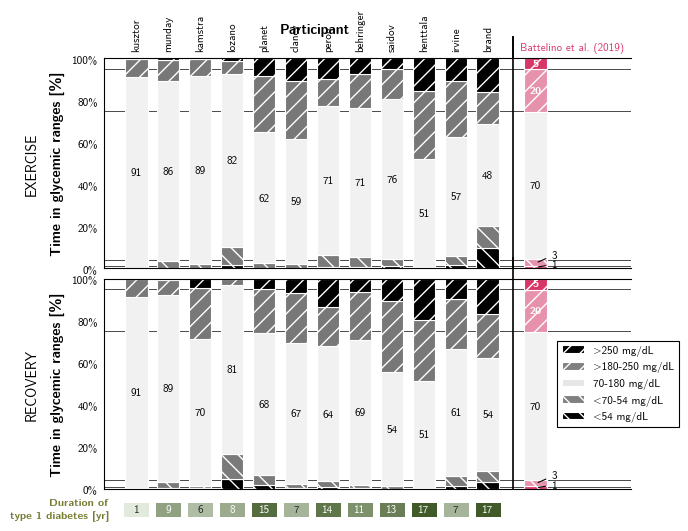

In [88]:
fig, axs = plt.subplots(3,1, figsize=(6.8,6), gridspec_kw={'height_ratios':[10, 10,1], 'hspace': 0.07})

for ax, sec in zip(axs[:2], ('exercise', 'recovery')):
    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    # plot bars
    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & dc[sec]])
        plot_bar(pil, x=n, width=.7, colors=colors[n], ax=ax, plot_numbers='half', labelsize=8)

    # plot reference
    plot_bar_reference(ax, n, colors=kws['ref_color'], text=False)

    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges [%]', weight='bold')

    ax.text(-3.5, 50, sec.upper(), rotation=90, va='center')

axs[0].plot((n+1-0.2, n+1-0.2), (100, 110), color='black', clip_on=False)

# reference
axs[0].text(n+1, 104, 'Battelino et al. (2019)', ha='left', fontsize=8, color=kws['ref_color_rgb'])

# ticks
axs[0].set_xticks(np.arange(len(ATHLETES)), ATHLETES)
axs[0].set_xlabel('Participant', weight='bold')
axs[0].xaxis.set_label_position('top')
axs[0].xaxis.set_label_coords(0.4, 1.12)
axs[0].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)
axs[1].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=False, pad=0)

for n, i in enumerate(ATHLETES):
    axs[0].get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

axs[1].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
sns.despine(ax=axs[0], bottom=False, right=True, top=False)
sns.despine(ax=axs[1], bottom=False, right=True, top=False)

# diabetes duration on bottom
sns.heatmap(info['diabetes_duration'].to_frame().T, ax=axs[2], xticklabels=False, yticklabels=False,
            annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
axs[2].set_xlim((-0.5, 16))
axs[2].set_xlabel(None)
axs[2].text(-1.3, 0.3, 'Duration of', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
axs[2].text(-1.9, 0.9, 'type 1 diabetes [yr]', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

savefig('time_in_zone/time_in_glucoselevel_riders_exerciserecovery', xticks=axs[0])

/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  
/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in long_scalars
  


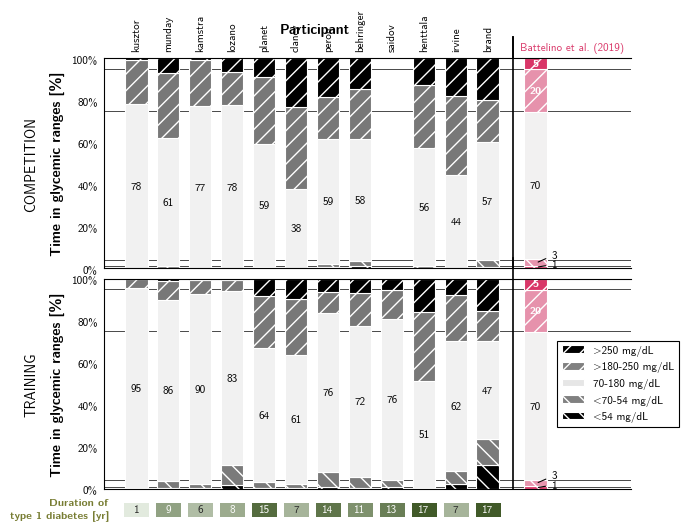

In [89]:
fig, axs = plt.subplots(3,1, figsize=(6.8,6), gridspec_kw={'height_ratios':[10, 10,1], 'hspace': 0.07})
MASK = {'competition': dc['race_day'] & dc['exercise'],
        'training'   : ~dc['race_day'] & dc['exercise']}
for ax, (sec, mask) in zip(axs[:2], MASK.items()):
    # grid in plot
    ax.axhline(1, color='k', linewidth=.5, zorder=1)
    ax.axhline(4, color='k', linewidth=.5, zorder=1)
    ax.axhline(75, color='k', linewidth=.5, zorder=1)
    ax.axhline(95, color='k', linewidth=.5, zorder=1)

    for n, i in enumerate(ATHLETES):
        pil = get_percinlevel(dc[(dc.RIDER == i) & mask])
        plot_bar(pil, ax=ax, x=n, width=.7, colors=colors[n], plot_numbers='half', labelsize=8)
    
    # plot reference
    plot_bar_reference(ax, n, colors=kws['ref_color'], text=False)

    # ticks and axes
    ax.set_yticks(np.arange(0, 101, 20), ['{}%'.format(j) for j in np.arange(0, 101, 20)])
    ax.set_xlim((-1, 15.5))
    ax.set_ylim((0,100))
    ax.set_ylabel('Time in glycemic ranges [%]', weight='bold')
        
    ax.text(-3.5, 50, sec.upper(), rotation=90, va='center')

axs[0].plot((n+1-0.2, n+1-0.2), (100, 110), color='black', clip_on=False)
 
# reference
axs[0].text(n+1, 104, 'Battelino et al. (2019)', ha='left', fontsize=8, color=kws['ref_color_rgb'])

# ticks
axs[0].set_xticks(np.arange(len(ATHLETES)), ATHLETES)
axs[0].set_xlabel('Participant', weight='bold')
axs[0].xaxis.set_label_position('top')
axs[0].xaxis.set_label_coords(0.4, 1.12)
axs[0].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True, pad=0)
axs[1].tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=False, pad=0)

for n, i in enumerate(ATHLETES):
    axs[0].get_xticklabels()[n].set_color(sns.diverging_palette(**colors[n], n=1)[0]) 

axs[1].legend(handles=legend_elements, loc='center right', bbox_to_anchor=(1.1, 0.5))
sns.despine(ax=axs[0], bottom=False, right=True, top=False)
sns.despine(ax=axs[1], bottom=False, right=True, top=False)

# diabetes duration on bottom
sns.heatmap(info['diabetes_duration'].to_frame().T, ax=axs[2], xticklabels=False, yticklabels=False,
            annot=True, cbar=False, cmap=kws['dur_cmap'], linewidths=5, vmin=0, vmax=20, annot_kws={"fontsize":8})
axs[2].set_xlim((-0.5, 16))
axs[2].set_xlabel(None)
axs[2].text(-1.3, 0.3, 'Duration of', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])
axs[2].text(-1.9, 0.9, 'type 1 diabetes [yr]', ha='center', fontsize=8, fontweight='bold', color=kws['dur_color'])

savefig('time_in_zone/time_in_glucoselevel_riders_competitiontrain', xticks=axs[0])

**CONCLUSION** : Large differences among athletes

### Competition vs. training

### Glucose distribution (boxplots)

In [90]:
kws_box = {'race':	dict(boxprops=dict(color='w', facecolor=color_race['race'], hatch='\\\\\\'),
						 medianprops=dict(color='w', linewidth=2),
						 whiskerprops=dict(color=color_race['race']), capprops=dict(color=color_race['race'])),
		   'train':dict(boxprops=dict(color='w', facecolor=color_race['train'], hatch='///'),
						 medianprops=dict(color='w', linewidth=2),
						 whiskerprops=dict(color=color_race['train']), capprops=dict(color=color_race['train']))}

All, stratify: sections

In [91]:
for _, l in list(glucose_levels.items())[1:]:
    print(l)

(54, 69.99999999)
(70, 180)
(180.00000001, 250)
(250.00000001, 10000)


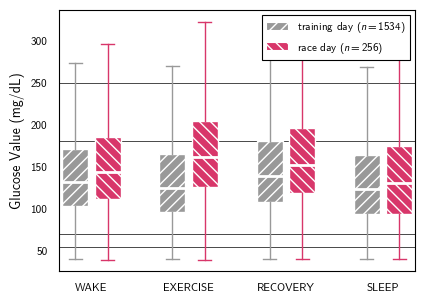

In [92]:
n_nc = len(dc.loc[~dc['race_day_6h'] & dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates())
n_rc = len(dc.loc[dc['race_day_6h'] & dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates())

fig, ax = plt.subplots()

# grid in plot
for _, l in list(glucose_levels.items())[1:]:
    ax.axhline(l[0], color='k', linewidth=.5, zorder=1)
    
for k, sec in enumerate(SECTIONS):
	plt.boxplot(dc.loc[dc[sec] & ~dc['race_day_6h'] & dc['exercise_day_6h'], COL], positions=[k+0.5+k*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['train'])
	plt.boxplot(dc.loc[dc[sec] & dc['race_day_6h'] & dc['exercise_day_6h'], COL], positions=[k+1.5+k*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['race'])
plt.xticks([1,4,7,10], SECTIONS)
plt.ylabel(COL)
plt.legend(handles=[Patch(facecolor=color_race['train'], edgecolor='white', hatch='///', label='training day'+r' ($n = {:.0f}$)'.format(n_nc)),
					Patch(facecolor=color_race['race'], edgecolor='white', hatch='\\\\\\', label='race day'r' ($n = {:.0f}$)'.format(n_rc))], 
			loc='upper right')
ax.set_xticklabels([sec.upper() for sec in SECTIONS])
savefig('boxplot/box_glucose_sections')

Individual athletes, stratify: sections

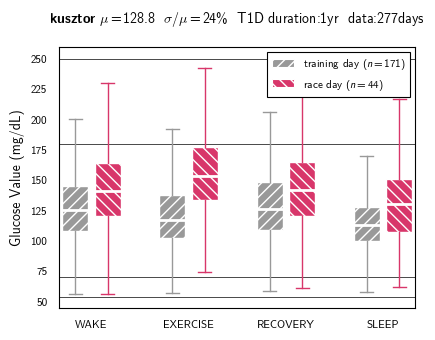

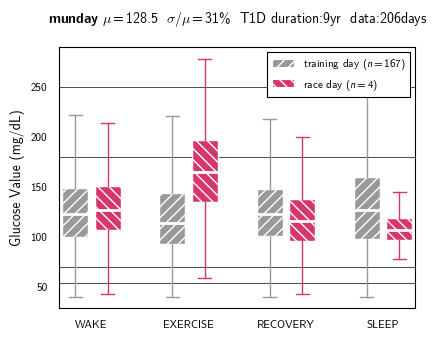

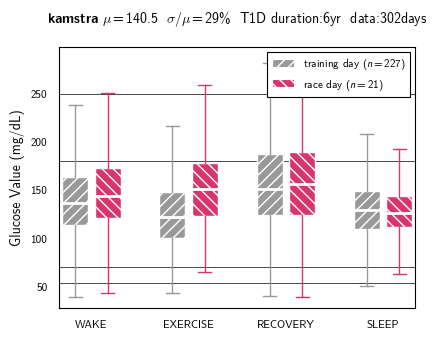

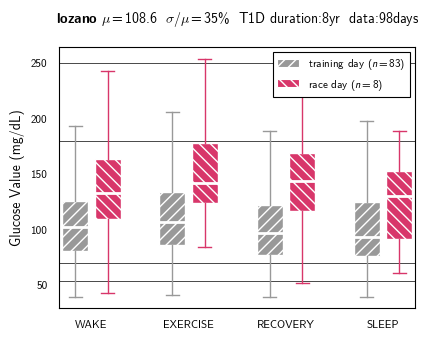

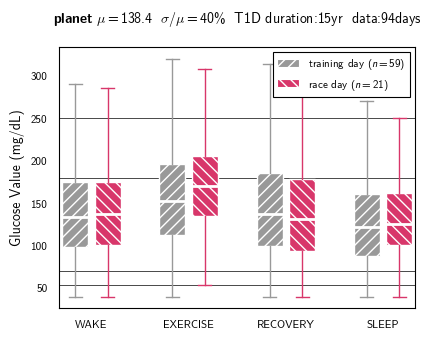

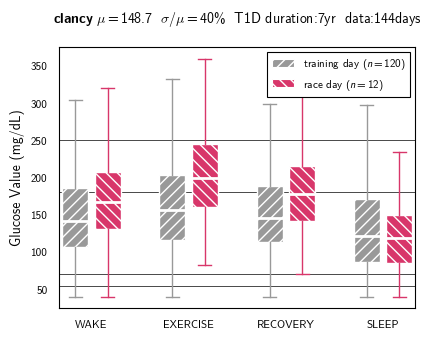

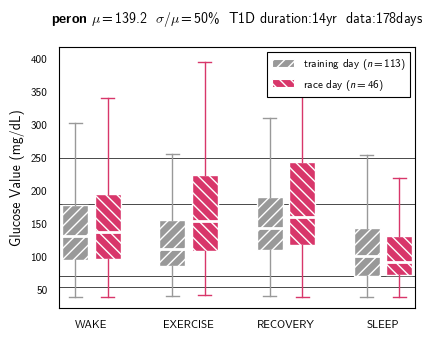

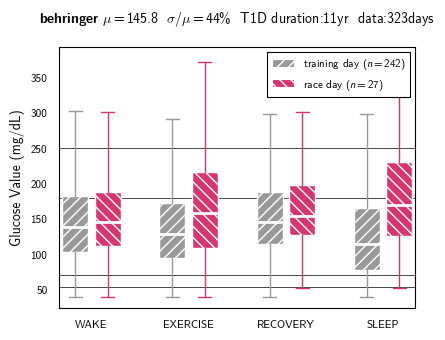

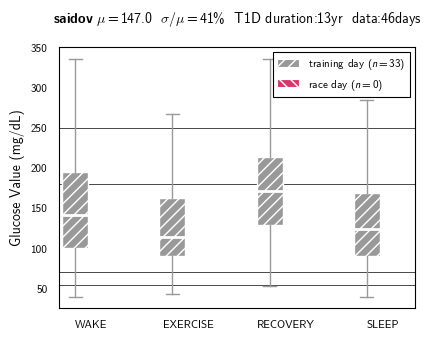

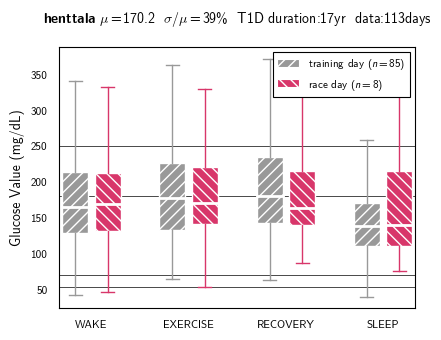

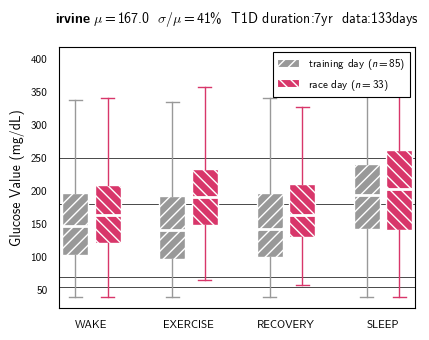

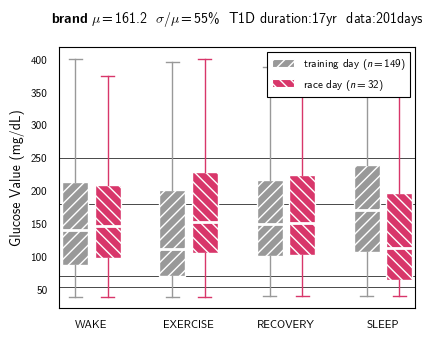

In [93]:
for i in ATHLETES:
    n_nc = len(dc.loc[(dc.RIDER == i) & ~dc['race_day_6h'] & dc['exercise_day_6h'], 'date_6h'].unique())
    n_rc = len(dc.loc[(dc.RIDER == i) & dc['race_day_6h'] & dc['exercise_day_6h'], 'date_6h'].unique())

    fig, ax = plt.subplots()

    # grid in plot
    for _, l in list(glucose_levels.items())[1:]:
        ax.axhline(l[0], color='k', linewidth=.5, zorder=1)

    for k, sec in enumerate(SECTIONS):
        plt.boxplot(dc.loc[(dc.RIDER == i) & dc[sec] & ~dc['race_day_6h'] & dc['exercise_day_6h'], COL], positions=[k+0.5+k*2], widths=[0.8],
            patch_artist=True, showfliers=False, **kws_box['train'])
        plt.boxplot(dc.loc[(dc.RIDER == i) & dc[sec] & dc['race_day_6h'] & dc['exercise_day_6h'], COL], positions=[k+1.5+k*2], widths=[0.8],
            patch_artist=True, showfliers=False, **kws_box['race'])
    plt.xticks([1,4,7,10], SECTIONS)
    plt.ylabel(COL)
    plt.legend(handles=[Patch(facecolor=color_race['train'], edgecolor='white', hatch='///', label='training day'+r' ($n = {:.0f}$)'.format(n_nc)),
                        Patch(facecolor=color_race['race'], edgecolor='white', hatch='\\\\\\', label='race day'r' ($n = {:.0f}$)'.format(n_rc))], 
                loc='upper right')

    title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
        .format(dc[(dc.RIDER == i) & dc['exercise_day']][COL].mean(),
                dc[(dc.RIDER == i) & dc['exercise_day']][COL].std()/dc[(dc.RIDER == i) & dc['exercise_day']][COL].mean()*100,
                info.loc[i, 'diabetes_duration'],
                len(dc_agg[dc_agg.RIDER == i]))
    ax.set_xticklabels([sec.upper() for sec in SECTIONS])
    savefig(path='boxplot/box_glucose_sections', i=i, title=title, y=1.06)

All, stratify: athletes

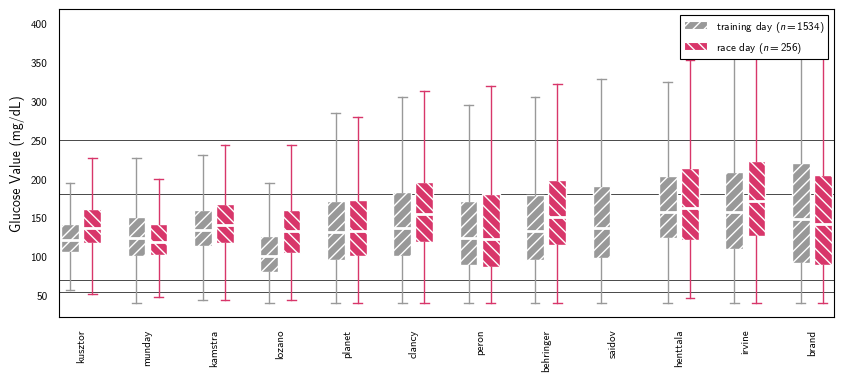

In [94]:
n_nc = len(dc.loc[~dc['race_day_6h'] & dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates())
n_rc = len(dc.loc[dc['race_day_6h'] & dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates())

# hue: athlete
fig, ax = plt.subplots(figsize=(10,4))

# grid in plot
for _, l in list(glucose_levels.items())[1:]:
    ax.axhline(l[0], color='k', linewidth=.5, zorder=1)

for n, i in enumerate(ATHLETES):
	plt.boxplot(dc.loc[(dc.RIDER == i) & ~dc['race_day_6h'] & dc['exercise_day_6h'], COL], positions=[n+0.5+n*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['train'])
	plt.boxplot(dc.loc[(dc.RIDER == i) & dc['race_day_6h'] & dc['exercise_day_6h'], COL], positions=[n+1.5+n*2], widths=[0.8],
		patch_artist=True, showfliers=False, **kws_box['race'])
plt.ylabel(COL)
plt.legend(handles=[Patch(facecolor=color_race['train'], edgecolor='white', hatch='///', label='training day'+r' ($n = {:.0f}$)'.format(n_nc)),
					Patch(facecolor=color_race['race'], edgecolor='white', hatch='\\\\\\', label='race day'r' ($n = {:.0f}$)'.format(n_rc))], 
			loc='upper right')
plt.xticks(np.arange(1, len(ATHLETES)*3,3), ATHLETES)

savefig('boxplot/box_glucose_riders', xticks=ax)

### Stats

**Stats for patient population**

In [95]:
info['bmi'] = info['weight'] / (info['height']/100)**2

In [96]:
# ------ info
cols_info = {'age'    : 'Age [yr]',
             'gender' : 'Sex [male/female]',
             'height' : 'Height [cm]',
             'weight' : 'Weight [kg]',
             'bf(%)'  : 'Fat mass [\%]'}

info['FTP_per_kg'] = info['FTP'] / info['weight']
info = info.drop('FTP', axis=1)

stats_info = info.loc[:,info.columns.isin(cols_info.keys())]
stats_info = stats_info.rename(columns=cols_info)

In [97]:
# ------ diabetes
cols_diab = {'diabetes_duration' : 'Diabetes duration [yr]',
             'HbA1c'             : 'HbA_{1c} [\%]',
             'cgm_days'          : 'Days with CGM coverage $\geq$ 70 \%'}

stats_diab = info.loc[:, info.columns.isin(cols_diab.keys())]
stats_diab['cgm_days'] = dc_agg.reset_index().groupby('RIDER')['date'].count()
stats_diab = stats_diab.rename(columns=cols_diab)

/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [98]:
# ------ exercise
cols_ex = {'FTP_per_kg'                : 'Functional threshold power [W/kg]',
           'LTHR'                      : 'Lactate threshold heart rate [bpm]',
           'HRmax'                     : 'HR_{max} [bpm]',
           'VO2max'                    : 'VO_{2max} [mL/min/kg]',
           'days_per_year_cycled'      : 'Cycling [days/yr]',
           'days_per_year_raced'       : 'Competition [days/yr]',
           'km_per_year_cycled'        : 'Distance cycled [km/yr]',
           'mean_hours_per_day_cycled' : 'Mean time cycled [h/day]',
           'mean_km_per_day_cycled'    : 'Mean distance cycled [km/day]',
           'mean_m_per_day_ascended'   : 'Mean ascension [m/day]'}

tp_agg0 = tp_agg.set_index(['RIDER', 'date'])
tp_agg0.columns = tp_agg0.columns.get_level_values(1)
tp_agg0 = tp_agg0.reset_index()

stats_ex_yr = tp_agg0.groupby('RIDER').agg({'date'        :'count', 
                                            'race'        :'sum', 
                                            'distance_max':lambda x: x.sum()/1000})\
                           .rename(columns={'date'        :'days_per_year_cycled',
                                            'race'        :'days_per_year_raced',
                                            'distance_max':'km_per_year_cycled'})

stats_ex_day = tp_agg0.groupby('RIDER').agg({'timestamp_count'      :lambda x: x.mean()/3600,
                                             'distance_max'         :lambda x: x.mean()/1000,
                                             'elevation_gain_up_sum':'mean'})\
    .rename(columns={'timestamp_count'      :'mean_hours_per_day_cycled',
                     'distance_max'         :'mean_km_per_day_cycled',
                     'elevation_gain_up_sum':'mean_m_per_day_ascended'})

stats_ex = info[sorted(set(cols_ex.keys()) & set(info.columns))]
stats_ex = pd.merge(stats_ex, stats_ex_yr, left_index=True, right_index=True, how='outer')
stats_ex = pd.merge(stats_ex, stats_ex_day, left_index=True, right_index=True, how='outer')
stats_ex = stats_ex.rename(columns=cols_ex)

In [99]:
stats = pd.concat([stats_info, stats_diab, stats_ex], axis=1)
stats

Sex [male/female]  Age [yr]  Weight [kg]  Fat mass [\%]  Height [cm]  \
RIDER                                                                        
1                     M        34    60.333333       4.866667        179.0   
2                     M        20    56.700000       4.950000        169.0   
3                     M        25    69.633333       7.700000        183.0   
4                     M        30    64.000000       5.600000        178.0   
5                     M        25    73.766667       7.200000        179.0   
6                     M        26    66.733333       6.566667        171.0   
7                     M        30    71.633333       8.833333        178.0   
8                     M        22    60.500000       9.066667        174.0   
9                     M        22    56.666667       9.466667        170.0   
10                    M        27    75.166667       9.333333        187.0   
11                    M        19    78.666667       9.433333        178.0   
12                    M        27    75.466667       7.700000        185.0   

       Diabetes duration [yr]  HbA_{1c} [\%]  \
RIDER                                          
1                           1       6.366667   
2                           9       6.550000   
3                           6       6.725000   
4                           8       5.950000   
5                          15       6.525000   
6                           7       6.850000   
7                          14       6.533333   
8                          11       6.333333   
9                          13       6.825000   
10                         17       6.925000   
11                          7       8.000000   
12                         17       7.233333   

       Days with CGM coverage $\geq$ 70 \%  Functional threshold power [W/kg]  \
RIDER                                                                           
1                                      277                           5.729282   
2                                      206                           5.264550   
3                                      302                           4.897080   
4                                       98                           5.421875   
5                                       94                           5.273385   
6                                      144                           4.465534   
7                                      178                           4.550954   
8                                      323                           5.074380   
9                                       46                           5.000000   
10                                     113                           4.629712   
11                                     133                           4.525424   
12                                     201                           5.000000   

       HR_{max} [bpm]  Lactate threshold heart rate [bpm]  \
RIDER                                                       
1          182.333333                          173.000000   
2          184.500000                          173.000000   
3          192.666667                          179.666667   
4          178.666667                          158.333333   
5          198.000000                          185.000000   
6          180.000000                          171.000000   
7          181.666667                          168.666667   
8          192.333333                          176.333333   
9          200.333333                          125.610000   
10         189.500000                          169.000000   
11         187.333333                          170.333333   
12         194.333333                          177.000000   

       VO_{2max} [mL/min/kg]  Cycling [days/yr]  Competition [days/yr]  \
RIDER                                                                    
1                  76.666667                233                     46   
2                  70.781588

Calculate mean and std over all riders and write to latex

In [100]:
def agg_gender(x):
    count = x.value_counts()
    male = count['M'] if 'M' in count else 0
    female = count['F'] if 'F' in count else 0
    return f'{male}/{female}'

In [101]:
stats_agg = pd.concat([stats.median(), stats.quantile(0.25), stats.quantile(0.75)], axis=1).round(1)
stats_agg = pd.concat([pd.Series(stats['Sex [male/female]'].agg(agg_gender), index=['Sex [male/female]']),
                       stats_agg])

stats_agg = stats_agg.rename(columns={0.00:'median', 0.25:'p25', 0.75:'p75'})
stats_agg.apply(lambda x: pd.Series([x['median'], f"[{x['p25']}--{x['p75']}]"]), axis=1).to_csv(SAVE_PATH+"stats.csv")
stats_agg

median      p25      p75
Sex [male/female]                       12/0      NaN      NaN
Age [yr]                                25.5     22.0     27.8
Weight [kg]                             68.2     60.5     74.1
Fat mass [\%]                            7.7      6.3      9.1
Height [cm]                            178.0    173.2    180.0
Diabetes duration [yr]                  10.0      7.0     14.2
HbA_{1c} [\%]                            6.6      6.5      6.9
Days with CGM coverage $\geq$ 70 \%    161.0    109.2    223.8
Functional threshold power [W/kg]        5.0      4.6      5.3
HR_{max} [bpm]                         188.4    182.2    193.1
Lactate threshold heart rate [bpm]     172.0    168.9    176.5
VO_{2max} [mL/min/kg]                   69.8     66.9     74.2
Cycling [days/yr]                      288.5    254.0    300.5
Competition [days/yr]                   36.0     23.0     47.2
Distance cycled [km/yr]              25042.6  22698.8  29268.4
Mean time cycled [h/day]                 3.1      3.0      3.3
Mean distance cycled [km/day]           97.1     89.3    103.2
Mean ascension [m/day]                1229.9   1123.2   1317.5

In [102]:
stats_agg = stats_agg.apply(lambda x: f"{x['median']} & [{x['p25']} & {x['p75']}]", axis=1)

with open(SAVE_PATH+"stats.tex", 'w') as file:
	file.write(stats_agg.to_latex(column_format='c', escape=False))

**Stats for CGM**

In [103]:
cols_cgm = {'glucose_mean'    : 'Mean glucose [mg/dL]',
            'glucose_cv'      : 'Glycemic variability [\%]',
            'time_in_hypo'    : 'hypoglycemia (<70 mg/dL)',
            'time_in_hypoL2'  : 'hypoglycemia L2 (<54 mg/dL)',
            'time_in_hypoL1'  : 'hypoglycemia L1 (54-69 mg/dL)',
            'time_in_target'  : 'target range (70-180 mg/dL)',
            'time_in_hyper'   : 'hyperglycemia (>180 mg/dL)',
            'time_in_hyperL1' : 'hyperglycemia L1 (181-250 mg/dL)',
            'time_in_hyperL2' : 'hyperglycemia L2 (>250 mg/dL)'}

In [104]:
# TODO: check if still in line with new value of glucose_levels
# calculate dysglycemia events
dc['hypo'] = dc.groupby('RIDER')[COL].transform(lambda x: (x <= glucose_levels['hypo L1'][1]) \
														& (x.shift(1) <= glucose_levels['hypo L1'][1]) \
														& (x.shift(2) <= glucose_levels['hypo L1'][1]))
dc['hyper'] = dc.groupby('RIDER')[COL].transform(lambda x: (x >= glucose_levels['hyper L1'][0]) \
														 & (x.shift(1) >= glucose_levels['hyper L1'][0]) \
														 & (x.shift(2) >= glucose_levels['hyper L1'][0]))

# glucose rate
dc['glucose_rate'] = dc[COL] / (dc['timestamp'].diff()/pd.to_timedelta('5min'))

In [105]:
stat_cols = ['Total', 'wake', 'exercise', 'recovery', 'sleep']

In [106]:
def get_stats_cgm(dc):
    stats = {'Total': dc.groupby('RIDER').apply(stat_func).apply(pd.Series)}
    stats.update({sec: dc[dc[sec]].groupby('RIDER').apply(stat_func).apply(pd.Series) for sec in SECTIONS})
    
    for k, df in stats.items():
        df.columns = df.columns.str.rstrip('_')
        cols_time = df.columns.str.startswith('time_in')
        df.loc[:, cols_time] = df.loc[:, cols_time].div(df['count'], axis=0) * 100 # calculate perc
        df['glucose_cv'] *= 100
        df = df[['glucose_mean', 'glucose_cv', 'time_in_hypoL2', 'time_in_hypoL1',
           'time_in_target', 'time_in_hyperL1', 'time_in_hyperL2']]
        stats[k] = df
    stats = pd.concat(stats, axis=1)
    
    stats = pd.concat([stats.median(), stats.quantile(0.25), stats.quantile(0.75)], axis=1)
    stats = stats.rename(columns={0.00:'median', 0.25:'p25', 0.75:'p75'})
    stats = stats.round(1)

    # some overly difficult way to get it to the right format
    stats.index = stats.index.swaplevel(0,1)
    stats = stats.unstack()
    stats.columns = stats.columns.swaplevel(0,1)
    
    stats = stats.rename(index=cols_cgm)
    stats = stats[stat_cols]
    
    return stats

In [107]:
def highlight_cell(stats, col, func):
    stats.loc[col, pd.IndexSlice[:,'median']] = stats.loc[col,pd.IndexSlice[:,'median']].applymap(func)
    return stats

In [108]:
days = {'all'   : dc,
        'race'  : dc[dc['exercise_day_6h'] & dc['race_day_6h']],
        'train' : dc[dc['exercise_day_6h'] & ~dc['race_day_6h']]}

In [109]:
tnames = {'all'  : r"All days (d={:.0f})".format(len(days['all'][['RIDER', 'date_6h']].drop_duplicates())),
          'race' : r"Competition days (d={:.0f})".format(len(days['race'][['RIDER', 'date_6h']].drop_duplicates())),
          'train': r"Training days (d={:.0f})".format(len(days['train'][['RIDER', 'date_6h']].drop_duplicates()))}

In [110]:
stats_cgm = {name: get_stats_cgm(df) for name, df in days.items()}

stats_cgm0 = pd.DataFrame(columns=stats_cgm['all'].columns)
for name, stats in stats_cgm.items():
    row = pd.DataFrame(np.nan, index=[tnames[name]], columns=stats_cgm['all'].columns)
    stats_cgm0 = pd.concat([stats_cgm0, row, stats])
stats_cgm = stats_cgm0
stats_cgm

Total                 wake                \
                                 median    p25    p75 median    p25    p75   
All days (d=2115)                   NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose [mg/dL]              145.3  135.3  157.0  150.4  138.3  160.7   
Glycemic variability [\%]          39.9   34.0   41.7   38.9   33.3   40.9   
hypoglycemia L2 (<54 mg/dL)         1.3    0.4    2.9    0.8    0.3    1.9   
hypoglycemia L1 (54-69 mg/dL)       4.2    2.2    6.4    3.5    1.9    5.2   
target range (70-180 mg/dL)        66.1   62.4   82.2   66.6   59.2   81.9   
hyperglycemia L1 (181-250 mg/dL)   17.9   12.6   22.2   18.7   13.4   23.7   
hyperglycemia L2 (>250 mg/dL)       7.0    1.4    9.7    6.9    1.4   10.0   
Competition days (d=256)            NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose [mg/dL]              143.6  139.4  160.3  153.3  142.7  166.1   
Glycemic variability [\%]          37.5   29.4   39.8   36.9   30.2   38.0   
hypoglycemia L2 (<54 mg/dL)         0.6    0.3    1.7    0.5    0.3    1.4   
hypoglycemia L1 (54-69 mg/dL)       2.4    1.4    4.1    2.2    0.9    3.9   
target range (70-180 mg/dL)        64.1   60.3   84.7   68.8   58.2   81.5   
hyperglycemia L1 (181-250 mg/dL)   18.1   12.8   24.4   18.7   15.3   25.0   
hyperglycemia L2 (>250 mg/dL)       6.9    1.2   11.8    6.0    1.6   11.7   
Training days (d=1534)              NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose [mg/dL]              141.8  135.6  151.1  146.6  138.2  151.9   
Glycemic variability [\%]          40.6   33.4   42.3   39.2   32.8   41.0   
hypoglycemia L2 (<54 mg/dL)         1.5    0.4    2.7    0.8    0.3    1.7   
hypoglycemia L1 (54-69 mg/dL)       4.8    2.2    6.8    4.3    2.0    5.1   
target range (70-180 mg/dL)        67.4   64.6   82.4   68.5   63.2   82.6   
hyperglycemia L1 (181-250 mg/dL)   16.9   11.6   21.2   18.4   12.3   22.6   
hyperglycemia L2 (>250 mg/dL)       5.7    1.4    8.5    6.1    1.4    8.5   

                                 exercise               recovery         \
                                   median    p25    p75   median    p25   
All days (d=2115)                     NaN    NaN    NaN      NaN    NaN   
Mean glucose [mg/dL]                143.6  130.4  163.0    157.3  141.8   
Glycemic variability [\%]            36.9   34.9   44.3     35.5   32.7   
hypoglycemia L2 (<54 mg/dL)           0.5    0.2    1.1      0.5    0.2   
hypoglycemia L1 (54-69 mg/dL)         3.4    2.0    4.9      2.3    1.4   
target range (70-180 mg/dL)          71.0   58.7   83.0     67.2   59.1   
hyperglycemia L1 (181-250 mg/dL)     14.5    9.3   26.8     21.9   16.1   
hyperglycemia L2 (>250 mg/dL)         7.9    1.3   10.6      6.5    3.2   
Competition days (d=256)              NaN    NaN    NaN      NaN    NaN   
Mean glucose [mg/dL]                170.6  160.3  178.0    164.3  144.4   
Glycemic variability [\%]            30.0   29.1   38.0     32.8   28.7   
hypoglycemia L2 (<54 mg/dL)           0.0    0.0    0.2      0.3    0.0   
hypoglycemia L1 (54-69 mg/dL)         0.5    0.1    1.5      1.6    0.8   
target range (70-180 mg/dL)          58.6   56.4   68.9     64.9   58.2   
hyperglycemia L1 (181-250 mg/dL)     23.6   20.3   31.3     20.8   15.3   
hyperglycemia L2 (>250 mg/dL)        12.0    7.0   18.0      7.7    1.9   
Training days (d=1534)                NaN    NaN    NaN      NaN    NaN   
Mean glucose [mg/dL]                137.5  125.6  151.4    154.6  142.9   
Glycemic variability [\%]            37.5   35.0   44.3     35.6   32.8   
hypoglycemia L2 (<54 mg/dL)           0.6    0.2    1.1      0.4    0.2   
hypoglycemia L1 (54-69 mg/dL)         3.4    2.2    6.3      2.3    1.4   
target range (70-180 mg/dL)          74.0   61.8   83.5     68.5   59.5   
hyperglycemia L1 (181-250 mg/dL)     14.1    8.4   22.7     22.2   16.4   
hyperglycemia L2 (>250 mg/dL)         6.6    0.9    8.6      6.1    3.4   

                                         sleep        

In [111]:
stats_cgm_csv = stats_cgm.T.groupby(level=0).apply(lambda x: x.T.apply(lambda x: pd.Series([x[pd.IndexSlice[:, 'median']].values[0], f"[{x[pd.IndexSlice[:, 'p25']].values[0]}--{x[pd.IndexSlice[:, 'p75']].values[0]}]"]), axis=1)).unstack(level=0)
stats_cgm_csv.columns = stats_cgm_csv.columns.swaplevel(0,1)
stats_cgm_csv = stats_cgm_csv.reindex(pd.MultiIndex.from_product([stat_cols, [0,1]]), axis=1)
stats_cgm_csv.to_csv(SAVE_PATH+"stats_cgm.csv")

In [112]:
#stats_cgm = highlight_cell(stats_cgm, 'Mean glucose (mg/dL)', lambda x: pd.DataFrame(False, index=x.index, columns=x.columns))
stats_cgm = highlight_cell(stats_cgm, 'Glycemic variability [\%]', lambda x: '\hl'+str(x) if x > 36 else x)
stats_cgm = highlight_cell(stats_cgm, 'hypoglycemia L2 (<54 mg/dL)', lambda x: '\hl'+str(x) if x > 1 else x)
stats_cgm = highlight_cell(stats_cgm, 'hypoglycemia L1 (54-69 mg/dL)', lambda x: '\hl'+str(x) if x > 3 else x)
stats_cgm = highlight_cell(stats_cgm, 'target range (70-180 mg/dL)', lambda x: '\hl'+str(x) if x < 70 else x)
stats_cgm = highlight_cell(stats_cgm, 'hyperglycemia L1 (181-250 mg/dL)', lambda x: '\hl'+str(x) if x > 20 else x)
stats_cgm = highlight_cell(stats_cgm, 'hyperglycemia L2 (>250 mg/dL)', lambda x: '\hl'+str(x) if x > 5 else x)

In [113]:
stats_cgm.index = pd.MultiIndex.from_arrays([8*['all']+8*['comp']+8*['train'], stats_cgm.index])
stats_cgm.columns = stats_cgm.columns.swaplevel(0,1)
stats_cgm = stats_cgm.stack(dropna=False)
#stats_cgm = stats_cgm.apply(lambda x: f"{x['median']} ({x['p25']} - {x['p75']})", axis=1)
stats_cgm = stats_cgm.apply(lambda x: f"{x['median']} & \hl[{x['p25']}--{x['p75']}]" if str(x['median']).startswith('\hl') else (f"{x['median']} & [{x['p25']}--{x['p75']}]" if x.isna().sum() != 3 else np.nan), axis=1)
stats_cgm = stats_cgm.unstack()
stats_cgm = stats_cgm.sort_index(key=lambda x: x.map({**{k:i for i, k in enumerate(tnames.keys())}, **{k:0 for k in tnames.values()}, **{k:i+1 for i, k in enumerate(cols_cgm.values())}}))
stats_cgm = stats_cgm[stat_cols]
stats_cgm = stats_cgm.rename(index={k: '\hspace{7mm}'+k for k in list(cols_cgm.values())[2:]})
stats_cgm = stats_cgm.reset_index().drop('level_0', axis=1).set_index('level_1')
with open(SAVE_PATH+"stats_cgm.tex", 'w') as file:
	file.write(stats_cgm.to_latex(column_format='lrrrrr', escape=False))

Combine L1 and L2

In [114]:
def get_stats_cgm2(dc):
    stats = {'Total': dc.groupby('RIDER').apply(stat_func).apply(pd.Series)}
    stats.update({sec: dc[dc[sec]].groupby('RIDER').apply(stat_func).apply(pd.Series) for sec in SECTIONS})
    
    for k, df in stats.items():
        df.columns = df.columns.str.rstrip('_')
        cols_time = df.columns.str.startswith('time_in')
        df.loc[:, cols_time] = df.loc[:, cols_time].div(df['count'], axis=0) * 100 # calculate perc
        df['glucose_cv'] *= 100
        df = df[['glucose_mean', 'glucose_cv', 'time_in_hypo', 'time_in_target', 'time_in_hyper', ]]
        stats[k] = df
    stats = pd.concat(stats, axis=1)
    
    stats = pd.concat([stats.median(), stats.quantile(0.25), stats.quantile(0.75)], axis=1)
    stats = stats.rename(columns={0.00:'median', 0.25:'p25', 0.75:'p75'})
    stats = stats.round(1)

    # some overly difficult way to get it to the right format
    stats.index = stats.index.swaplevel(0,1)
    stats = stats.unstack()
    stats.columns = stats.columns.swaplevel(0,1)
    
    stats = stats.rename(index=cols_cgm)
    stats = stats[stat_cols]
    
    return stats

In [115]:
stats_cgm = {name: get_stats_cgm2(df) for name, df in days.items()}
stats_cgm0 = pd.DataFrame(columns=stats_cgm['all'].columns)
for name, stats in stats_cgm.items():
    row = pd.DataFrame(np.nan, index=[tnames[name]], columns=stats_cgm['all'].columns)
    stats_cgm0 = pd.concat([stats_cgm0, row, stats])
stats_cgm = stats_cgm0
stats_cgm

Total                 wake                \
                            median    p25    p75 median    p25    p75   
All days (d=2115)              NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose [mg/dL]         145.3  135.3  157.0  150.4  138.3  160.7   
Glycemic variability [\%]     39.9   34.0   41.7   38.9   33.3   40.9   
hypoglycemia (<70 mg/dL)       5.3    2.6    9.2    4.6    2.3    7.2   
target range (70-180 mg/dL)   66.1   62.4   82.2   66.6   59.2   81.9   
hyperglycemia (>180 mg/dL)    25.3   14.1   33.8   27.3   14.9   35.8   
Competition days (d=256)       NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose [mg/dL]         143.6  139.4  160.3  153.3  142.7  166.1   
Glycemic variability [\%]     37.5   29.4   39.8   36.9   30.2   38.0   
hypoglycemia (<70 mg/dL)       2.5    2.0    5.8    3.0    1.3    5.0   
target range (70-180 mg/dL)   64.1   60.3   84.7   68.8   58.2   81.5   
hyperglycemia (>180 mg/dL)    24.7   13.9   33.6   27.9   17.1   37.1   
Training days (d=1534)         NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose [mg/dL]         141.8  135.6  151.1  146.6  138.2  151.9   
Glycemic variability [\%]     40.6   33.4   42.3   39.2   32.8   41.0   
hypoglycemia (<70 mg/dL)       6.1    2.6    9.7    5.2    2.3    6.8   
target range (70-180 mg/dL)   67.4   64.6   82.4   68.5   63.2   82.6   
hyperglycemia (>180 mg/dL)    23.1   13.0   30.7   25.1   13.8   31.7   

                            exercise               recovery                \
                              median    p25    p75   median    p25    p75   
All days (d=2115)                NaN    NaN    NaN      NaN    NaN    NaN   
Mean glucose [mg/dL]           143.6  130.4  163.0    157.3  141.8  165.1   
Glycemic variability [\%]       36.9   34.9   44.3     35.5   32.7   41.9   
hypoglycemia (<70 mg/dL)         4.0    2.2    6.0      2.7    1.6    6.1   
target range (70-180 mg/dL)     71.0   58.7   83.0     67.2   59.1   72.6   
hyperglycemia (>180 mg/dL)      23.1   10.2   35.8     29.9   21.6   34.4   
Competition days (d=256)         NaN    NaN    NaN      NaN    NaN    NaN   
Mean glucose [mg/dL]           170.6  160.3  178.0    164.3  144.4  178.4   
Glycemic variability [\%]       30.0   29.1   38.0     32.8   28.7   41.0   
hypoglycemia (<70 mg/dL)         0.5    0.1    1.7      1.6    0.9    5.3   
target range (70-180 mg/dL)     58.6   56.4   68.9     64.9   58.2   75.7   
hyperglycemia (>180 mg/dL)      38.4   30.4   41.6     31.1   19.5   39.5   
Training days (d=1534)           NaN    NaN    NaN      NaN    NaN    NaN   
Mean glucose [mg/dL]           137.5  125.6  151.4    154.6  142.9  159.8   
Glycemic variability [\%]       37.5   35.0   44.3     35.6   32.8   40.8   
hypoglycemia (<70 mg/dL)         4.1    2.4    8.1      2.8    1.6    5.6   
target range (70-180 mg/dL)     74.0   61.8   83.5     68.5   59.5   72.6   
hyperglycemia (>180 mg/dL)      20.8    9.3   30.5     28.8   21.9   32.9   

                             sleep                
                            median    p25    p75  
All days (d=2115)              NaN    NaN    NaN  
Mean glucose [mg/dL]         134.9  126.1  143.5  
Glycemic variability [\%]     40.3   36.0   46.8  
hypoglycemia (<70 mg/dL)       9.4    3.5   15.1  
target range (70-180 mg/dL)   72.4   62.4   80.7  
hyperglycemia (>180 mg/dL)    17.2   12.3   23.1  
Competition days (d=256)       NaN    NaN    NaN  
Mean glucose [mg/dL]         129.2  123.0  153.4  
Glycemic variability [\%]     35.7   25.5   44.4  
hypoglycemia (<70 mg/dL)       4.2    0.8   12.6  
target range (70-180 mg/dL)   73.8   58.0   93.1  
hyperglycemia (>180 mg/dL)    12.6    4.3   32.7  
Training days (d=1534)         NaN    NaN    NaN  
Mean glucose [mg/dL]         133.2  124.9  138.5  
Glycemic variability [\%]     41.0   35.0   47.1  
hypoglycemia (<70 mg/dL)      10.5    3.6   13.8  
target range (70-180 mg/dL)   70.6   62.0   80.2  
hyperglycemia (>180 mg/dL)    16.7   12.4   21.4

Individual stats

In [116]:
def get_complete_stats(dc, perc=True):
    stats = dc.groupby('RIDER').apply(stat_func).apply(pd.Series)

    stats.columns = stats.columns.str.rstrip('_')
    cols_time = stats.columns.str.startswith('time_in')
    if perc:
        stats.loc[:, cols_time] = stats.loc[:, cols_time].div(stats['count'], axis=0) * 100 # calculate perc
    stats['glucose_cv'] *= 100
    return stats

In [117]:
def get_n_meet_target_per_sec(dc, mask):
    targets = {'time_in_hypoL2' : lambda x: x <= 1,
               'time_in_hypoL1' : lambda x: x <= 3,
               'time_in_target' : lambda x: x >= 70,
               'time_in_hyperL1': lambda x: x <= 20,
               'time_in_hyperL2': lambda x: x <= 5,
               'glucose_cv'     : lambda x: x <= 36}
    
    stats = get_complete_stats(dc[mask])

    return {k: v(stats[k]).sum() for k, v in targets.items()}

In [118]:
def get_n_meet_target(dc):
    return pd.DataFrame({**{'all': get_n_meet_target_per_sec(dc, [True]*len(dc))}, 
              **{sec  : get_n_meet_target_per_sec(dc, dc[sec]) for sec in SECTIONS}})

In [119]:
from IPython.display import display
for d, df in days.items():
    display(d, get_n_meet_target(df))

'all'

all  wake  exercise  recovery  sleep
time_in_hypoL2     5     7         9         8      4
time_in_hypoL1     4     4         5         8      4
time_in_target     5     5         7         3      7
time_in_hyperL1    7     7         8         4     10
time_in_hyperL2    5     5         4         5      7
glucose_cv         4     4         5         7      3

'race'

all  wake  exercise  recovery  sleep
time_in_hypoL2     8     8        10         8      6
time_in_hypoL1     6     7        10         7      6
time_in_target     5     5         3         3      6
time_in_hyperL1    7     7         3         5      9
time_in_hyperL2    5     5         2         5      7
glucose_cv         4     5         8         6      6

'train'

all  wake  exercise  recovery  sleep
time_in_hypoL2     5     7         9         8      4
time_in_hypoL1     4     4         5         8      4
time_in_target     5     5         7         4      6
time_in_hyperL1    7     8         8         4     10
time_in_hyperL2    5     5         4         4      7
glucose_cv         4     4         5         7      4

In [120]:
get_complete_stats(dc)

time_in_hypo  time_in_hypoL2  time_in_hypoL1  time_in_target  \
RIDER                                                                 
1          0.419720        0.015403        0.404318       93.254951   
2          2.995784        0.503136        2.492648       86.872409   
3          1.521028        0.232972        1.288056       83.101581   
4         13.424320        3.242347       10.178117       81.914566   
5          8.506120        2.810919        5.695201       71.296189   
6          5.680636        1.281823        4.398812       66.677666   
7         11.191688        3.347532        7.844156       65.535584   
8          8.260394        1.369894        6.890500       64.388448   
9          4.645825        0.712307        3.933518       62.421844   
10         1.388142        0.230830        1.157312       62.264032   
11         4.846373        1.531949        3.314424       53.986811   
12        14.499457        8.272895        6.226562       47.781395   

       time_in_hyper  time_in_hyperL1  time_in_hyperL2  glucose_mean  \
RIDER                                                                  
1           6.322761         6.132796         0.189965    128.520028   
2          10.122949         9.267264         0.855685    128.774546   
3          15.368852        13.719750         1.549083    141.936817   
4           4.653404         4.275580         0.362403    108.964242   
5          20.186108        16.629986         3.482760    137.529349   
6          27.641699        21.590476         6.051222    149.039009   
7          23.258182        14.275325         8.777143    140.806102   
8          27.350018        19.207011         8.143007    148.632379   
9          32.932331        24.978235         7.954096    154.891756   
10         36.335178        23.876680        12.303557    171.048704   
11         41.158177        27.848648        13.191465    169.194168   
12         37.717244        20.389089        17.288181    163.413892   

       glucose_std  glucose_cv  glucose_rate  completeness  count      LBGI  \
RIDER                                                                         
1        30.981393   24.106277    128.174495           1.0  77909  0.393283   
2        39.787635   30.897127    128.138966           1.0  56446  1.032454   
3        40.694844   28.671098    141.321578           1.0  81984  0.494703   
4        38.186852   35.045307    108.204297           1.0  25938  3.103947   
5        54.891723   39.912734    136.841425           1.0  25899  2.099302   
6        59.461665   39.896712    148.349290           1.0  39397  1.371510   
7        70.777961   50.266260    140.020882           1.0  48125  2.592951   
8        65.274698   43.916876    147.971745           1.0  87744  1.757237   
9        63.541244   41.023000    154.066255           1.0  12635  1.231023   
10       65.979417   38.573468    170.520765           1.0  31625  0.455312   
11       69.284835   40.949895    167.497598           1.0  34727  1.230864   
12       88.364201   54.073861    162.032300           1.0  52533  3.813958   

            HBGI           AUC  hypo  hyper  
RIDER                                        
1       1.894538  1.145042e+07  True   True  
2       2.507129  1.134228e+07  True   True  
3       3.639554  1.303857e+07  True   True  
4       1.290956  8.473723e+06  True   True  
5       4.386785  1.058811e+07  True   True  
6       5.894677  1.656003e+07  True   True  
7       5.913000  1.131390e+07  True   True  
8       6.286639  1.494788e+07  True   True  
9       6.936246  2.847190e+06  True   True  
10      8.843948  1.171926e+07  True   True  
11      9.181721  1.667102e+07  True   True  
12     10.016958  1.492089e+07  True   True

In [121]:
get_complete_stats(dc[dc['wake']])

time_in_hypo  time_in_hypoL2  time_in_hypoL1  time_in_target  \
RIDER                                                                 
1          0.345177        0.018890        0.326287       92.256702   
2          2.570767        0.387505        2.183262       88.457540   
3          1.347709        0.189796        1.157913       81.731766   
4         12.943761        3.034173        9.904480       82.448792   
5          7.100774        1.998053        5.102720       70.900149   
6          3.993804        0.808190        3.185614       66.679014   
7          7.414698        1.840004        5.574694       66.032371   
8          5.249625        0.694848        4.554777       66.613609   
9          3.575536        0.480920        3.094616       59.257710   
10         1.003457        0.181297        0.822160       57.842145   
11         5.194356        1.426429        3.767926       59.091084   
12        14.144980        7.826774        6.318207       49.864204   

       time_in_hyper  time_in_hyperL1  time_in_hyperL2  glucose_mean  \
RIDER                                                                  
1           7.394687         7.145678         0.249008    131.639753   
2           8.959879         8.378621         0.581258    127.922026   
3          16.909361        15.097529         1.701782    143.910097   
4           4.597231         4.178373         0.408643    109.693339   
5          21.983708        17.854398         4.052462    140.544521   
6          29.327182        22.986261         6.340921    152.936248   
7          26.533793        15.961286        10.320976    149.393350   
8          28.135235        20.695461         7.439775    151.408415   
9          37.166754        27.788813         9.377940    161.558791   
10         41.137533        27.055401        13.934564    177.323681   
11         35.703026        25.748779         9.854281    160.504216   
12         35.988346        19.507679        16.451039    161.332378   

       glucose_std  glucose_cv  glucose_rate  completeness  count      LBGI  \
RIDER                                                                         
1        31.416506   23.865516    131.245358           1.0  58231  0.321913   
2        37.528698   29.337167    127.286001           1.0  42322  0.950109   
3        41.584210   28.895964    143.386688           1.0  62699  0.460697   
4        37.963223   34.608504    108.923987           1.0  19577  2.960226   
5        55.739997   39.660029    139.920742           1.0  19519  1.779964   
6        58.252778   38.089582    152.276309           1.0  29696  1.017546   
7        71.692382   47.989005    148.521988           1.0  36576  1.799404   
8        61.764752   40.793474    150.685755           1.0  65338  1.233129   
9        64.666097   40.026356    160.978995           1.0   9565  0.997222   
10       66.024396   37.233829    176.750687           1.0  23718  0.364169   
11       66.165632   41.223610    158.916587           1.0  26009  1.304663   
12       87.809166   54.427491    160.158859           1.0  40502  3.688257   

           HBGI           AUC  hypo  hyper  
RIDER                                       
1      2.144040  1.167241e+07  True   True  
2      2.298943  1.142342e+07  True   True  
3      3.907771  1.317569e+07  True   True  
4      1.291965  1.122873e+07  True   True  
5      4.743777  1.040108e+07  True   True  
6      6.211434  1.619034e+07  True   True  
7      6.800126  1.205340e+07  True   True  
8      6.282896  1.501947e+07  True   True  
9      7.826383  2.881393e+06  True   True  
10     9.776366  1.114046e+07  True   True  
11     7.778987  1.502641e+07  True   True  
12     9.663512  1.627909e+07  True   True

In [122]:
get_complete_stats(dc[dc['exercise']])

time_in_hypo  time_in_hypoL2  time_in_hypoL1  time_in_target  \
RIDER                                                                 
1          0.186077        0.000000        0.186077       90.991681   
2          3.611804        0.337689        3.274115       85.596829   
3          2.075363        0.181714        1.893650       89.288447   
4         10.349190        1.568826        8.755061       82.110324   
5          2.420801        0.418410        2.002391       62.253437   
6          2.197609        0.175809        2.021800       59.405767   
7          6.325129        0.729823        5.595306       71.078993   
8          5.310856        0.662639        4.648217       70.902358   
9          4.465038        0.926706        3.538332       76.326874   
10         0.380228        0.000000        0.380228       51.457541   
11         5.916523        1.656627        4.259897       56.540448   
12        20.235477        9.639022       10.596455       48.466813   

       time_in_hyper  time_in_hyperL1  time_in_hyperL2  glucose_mean  \
RIDER                                                                  
1           8.800350         8.373468         0.426883    130.947647   
2          10.717956         9.646161         1.071796    123.855675   
3           8.569243         8.014537         0.506886    128.811464   
4           7.515182         6.199393         1.315789    117.747158   
5          35.236103        26.778243         8.248655    162.885774   
6          38.396624        27.478903        10.917722    166.936240   
7          22.495707        12.521465         9.816829    143.421504   
8          23.777042        16.263886         7.513155    143.822257   
9          19.208088        14.069082         5.139006    133.336844   
10         48.060837        32.496831        15.361217    182.598978   
11         37.478485        26.785714        10.499139    163.374606   
12         31.284772        14.982533        16.276362    149.392582   

       glucose_std  glucose_cv  glucose_rate  completeness  count      LBGI  \
RIDER                                                                         
1        33.776426   25.793839    129.800929           1.0   9136  0.353389   
2        41.339838   33.377428    122.998348           1.0   6811  1.265717   
3        37.081040   28.787065    127.639674           1.0  10456  0.844520   
4        43.002178   36.520778    116.250094           1.0   3952  2.239492   
5        57.786465   35.476680    162.280674           1.0   3346  0.697819   
6        62.192207   37.255067    166.140400           1.0   5688  0.632699   
7        72.206889   50.345929    140.856308           1.0   6988  1.633937   
8        63.867625   44.407330    142.441728           1.0  10262  1.464255   
9        59.039980   44.278819    132.238190           1.0   1187  1.574743   
10       64.561340   35.356901    180.879437           1.0   3945  0.276884   
11       69.043887   42.261089    160.711401           1.0   4648  1.440310   
12       92.553768   61.953389    147.189981           1.0   7729  4.875553   

            HBGI           AUC  hypo  hyper  
RIDER                                        
1       2.264923  1.210027e+07  True   True  
2       2.330693  1.140202e+07  True   True  
3       2.334711  1.246307e+07  True   True  
4       2.005506  1.412572e+07  True   True  
5       7.417866  1.359300e+07  True   True  
6       8.276734  1.665327e+07  True   True  
7       6.163725  1.470996e+07  True   True  
8       5.646232  1.463290e+07  True   True  
9       4.385736  3.116651e+06  True   True  
10     10.622053  1.365699e+07  True   True  
11      8.348570  1.472436e+07  True   True  
12      8.858945  1.508442e+07  True   True

In [123]:
get_complete_stats(dc[dc['recovery']])

time_in_hypo  time_in_hypoL2  time_in_hypoL1  time_in_target  \
RIDER                                                                 
1          0.441543        0.009599        0.431945       90.737186   
2          3.130538        0.661548        2.468990       89.001772   
3          1.545633        0.212627        1.333006       69.921492   
4         16.581849        4.813401       11.768448       80.534351   
5          6.594850        1.970573        4.624277       67.603783   
6          2.334511        0.230379        2.104131       66.871448   
7          3.531218        0.678096        2.853122       64.214432   
8          2.062180        0.322708        1.739473       68.996458   
9          1.598033        0.122926        1.475108       53.964352   
10         0.262812        0.000000        0.262812       51.116951   
11         5.906880        1.407227        4.499653       60.875608   
12         8.388250        3.082766        5.305484       53.792025   

       time_in_hyper  time_in_hyperL1  time_in_hyperL2  glucose_mean  \
RIDER                                                                  
1           8.821271         8.542907         0.278364    133.348589   
2           7.867690         7.442410         0.425281    126.599823   
3          28.532875        24.116781         4.170756    157.809691   
4           2.883800         2.629347         0.212044    104.257930   
5          25.801366        20.966894         4.834472    144.642433   
6          30.794041        24.205191         6.588850    156.995392   
7          32.254350        18.641249        13.318833    164.344601   
8          28.941362        22.628886         6.312475    155.730185   
9          44.437615        33.988937        10.448679    174.497849   
10         48.620237        29.084538        19.382392    193.418550   
11         33.217512        23.540653         9.624739    157.687700   
12         37.819725        21.255445        16.530772    167.403954   

       glucose_std  glucose_cv  glucose_rate  completeness  count      LBGI  \
RIDER                                                                         
1        32.569707   24.424486    133.102358           1.0  10418  0.332233   
2        36.350987   28.713300    126.152458           1.0   8465  1.063781   
3        49.420266   31.316370    157.412338           1.0  12228  0.448193   
4        36.063168   34.590336    103.757212           1.0   4716  3.807447   
5        60.702240   41.967104    144.211755           1.0   3806  1.744158   
6        56.260500   35.835765    156.431632           1.0   6511  0.640456   
7        72.124806   43.886325    163.760607           1.0   7816  0.914746   
8        54.742794   35.152334    155.245456           1.0  12705  0.639028   
9        57.895528   33.178362    173.954702           1.0   1627  0.414476   
10       70.862381   36.636807    193.134912           1.0   4566  0.112639   
11       66.133810   41.939739    156.829158           1.0   5756  1.407593   
12       84.385374   50.408232    166.790395           1.0   8953  2.061025   

            HBGI          AUC  hypo  hyper  
RIDER                                       
1       2.365511  11767905.65  True   True  
2       2.109856  10695112.50  True   True  
3       6.051921  12445770.20  True   True  
4       0.970848  11096537.10  True   True  
5       5.538372  15128992.95  True   True  
6       6.489820  14035525.00  True   True  
7       8.447535  14250871.60  True   True  
8       6.215974  14049650.50  True   True  
9       9.048353   3123442.50  True   True  
10     12.414610  14467096.95  True   True  
11      7.423053  15401083.50  True   True  
12     10.010952  15350227.45  True   True

In [124]:
get_complete_stats(dc[dc['sleep']])

time_in_hypo  time_in_hypoL2  time_in_hypoL1  time_in_target  \
RIDER                                                                 
1          0.649819        0.005157        0.644662       96.152656   
2          4.288971        0.854944        3.434027       82.131661   
3          2.092333        0.374746        1.717587       87.508458   
4         14.903317        3.883037       11.020280       80.270398   
5         12.805643        5.297806        7.507837       72.507837   
6         10.787904        2.772837        8.015067       66.788741   
7         23.153520        8.121915       15.031604       63.962248   
8         17.040079        3.338392       13.701687       57.899670   
9          7.980456        1.433225        6.547231       72.280130   
10         2.542051        0.379411        2.162641       75.528013   
11         3.808213        1.846754        1.961459       38.758890   
12        15.692794        9.774749        5.918045       40.769678   

       time_in_hyper  time_in_hyperL1  time_in_hyperL2  glucose_mean  \
RIDER                                                                  
1           3.197524         3.182053         0.015472    119.636122   
2          13.579367        11.890852         1.688515    131.306177   
3          10.399209         9.274970         1.056576    135.633686   
4           4.826285         4.574752         0.220091    106.720327   
5          14.686520        12.884013         1.739812    128.304718   
6          22.423355        17.181124         5.242231    137.193785   
7          12.884232         8.935839         3.887782    113.610053   
8          25.060252        14.866554        10.193698    140.537200   
9          19.739414        16.221498         3.517915    134.119707   
10         21.929936        14.341723         7.411155    152.226154   
11         57.432897        34.113329        23.147511    195.119488   
12         43.537528        23.356329        20.106392    170.421245   

       glucose_std  glucose_cv  glucose_rate  completeness  count      LBGI  \
RIDER                                                                         
1        27.687580   23.143161    119.432195           1.0  19390  0.592273   
2        45.822322   34.897309    130.667955           1.0  14036  1.281096   
3        36.952845   27.244592    134.716469           1.0  19213  0.605271   
4        38.784133   36.341842    105.989334           1.0   6361  3.546272   
5        51.122451   39.844561    127.420546           1.0   6380  3.076284   
6        61.579516   44.885062    136.401141           1.0   9557  2.448089   
7        60.200390   52.988612    113.097646           1.0  11549  5.106136   
8        73.981734   52.642101    140.057558           1.0  22406  3.285582   
9        54.947565   40.969046    132.528678           1.0   3070  1.959459   
10       62.157570   40.832385    151.833362           1.0   7907  0.728706   
11       71.860875   36.829163    193.097909           1.0   8718  1.010693   
12       89.857595   52.726757    168.339186           1.0  12031  4.237126   

            HBGI          AUC  hypo  hyper  
RIDER                                       
1       1.173079  11248190.60  True   True  
2       3.129843  10958436.75  True   True  
3       2.777501  12420244.10  True   True  
4       1.287851   7745329.30  True   True  
5       3.294600  12431603.80  True   True  
6       4.932372  14031899.50  True   True  
7       3.103448  10321002.05  True   True  
8       6.297555  13812914.75  True   True  
9       4.162907   2939900.50  True   True  
10      6.047045  11679670.15  True   True  
11     13.366590  17367915.80  True   True  
12     11.206826  15879426.65  True   True

## Statistical tests

Sign test

In [125]:
from statsmodels.stats.descriptivestats import sign_test

In [126]:
def get_signtest_per_sec(dc, mask):
    targets = {'time_in_hypoL2' : 1,
               'time_in_hypoL1' : 3,
               'time_in_target' : 70,
               'time_in_hyperL1': 20,
               'time_in_hyperL2': 5,
               'glucose_cv'     : 36}
    
    stats = get_complete_stats(dc[mask])

    return pd.DataFrame({k: sign_test(stats[k], v) for k, v in targets.items()}).T

In [127]:
def get_signtest(dc):
    res = pd.concat({**{'all': get_signtest_per_sec(dc, [True]*len(dc))}, 
              **{sec  : get_signtest_per_sec(dc, dc[sec]) for sec in SECTIONS}})
    res['sign.'] = res[1].apply(lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else '')))
    res = res.unstack(level=0)
    res.columns = res.columns.swaplevel(0,1)
    res = res.sort_index(axis=1, key=lambda x: x.map({**{'all':0}, **{s: i+1 for i, s in enumerate(SECTIONS)}}))
    res = res.rename(columns={0:'M', 1:'p'})
    return res

In [128]:
from IPython.display import display
for d, df in days.items():
    display(d, get_signtest(df))

'all'

all                 wake                 exercise            \
                   M         p sign.    M         p sign.        M         p   
time_in_hypoL2   1.0  0.774414       -1.0  0.774414           -3.0  0.145996   
time_in_hypoL1   2.0  0.387695        2.0  0.387695            1.0  0.774414   
time_in_target  -1.0  0.774414       -1.0  0.774414            1.0  0.774414   
time_in_hyperL1 -1.0  0.774414       -1.0  0.774414           -2.0  0.387695   
time_in_hyperL2  1.0  0.774414        1.0  0.774414            2.0  0.387695   
glucose_cv       2.0  0.387695        2.0  0.387695            1.0  0.774414   

                      recovery                 sleep                  
                sign.        M         p sign.     M         p sign.  
time_in_hypoL2            -2.0  0.387695         2.0  0.387695        
time_in_hypoL1            -2.0  0.387695         2.0  0.387695        
time_in_target            -3.0  0.145996         1.0  0.774414        
time_in_hyperL1            2.0  0.387695        -4.0  0.038574     *  
time_in_hyperL2            1.0  0.774414        -1.0  0.774414        
glucose_cv                -1.0  0.774414         3.0  0.145996

'race'

all                 wake                 exercise            \
                   M         p sign.    M         p sign.        M         p   
time_in_hypoL2  -2.5  0.226562       -2.5  0.226562           -4.5  0.011719   
time_in_hypoL1  -0.5  1.000000       -1.5  0.548828           -4.5  0.011719   
time_in_target  -0.5  1.000000       -0.5  1.000000           -2.5  0.226562   
time_in_hyperL1 -1.5  0.548828       -1.5  0.548828            2.5  0.226562   
time_in_hyperL2  0.5  1.000000        0.5  1.000000            3.5  0.065430   
glucose_cv       1.5  0.548828        0.5  1.000000           -2.5  0.226562   

                      recovery                 sleep                  
                sign.        M         p sign.     M         p sign.  
time_in_hypoL2      *     -2.5  0.226562        -0.5  1.000000        
time_in_hypoL1      *     -1.5  0.548828        -0.5  1.000000        
time_in_target            -2.5  0.226562         0.5  1.000000        
time_in_hyperL1            0.5  1.000000        -3.5  0.065430        
time_in_hyperL2            0.5  1.000000        -1.5  0.548828        
glucose_cv                -0.5  1.000000        -0.5  1.000000

'train'

all                 wake                 exercise            \
                   M         p sign.    M         p sign.        M         p   
time_in_hypoL2   1.0  0.774414       -1.0  0.774414           -3.0  0.145996   
time_in_hypoL1   2.0  0.387695        2.0  0.387695            1.0  0.774414   
time_in_target  -1.0  0.774414       -1.0  0.774414            1.0  0.774414   
time_in_hyperL1 -1.0  0.774414       -2.0  0.387695           -2.0  0.387695   
time_in_hyperL2  1.0  0.774414        1.0  0.774414            2.0  0.387695   
glucose_cv       2.0  0.387695        2.0  0.387695            1.0  0.774414   

                      recovery                 sleep                  
                sign.        M         p sign.     M         p sign.  
time_in_hypoL2            -2.0  0.387695         2.0  0.387695        
time_in_hypoL1            -2.0  0.387695         2.0  0.387695        
time_in_target            -2.0  0.387695         0.0  1.000000        
time_in_hyperL1            2.0  0.387695        -4.0  0.038574     *  
time_in_hyperL2            2.0  0.387695        -1.0  0.774414        
glucose_cv                -1.0  0.774414         2.0  0.387695

$\chi^2$ test

Logistic regression (as a form of hierarchical unequal-sampled t-test)

In [175]:
from pymer4.models import Lmer

In [176]:
df_stats = dc.copy()
df_stats = df_stats.rename(columns={'Glucose Value (mg/dL)':'glucose'})
df_stats

RIDER           timestamp  glucose     local_timestamp  exercise  \
0            8 2018-11-05 05:00:00     73.0 2018-11-05 06:00:00     False   
1            8 2018-11-05 05:05:00     73.0 2018-11-05 06:05:00     False   
2            8 2018-11-05 05:10:00     73.0 2018-11-05 06:10:00     False   
3            8 2018-11-05 05:15:00     73.0 2018-11-05 06:15:00     False   
4            8 2018-11-05 05:20:00     73.0 2018-11-05 06:20:00     False   
...        ...                 ...      ...                 ...       ...   
1267159      9 2019-01-27 04:35:00     70.0 2019-01-27 05:35:00     False   
1267160      9 2019-01-27 04:40:00     72.0 2019-01-27 05:40:00     False   
1267161      9 2019-01-27 04:45:00     73.0 2019-01-27 05:45:00     False   
1267162      9 2019-01-27 04:50:00     54.0 2019-01-27 05:50:00     False   
1267163      9 2019-01-27 04:55:00     69.0 2019-01-27 05:55:00     False   

         recovery   wake  sleep  race_day  travel_day       date  \
0           False   True  False     False       False 2018-11-05   
1           False   True  False     False       False 2018-11-05   
2           False   True  False     False       False 2018-11-05   
3           False   True  False     False       False 2018-11-05   
4           False   True  False     False       False 2018-11-05   
...           ...    ...    ...       ...         ...        ...   
1267159     False  False   True     False       False 2019-01-27   
1267160     False  False   True     False       False 2019-01-27   
1267161     False  False   True     False       False 2019-01-27   
1267162     False  False   True     False       False 2019-01-27   
1267163     False  False   True     False       False 2019-01-27   

         exercise_day    date_6h  race_day_6h  travel_day_6h  exercise_day_6h  \
0                True 2018-11-05        False          False             True   
1                True 2018-11-05        False          False             True   
2                True 2018-11-05        False          False             True   
3                True 2018-11-05        False          False             True   
4                True 2018-11-05        False          False             True   
...               ...        ...          ...            ...              ...   
1267159          True 2019-01-26        False          False             True   
1267160          True 2019-01-26        False          False             True   
1267161          True 2019-01-26        False          False             True   
1267162          True 2019-01-26        False          False             True   
1267163          True 2019-01-26        False          False             True   

         completeness   hypo  hyper  glucose_rate  
0            0.920139  False  False           NaN  
1            0.920139  False  False          73.0  
2            0.920139  False  False          73.0  
3            0.920139  False  False          73.0  
4            0.920139  False  False          73.0  
...               ...    ...    ...           ...  
1267159      0.961806  False  False          70.0  
1267160      0.961806  False  False          72.0  
1267161      0.961806  False  False          73.0  
1267162      0.961806  False  False          54.0  
1267163      0.961806  False  False          69.0  

[574962 rows x 20 columns]

In [177]:
model = Lmer('glucose ~ 1+race_day_6h + (1+race_day_6h | RIDER)', data=df_stats[df_stats['exercise']])
print(model.fit())

Formula: glucose~1+race_day_6h+(1+race_day_6h|RIDER)

Family: gaussian	 Inference: parametric

Number of observations: 74148	 Groups: {'RIDER': 12.0}

Log-likelihood: -406916.238 	 AIC: 813832.476

Random effects:

                     Name       Var     Std
RIDER         (Intercept)   404.942  20.123
RIDER     race_day_6hTRUE   229.754  15.158
Residual                   3417.024  58.455

               IV1              IV2   Corr
RIDER  (Intercept)  race_day_6hTRUE -0.624

Fixed effects:

                 Estimate   2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)       140.835  129.437  152.233  5.816  10.998  24.217    0.0  ***
race_day_6hTRUE    31.166   22.229   40.102  4.560  10.790   6.835    0.0  ***


In [180]:
model.coefs

Estimate      2.5_ci     97.5_ci        SE         DF  \
(Intercept)      140.835076  129.436803  152.233348  5.815552  10.997552   
race_day_6hTRUE   31.165613   22.229073   40.102152  4.559543  10.789594   

                    T-stat         P-val  Sig  
(Intercept)      24.216975  6.829647e-11  ***  
race_day_6hTRUE   6.835250  3.106912e-05  ***

In [186]:
model.coefs.loc['race_day_6hTRUE', ['Estimate', '2.5_ci', '97.5_ci']] / model.coefs.loc['(Intercept)', ['Estimate', '2.5_ci', '97.5_ci']]

Estimate    0.221292
2.5_ci      0.171737
97.5_ci     0.263426
dtype: object

In [116]:
model = Lmer('glucose ~ 1+race_day_6h + (1+race_day_6h | RIDER)', data=df_stats[df_stats['recovery']])
print(model.fit())

Formula: glucose~1+race_day_6h+(1+race_day_6h|RIDER)

Family: gaussian	 Inference: parametric

Number of observations: 87567	 Groups: {'RIDER': 12.0}

Log-likelihood: -478522.299 	 AIC: 957044.597

Random effects:

                     Name       Var     Std
RIDER         (Intercept)   567.590  23.824
RIDER     race_day_6hTRUE   272.862  16.519
Residual                   3261.984  57.114

               IV1              IV2   Corr
RIDER  (Intercept)  race_day_6hTRUE -0.433

Fixed effects:

                 Estimate   2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)       151.272  137.784  164.760  6.882  10.997  21.982  0.000  ***
race_day_6hTRUE    11.346    1.563   21.129  4.991  10.060   2.273  0.046    *


In [117]:
model = Lmer('glucose ~ 1+race_day_6h + (1+race_day_6h | RIDER)', data=df_stats[df_stats['sleep']])
print(model.fit())

Formula: glucose~1+race_day_6h+(1+race_day_6h|RIDER)

Family: gaussian	 Inference: parametric

Number of observations: 140618	 Groups: {'RIDER': 12.0}

Log-likelihood: -770383.578 	 AIC: 1540767.157

Random effects:

                     Name       Var     Std
RIDER         (Intercept)   624.245  24.985
RIDER     race_day_6hTRUE   540.151  23.241
Residual                   3355.266  57.925

               IV1              IV2  Corr
RIDER  (Intercept)  race_day_6hTRUE -0.24

Fixed effects:

                 Estimate   2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)       138.597  124.456  152.739  7.215  10.998  19.210  0.000  ***
race_day_6hTRUE     1.339  -12.413   15.091  7.016  10.181   0.191  0.852     


In [118]:
model = Lmer('glucose ~ 1+sleep + (1+sleep | RIDER)', data=df_stats)
print(model.fit())

Formula: glucose~1+sleep+(1+sleep|RIDER)

Family: gaussian	 Inference: parametric

Number of observations: 574962	 Groups: {'RIDER': 12.0}

Log-likelihood: -3145796.189 	 AIC: 6291592.378

Random effects:

                 Name       Var     Std
RIDER     (Intercept)   329.354  18.148
RIDER       sleepTRUE   344.817  18.569
Residual               3309.174  57.525

               IV1        IV2   Corr
RIDER  (Intercept)  sleepTRUE -0.112

Fixed effects:

             Estimate   2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)   147.320  137.050  157.590  5.240  11.003  28.115  0.000  ***
sleepTRUE      -8.581  -19.095    1.933  5.364  10.999  -1.600  0.138     


In [120]:
model = Lmer('glucose ~ 1+recovery + (1+recovery | RIDER)', data=df_stats[df_stats['exercise'] | df_stats['recovery']])
print(model.fit())

Formula: glucose~1+recovery+(1+recovery|RIDER)

Family: gaussian	 Inference: parametric

Number of observations: 161715	 Groups: {'RIDER': 12.0}

Log-likelihood: -887504.296 	 AIC: 1775008.591

Random effects:

                  Name       Var     Std
RIDER      (Intercept)   394.902  19.872
RIDER     recoveryTRUE   318.838  17.856
Residual                3420.031  58.481

               IV1           IV2   Corr
RIDER  (Intercept)  recoveryTRUE -0.235

Fixed effects:

              Estimate   2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)    145.606  134.351  156.861  5.742  10.999  25.357  0.000  ***
recoveryTRUE     7.447   -2.679   17.572  5.166  10.929   1.441  0.177     


In [122]:
model = Lmer('glucose ~ 1+recovery + (1+recovery | RIDER)', data=df_stats[(df_stats['exercise'] | df_stats['recovery']) & ~df_stats['race_day_6h']])
print(model.fit())

Formula: glucose~1+recovery+(1+recovery|RIDER)

Family: gaussian	 Inference: parametric

Number of observations: 138127	 Groups: {'RIDER': 12.0}

Log-likelihood: -753357.924 	 AIC: 1506715.848

Random effects:

                  Name       Var     Std
RIDER      (Intercept)   404.940  20.123
RIDER     recoveryTRUE   296.275  17.213
Residual                3194.908  56.524

               IV1           IV2   Corr
RIDER  (Intercept)  recoveryTRUE -0.193

Fixed effects:

              Estimate   2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)    140.842  129.445  152.240  5.815  10.999  24.220   0.00  ***
recoveryTRUE    10.429    0.665   20.193  4.982  10.939   2.093   0.06    .


In [123]:
model = Lmer('glucose ~ 1+recovery + (1+recovery | RIDER)', data=df_stats[(df_stats['exercise'] | df_stats['recovery']) & df_stats['race_day_6h']])
print(model.fit())

Formula: glucose~1+recovery+(1+recovery|RIDER)

Family: gaussian	 Inference: parametric

Number of observations: 23588	 Groups: {'RIDER': 11.0}

Log-likelihood: -131742.355 	 AIC: 263484.709

Random effects:

                  Name       Var     Std
RIDER      (Intercept)   262.831  16.212
RIDER     recoveryTRUE   316.099  17.779
Residual                4142.746  64.364

               IV1           IV2   Corr
RIDER  (Intercept)  recoveryTRUE -0.149

Fixed effects:

              Estimate   2.5_ci  97.5_ci     SE     DF  T-stat  P-val  Sig
(Intercept)    172.248  162.543  181.953  4.952  9.994  34.786  0.000  ***
recoveryTRUE   -11.049  -21.768   -0.330  5.469  9.549  -2.020  0.072    .


In [144]:
group = dc[dc['exercise_day_6h'] & dc['sleep']].groupby(['RIDER','date_6h'])
df_test = group.apply(stat_func).apply(pd.Series)
df_test = pd.merge(df_test, group['race_day_6h'].first(), left_index=True, right_index=True, how='inner')
df_test = df_test.reset_index()
df_test

RIDER    date_6h  time_in_hypo_  time_in_hypoL2_  time_in_hypoL1_  \
0         1 2018-12-12              0                0                0   
1         1 2018-12-13              0                0                0   
2         1 2018-12-14              0                0                0   
3         1 2018-12-16              0                0                0   
4         1 2018-12-18              0                0                0   
...     ...        ...            ...              ...              ...   
1775     12 2019-10-19             37               35                2   
1776     12 2019-10-20              5                4                1   
1777     12 2019-10-21              0                0                0   
1778     12 2019-10-22              0                0                0   
1779     12 2019-10-23              0                0                0   

      time_in_target_  time_in_hyper_  time_in_hyperL1_  time_in_hyperL2_  \
0                  72               0                 0                 0   
1                  72               0                 0                 0   
2                  71               1                 1                 0   
3                  72               0                 0                 0   
4                  72               0                 0                 0   
...               ...             ...               ...               ...   
1775               46               4                 4                 0   
1776               54               5                 5                 0   
1777                0              13                 0                13   
1778                0              15                 0                15   
1779                3               7                 4                 3   

      glucose_mean_  ...  glucose_cv_  glucose_rate_  completeness_  count_  \
0         89.416667  ...     0.113830      89.416667            1.0      72   
1        114.263889  ...     0.167262     114.263889            1.0      72   
2        132.875000  ...     0.143178     132.875000            1.0      72   
3        102.805556  ...     0.062287     102.805556            1.0      72   
4        115.513889  ...     0.067167     115.513889            1.0      72   
...             ...  ...          ...            ...            ...     ...   
1775      86.793103  ...     0.587268      80.672479            1.0      87   
1776     134.953125  ...     0.298373     131.545573            1.0      64   
1777     382.538462  ...     0.057625     324.479290            1.0      13   
1778     394.200000  ...     0.032911     325.805458            1.0      15   
1779     244.500000  ...     0.442589     207.166667            1.0      10   

          LBGI_      HBGI_     AUC_  hypo_  hyper_  race_day_6h  
0      2.307075   0.000330   6339.0  False   False        False  
1      0.356689   0.531772   8099.5  False   False        False  
2      0.000089   1.497554   9415.0  False    True        False  
3      0.407505   0.010549   7292.5  False   False        False  
4      0.028667   0.142788   8191.5  False   False        False  
...         ...        ...      ...    ...     ...          ...  
1775  15.532898   1.334923  14793.0   True    True        False  
1776   2.013077   3.081664   9461.5   True    True        False  
1777   0.000000  53.045989   9365.5  False    True        False  
1778   0.000000  55.719709  16526.0  False    True        False  
1779   0.000000  22.456325   6400.5  False    True        False  

[1780 rows x 21 columns]

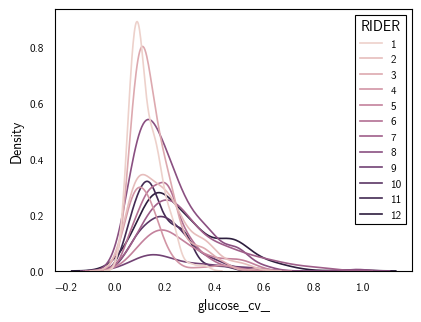

In [154]:
sns.kdeplot(x='glucose_cv_', data=df_test, hue='RIDER')
plt.show()
# TODO: we should check if this is the right test to do, what if you want to do a similar test to above but then for standard deviation?

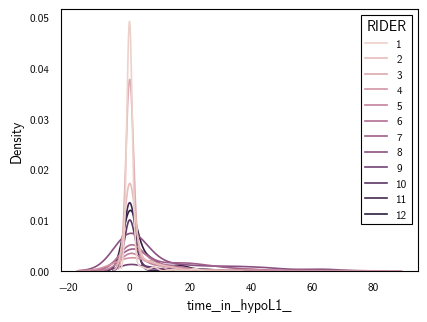

In [156]:
sns.kdeplot(x='time_in_hypoL1_', data=df_test, hue='RIDER')
plt.show()
# TODO: we should check if this is the right test to do, what if you want to do a similar test to above but then for standard deviation?

In [146]:
model = Lmer('glucose_cv_ ~ 1 + race_day_6h + (1+race_day_6h | RIDER)', data=df_test)
print(model.fit())

**NOTE**: Column for 'residuals' not created in model.data, but saved in model.resid only. This is because you have rows with NaNs in your data.

**NOTE** Column for 'fits' not created in model.data, but saved in model.fits only. This is because you have rows with NaNs in your data.

Formula: glucose_cv_~1+race_day_6h+(1+race_day_6h|RIDER)

Family: gaussian	 Inference: parametric

Number of observations: 1780	 Groups: {'RIDER': 12.0}

Log-likelihood: 1247.148 	 AIC: -2494.296

Random effects:

                     Name    Var    Std
RIDER         (Intercept)  0.003  0.057
RIDER     race_day_6hTRUE  0.001  0.029
Residual                   0.014  0.118

               IV1              IV2   Corr
RIDER  (Intercept)  race_day_6hTRUE -0.507

Fixed effects:

                 Estimate  2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)         0.205   0.172    0.238  0.017  11.079  12.161  0.000  ***
race_day_6hTRUE    -0.002  -0.026    0.022  0.012  11.303  -0.157  0.878     


In [ ]:
from rpy2.robjects.packages import importr
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

base = importr('base')
stats = importr('stats')
lme4 = importr('lme4')

# TODO: standardize???

with localconverter(ro.default_converter + pandas2ri.converter):
    r_df_test = ro.conversion.py2rpy(df_test)

In [161]:
model = lme4.glmer('time_in_hypoL1_ ~ 1 + race_day_6h + (1+race_day_6h | RIDER)', data=r_df_test, family='poisson')
print(base.summary(model))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: time_in_hypoL1_ ~ 1 + race_day_6h + (1 + race_day_6h | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L,

In [160]:
model = lme4.glmer('time_in_hypoL2_ ~ 1 + race_day_6h + (1+race_day_6h | RIDER)', data=r_df_test, family='poisson')
print(base.summary(model))

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: time_in_hypoL2_ ~ 1 + race_day_6h + (1 + race_day_6h | RIDER)
   Data: structure(list(RIDER = c(1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L, 1L,  
1L, 1L, 1L,

## Unused analyses

### Glucose during cycling (longitudinal)

In [87]:
# session id
dc['tid'] = dc.loc[dc['exercise'] != dc['exercise'].shift(), 'exercise'].cumsum()
dc['tid'] = dc['tid'].fillna(method='ffill')

# time within session
dc['t'] = dc.groupby('tid').cumcount() * 5
dc

RIDER           timestamp  Glucose Value (mg/dL)     local_timestamp  \
0            8 2018-11-05 05:00:00                   73.0 2018-11-05 06:00:00   
1            8 2018-11-05 05:05:00                   73.0 2018-11-05 06:05:00   
2            8 2018-11-05 05:10:00                   73.0 2018-11-05 06:10:00   
3            8 2018-11-05 05:15:00                   73.0 2018-11-05 06:15:00   
4            8 2018-11-05 05:20:00                   73.0 2018-11-05 06:20:00   
...        ...                 ...                    ...                 ...   
1267159      9 2019-01-27 04:35:00                   70.0 2019-01-27 05:35:00   
1267160      9 2019-01-27 04:40:00                   72.0 2019-01-27 05:40:00   
1267161      9 2019-01-27 04:45:00                   73.0 2019-01-27 05:45:00   
1267162      9 2019-01-27 04:50:00                   54.0 2019-01-27 05:50:00   
1267163      9 2019-01-27 04:55:00                   69.0 2019-01-27 05:55:00   

         exercise  recovery   wake  sleep  race_day  travel_day       date  \
0           False     False   True  False     False       False 2018-11-05   
1           False     False   True  False     False       False 2018-11-05   
2           False     False   True  False     False       False 2018-11-05   
3           False     False   True  False     False       False 2018-11-05   
4           False     False   True  False     False       False 2018-11-05   
...           ...       ...    ...    ...       ...         ...        ...   
1267159     False     False  False   True     False       False 2019-01-27   
1267160     False     False  False   True     False       False 2019-01-27   
1267161     False     False  False   True     False       False 2019-01-27   
1267162     False     False  False   True     False       False 2019-01-27   
1267163     False     False  False   True     False       False 2019-01-27   

         exercise_day    date_6h  race_day_6h  travel_day_6h  exercise_day_6h  \
0                True 2018-11-05        False          False             True   
1                True 2018-11-05        False          False             True   
2                True 2018-11-05        False          False             True   
3                True 2018-11-05        False          False             True   
4                True 2018-11-05        False          False             True   
...               ...        ...          ...            ...              ...   
1267159          True 2019-01-26        False          False             True   
1267160          True 2019-01-26        False          False             True   
1267161          True 2019-01-26        False          False             True   
1267162          True 2019-01-26        False          False             True   
1267163          True 2019-01-26        False          False             True   

         completeness     tid     t  
0            0.920139     0.0     0  
1            0.920139     0.0     5  
2            0.920139     0.0    10  
3            0.920139     0.0    15  
4            0.920139     0.0    20  
...               ...     ...   ...  
1267159      0.961806  1971.0  1135  
1267160      0.961806  1971.0  1140  
1267161      0.961806  1971.0  1145  
1267162      0.961806  1971.0  1150  
1267163      0.961806  1971.0  1155  

[574962 rows x 19 columns]

All

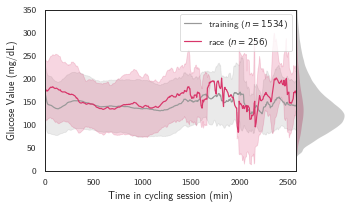

In [90]:
n_nc = len(dc.loc[~dc['race_day_6h'] & dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates())
n_rc = len(dc.loc[dc['race_day_6h'] & dc['exercise_day_6h'], ['RIDER', 'date_6h']].drop_duplicates())

t_max = dc.groupby('tid')['t'].max().quantile(0.9) #dc['t'].max()

fig, ax = plt.subplots(1,2, figsize=(5, 3), sharey=True, gridspec_kw={'width_ratios': [5, 1], 'wspace':0}, tight_layout=True)
sns.lineplot(data = dc[dc['exercise_day_6h']], x='t', y=COL, hue='race_day_6h', ci='sd', palette=list(color_race.values()), ax=ax[0])
ax[0].set_xlabel('Time in cycling session (min)')
ax[0].legend(loc='upper right', handles=ax[0].get_legend().get_lines(), 
	labels=['training'+r' ($n = {:.0f}$)'.format(n_nc), 'race'+r' ($n = {:.0f}$)'.format(n_rc)])
sns.kdeplot(data=dc.loc[dc['t'].notna() & dc['exercise_day_6h']], y=COL, hue='race_day_6h', ax=ax[1],
	fill=True, alpha=.5, palette=list(color_race.values()), linewidth=0, legend=False)
sns.despine(bottom=True, right=True, top=True, ax=ax[1])
ax[1].set(xlabel=None, xticks=[])
plt.ylim((0,350))
ax[0].set_xlim((0, t_max))
savefig('time_cycling/glucose_cycling')

Individual athletes

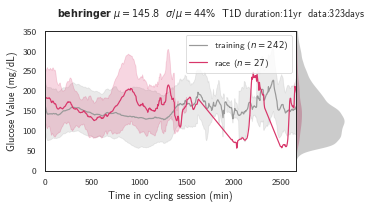

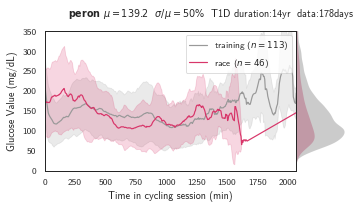

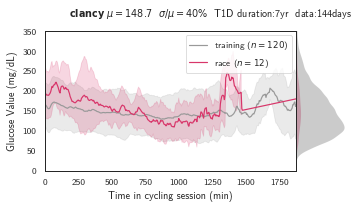

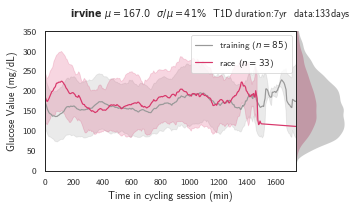

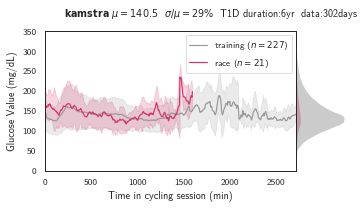

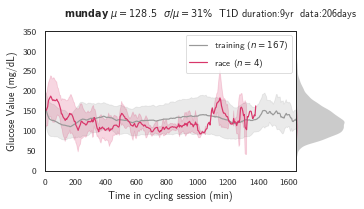

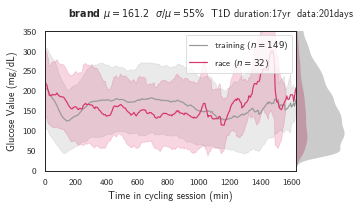

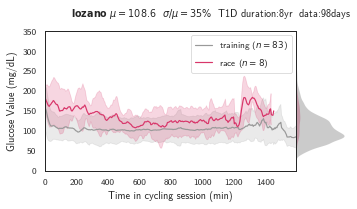

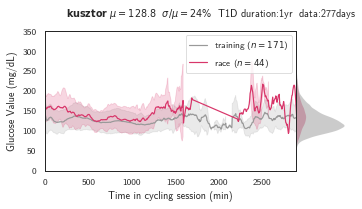

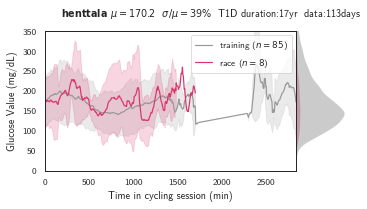

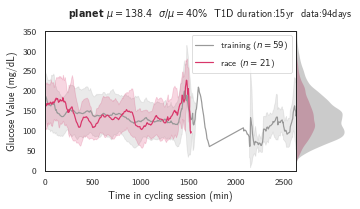

In [93]:
for i in dc[dc['race_day_6h']].RIDER.unique():
	n_nc = len(dc.loc[(dc.RIDER == i) & ~dc['race_day_6h'] & dc['exercise_day_6h'], 'date_6h'].unique())
	n_rc = len(dc.loc[(dc.RIDER == i) & dc['race_day_6h'] & dc['exercise_day_6h'], 'date_6h'].unique())

	t_max = dc[dc.RIDER == i].groupby('tid')['t'].max().quantile(0.9)#dc.loc[dc.RIDER == i, 't'].max()

	fig, ax = plt.subplots(1,2, figsize=(5, 3), sharey=True, gridspec_kw={'width_ratios': [5, 1], 'wspace':0}, tight_layout=True)
	sns.lineplot(data=dc[(dc.RIDER == i) & dc['exercise_day_6h']], x='t', y=COL, ci='sd', hue='race_day_6h', palette=list(color_race.values()), ax=ax[0])
	ax[0].set_xlabel('Time in cycling session (min)')
	ax[0].legend(loc='upper right', handles=ax[0].get_legend().get_lines(),
		labels=['training'+r' ($n = {:.0f}$)'.format(n_nc), 'race'r' ($n = {:.0f}$)'.format(n_rc)])
	sns.kdeplot(data=dc.loc[dc['t'].notna() & (dc.RIDER == i) & dc['exercise_day_6h']], y=COL, hue='race_day_6h', ax=ax[1],
		fill=True, alpha=.5, palette=list(color_race.values()), linewidth=0, legend=False)
	sns.despine(bottom=True, right=True, top=True, ax=ax[1])
	ax[1].set(xlabel=None, xticks=[])
	plt.ylim((0,350))
	ax[0].set_xlim((0, t_max))
	title = r'$\mu = {:.1f}$  $\sigma/\mu = {:.0f}\%$  T1D duration:{:.0f}yr  data:{:.0f}days'\
		.format(dc[(dc.RIDER == i) & dc['exercise_day']][COL].mean(),
				dc[(dc.RIDER == i) & dc['exercise_day']][COL].std()/dc[(dc.RIDER == i) & dc['exercise_day']][COL].mean()*100,
				info.loc[i, 'diabetes_duration'],
				len(dc_agg[dc_agg.RIDER == i]))
	savefig(path='time_cycling/glucose_cycling', i=i, title=title, x=-1.7, y=1.06)

### Glucose during day

In [89]:
dc['time'] = timestamp_to_seconds(dc['local_timestamp'])

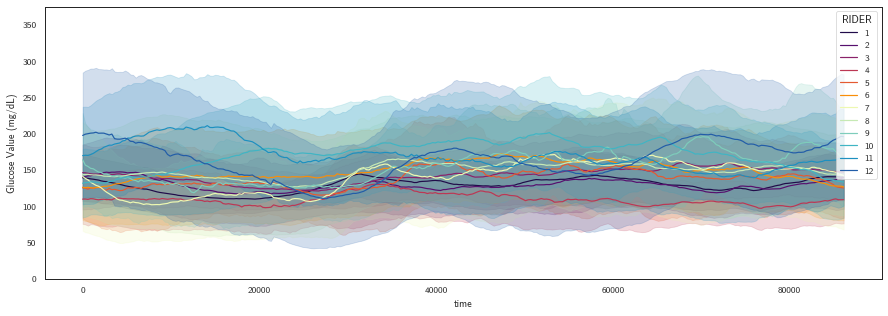

In [90]:
plt.figure(figsize=(15,5))
sns.lineplot(data=dc, x='time', y=COL, ci='sd', hue='RIDER', palette=palette_ath)
plt.ylim((0,375))
plt.show()

### Days with hypo events (during sections)

In [104]:
dc_agg = dc_agg.set_index(['RIDER', 'date'])

In [ ]:
dc_hypo = {}
for sec in SECTIONS+('1d',):
    dc_hypo[sec] = dc_agg['hypo_'+sec].groupby('RIDER').apply(lambda x: x.sum()/len(x))
dc_hypo = pd.concat(dc_hypo, axis=1) * 100
dc_hypo = dc_hypo.rename(columns={'1d':'total'})

In [82]:
dc_hyper = {}
for sec in SECTIONS+('1d',):
    dc_hyper[sec] = dc_agg['hyper_'+sec].groupby('RIDER').apply(lambda x: x.sum()/len(x))
dc_hyper = pd.concat(dc_hyper, axis=1) * 100
dc_hyper = dc_hyper.rename(columns={'1d':'total'})

Text(0.5, 1.0, 'Days in hyperglycemia')

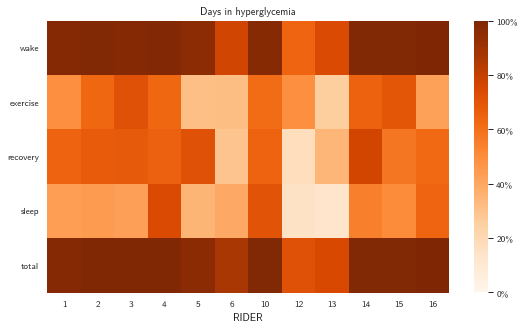

In [83]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(dc_hyper.T, vmin=0, vmax=100, cmap='Oranges')
fig.get_axes()[1].set_yticks(np.arange(0,101,20), ["{:.0f}%".format(j) for j in np.arange(0,101,20)])
plt.yticks(rotation=0)
plt.title("Days in hyperglycemia")

Text(0.5, 1.0, 'Days in hypoglycemia')

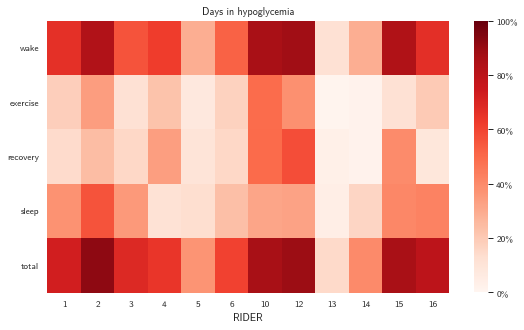

In [84]:
fig, ax = plt.subplots(figsize=(9,5))
sns.heatmap(dc_hypo.T, vmin=0, vmax=100, cmap='Reds')
fig.get_axes()[1].set_yticks(np.arange(0,101,20), ["{:.0f}%".format(j) for j in np.arange(0,101,20)])

plt.yticks(rotation=0)
plt.title("Days in hypoglycemia")

In [85]:
dc_events = {}
for sec in SECTIONS+('1d',):
    dc_events[sec] = dc_agg[['time_in_hypo_'+sec, 'time_in_hyper_'+sec]].div(dc_agg['count_'+sec], axis=0)
    dc_events[sec].columns = ['_'.join(col.split('_')[:-1]) for col in dc_events[sec].columns]
    dc_events[sec] *= 100
    dc_events[sec] = dc_events[sec].sort_index(level=1)
    mask = (dc_events[sec]['time_in_hypo'] != 0) & (dc_events[sec]['time_in_hyper'] != 0)
    dc_events[sec].loc[mask, 'time_in_both'] = dc_events[sec]['time_in_hypo'] + dc_events[sec]['time_in_hyper']
    dc_events[sec].loc[mask, ['time_in_hypo', 'time_in_hyper']] = 0
    dc_events[sec] = dc_events[sec].replace({0:np.nan})

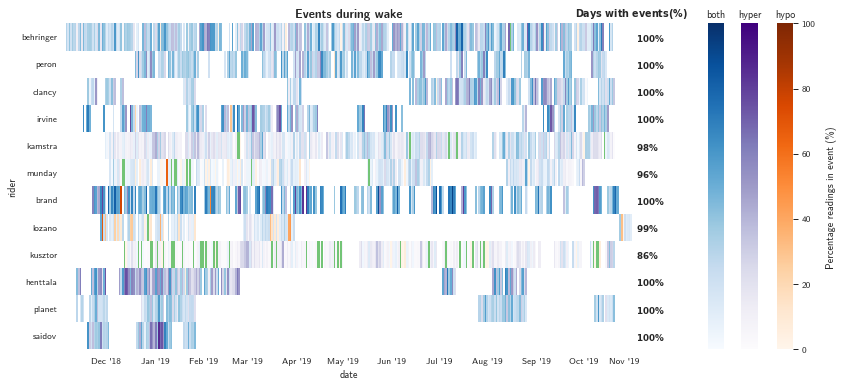

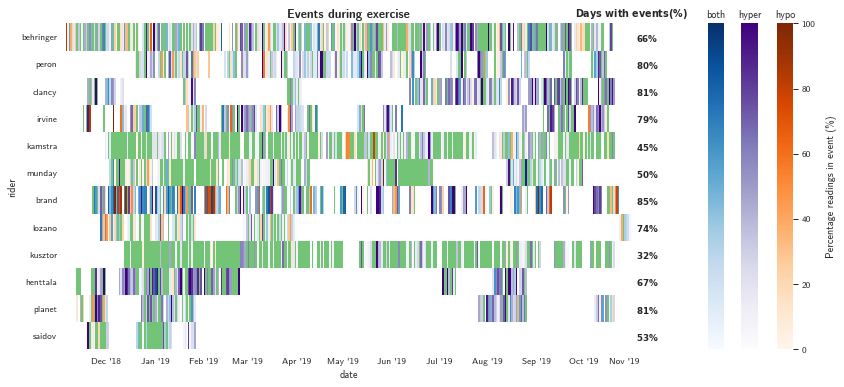

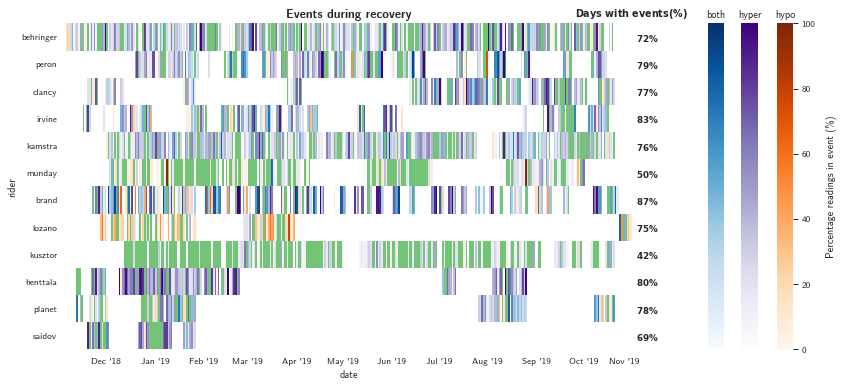

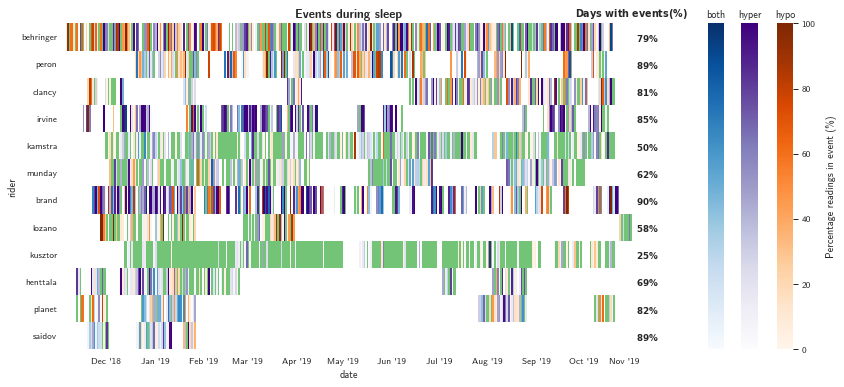

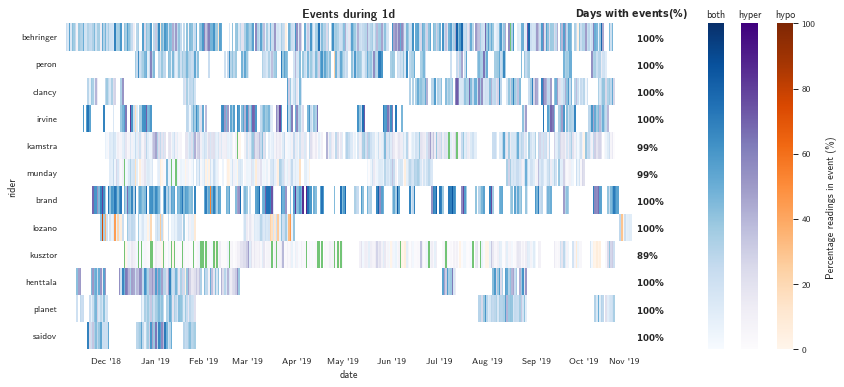

In [86]:
EVENTS = {'hypo': {'cmap':'Oranges', 'cbar_kws':{'pad':-0.1}},
          'hyper':{'cmap':'Purples', 'cbar_kws':{'pad':-0.1}}, 
          'both': {'cmap':'Blues'  , 'cbar_kws':{'pad':0.1}}}
for sec in SECTIONS+('1d',):
    fig, ax = plt.subplots(figsize=(15,6))
    
    df_avail = dc_events[sec].isna().all(axis=1).astype(float).unstack()
    sns.heatmap(df_avail, ax=ax, vmin=0, vmax=2, cmap='Greens', cbar=False)
    for event, kwargs in EVENTS.items():
        df_avail = dc_events[sec]['time_in_'+event].unstack()
        sns.heatmap(df_avail, ax=ax, vmin=0, vmax=100, **kwargs)
    
    # percentage columns
    perc_events = dc_events[sec].unstack().count(axis=1)/\
        dc_events[sec].reset_index().groupby('RIDER')['date'].count()*100
    ax2 = ax.secondary_yaxis("right")
    ax2.set_yticks(np.arange(len(df_avail.index))+0.5)
    ax2.set_yticklabels([r"$\bf{:.0f}\%$".format(i) for i in perc_events])
    ax2.tick_params(axis='y', length=0)
    ax2.spines['right'].set_visible(False)
    ax.text(0.9, 1.02, r'$\bf{:s}$'.format('Days\ with\ events (\%)'), ha='left', transform=ax.transAxes) 
    
    # colorbar
    for j, cbar_ax in enumerate(fig.get_axes()[1:]):
        if j != 0:
            cbar_ax.set_yticks([]) ; cbar_ax.set_yticklabels([])
        cbar_ax.set_title(list(EVENTS.keys())[j])
        if j == 0:
            cbar_ax.text(3, dc_events[sec].max().max()/2, 'Percentage readings in event (%)', va='center', rotation=90)
            
    monthyear = df_avail.columns.strftime("%b '%y")
    ticksloc = np.where(monthyear.to_series().shift() != monthyear.to_series())[0][1:]
    plt.xticks(ticks=ticksloc, labels=monthyear[ticksloc], rotation=0)
    plt.xlabel('date')
    plt.ylabel('rider')
    plt.title('Events during '+sec, fontweight='bold', fontsize=12)
    savefig('events/events', i=sec, yticks=ax)